In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Static inline plots
%matplotlib inline

# Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage
import joblib

timer = mypackage.Timer()

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra_all", only_with_contaminant=True)

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = mypackage.Dataset.train_test_split(X, Y, testRatio=0.3)
X_test_orig, X_train_orig, scaler = mypackage.Dataset.scale(X_test_orig, X_train_orig, scaler='GlobalStandardization')

# X_train_orig, X_test_orig, Y_train_orig, Y_test_orig = X_train_orig[:5], X_test_orig[:5], Y_train_orig[:5], Y_test_orig[:5]

# save the scaler to disk
filename = 'latest_scaler_used.sav'
joblib.dump(scaler, filename)
# # load the scaler from disk
# scaler = joblib.load(filename)

zoom = lambda X, Y, size, mp, noise=True: mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=size, 
                                                             sample_multiplication=mp, contaminant_type=2,
                                                             zoom_with_noise=noise, flip=True)

In [3]:
######################################################
# Need extra padding for the HybridSN classification
window_size = 25
margin = int((window_size - 1) / 2)
padding = margin * 2
size = 32 + padding

s, m = size, 1
X_train_HS, Y_train_HS = zoom(X_train_orig, Y_train_orig, s, m, noise=False)
X_test_HS,  Y_test_HS  = zoom(X_test_orig,  Y_test_orig,  s, m, noise=False)
#######################################################

# Test HybridSN

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 25, 208, 1)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 23, 23, 68, 8)     512       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 21, 21, 22, 16)    5776      
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 19, 19, 7, 32)     13856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 19, 19, 224)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 17, 17, 64)        129088    
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0   

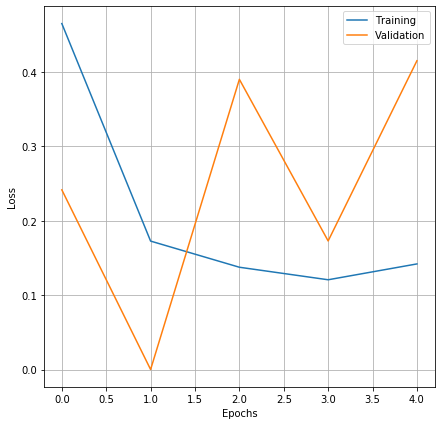

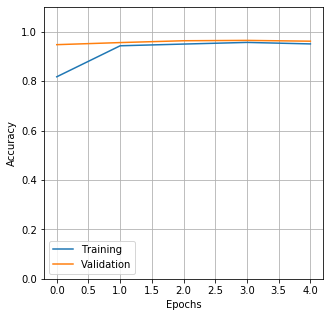

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     30687
         1.0       0.92      0.98      0.94     13040
         2.0       0.84      0.44      0.58      1329

    accuracy                           0.97     45056
   macro avg       0.91      0.80      0.84     45056
weighted avg       0.97      0.97      0.96     45056



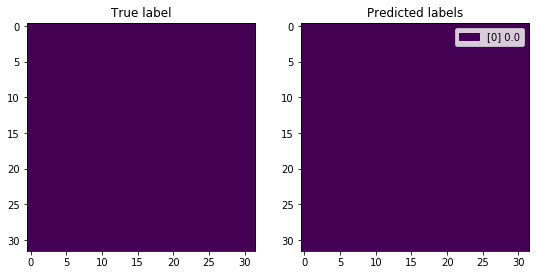

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     12758
         1.0       0.94      0.97      0.96      6217
         2.0       0.59      0.46      0.52       481

    accuracy                           0.96     19456
   macro avg       0.84      0.80      0.82     19456
weighted avg       0.96      0.96      0.96     19456



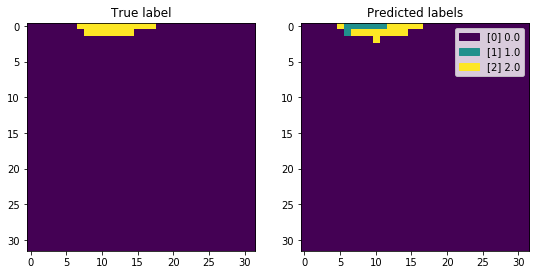

Elapsed time: 195.5631 seconds


In [4]:
n_train = 16 # if 16 then 30min per epoch
n_test  = 4
model = mypackage.HybridSN(X_train_HS, Y_train_HS, X_test_HS, Y_test_HS)
model.summary()

timer.start()
model.train(epochs=5)
timer.stop()

model.plot_training_results()
model.predict(X_train_HS, Y_train_HS)
timer.start()
Y_hat = model.predict(X_test_HS, Y_test_HS)
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test_HS)}")

In [3]:
# Moved this here to fix problems with HybridSN
s, m = 32, 30
X_train, Y_train = zoom(X_train_orig, Y_train_orig, s, m)
X_test,  Y_test  = zoom(X_test_orig,  Y_test_orig,  s, m)

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)
print(np.unique(Y_train, return_counts=True))
print(np.unique(Y_test, return_counts=True))

[0. 1. 2.] (760, 32, 32, 1) (-7.344042778015137, 9.592196464538574) (760, 32, 32, 208) (1760, 32, 32, 208)
(array([0., 1., 2.]), array([1453547,  325701,   22992]))
(array([0., 1., 2.]), array([631508, 136330,  10402]))


# Testing SVM

In [6]:
# Started the training at ~16:30
# Finished training at ~17:00

In [18]:
Y_train_orig.shape, Y_test_orig.shape

((44, 100, 100, 1), (19, 100, 100, 1))

Start training
Elapsed time: 1996.8552 seconds
Training data prediction
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    372977
           1       0.96      0.97      0.96     62189
           2       0.94      0.69      0.79      4834

    accuracy                           0.99    440000
   macro avg       0.96      0.88      0.92    440000
weighted avg       0.99      0.99      0.99    440000

Test data prediction
Elapsed time: 639.2142 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163381
           1       0.95      0.97      0.96     24690
           2       0.93      0.51      0.66      1929

    accuracy                           0.99    190000
   macro avg       0.96      0.83      0.87    190000
weighted avg       0.99      0.99      0.99    190000



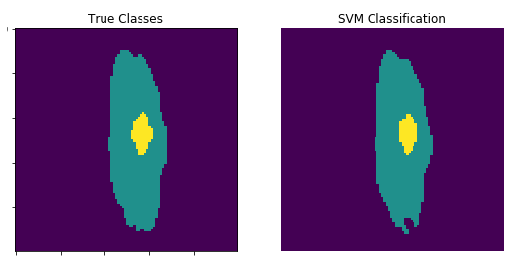

In [8]:
from sklearn import svm
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train_orig, Y_train_orig)
test = mypackage.StackTransform(X_test_orig, Y_test_orig)

svc_classifier = svm.SVC(C=1, kernel='rbf', decision_function_shape='ovr')
print("Start training")
timer.start()
svc_classifier.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_svm_model.sav'
joblib.dump(svc_classifier, filename)

# # load the model from disk
# svc_classifier = joblib.load(filename)
Y_hat = svc_classifier.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = svc_classifier.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test_orig)}")

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test_orig[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("SVM Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

# Testing Logistic Regression

Start training
Elapsed time: 7382.2887 seconds
Training data prediction
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   1453547
         1.0       0.97      0.97      0.97    325701
         2.0       0.91      0.78      0.84     22992

    accuracy                           0.99   1802240
   macro avg       0.96      0.92      0.93   1802240
weighted avg       0.99      0.99      0.99   1802240

Test data prediction
Elapsed time: 0.5398 seconds
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    631508
         1.0       0.96      0.97      0.96    136330
         2.0       0.81      0.62      0.71     10402

    accuracy                           0.99    778240
   macro avg       0.92      0.86      0.89    778240
weighted avg       0.99      0.99      0.99    778240



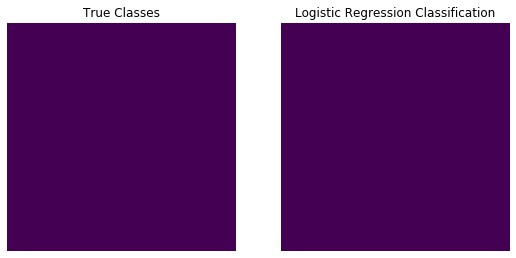

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

train = mypackage.StackTransform(X_train, Y_train)
test = mypackage.StackTransform(X_test, Y_test)

logreg = LogisticRegression(C=1e5, max_iter=50000)
print("Start training")
timer.start()
logreg.fit(train.X_stack(), train.Y_stack().ravel())
timer.stop()

# save the model to disk
filename = 'latest_LogisticReg_model.sav'
joblib.dump(logreg, filename)

# # load the model from disk
# logreg = joblib.load(filename)
Y_hat = logreg.predict(train.X_stack())
classification = classification_report(train.Y_stack(), Y_hat) # .flatten()
print("Training data prediction")
print(classification)
print("Test data prediction")
timer.start()
Y_hat = logreg.predict(test.X_stack())
timer.stop()
classification = classification_report(test.Y_stack(), Y_hat) # .flatten()
print(classification)

Y_hat = test.Unstack(Y_hat, k=1)
print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat, Y_test)}")

import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.title("True Classes")
plt.imshow(np.squeeze(Y_test[0]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Classification")
plt.imshow(np.squeeze(Y_hat[0]))
plt.axis('off');

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



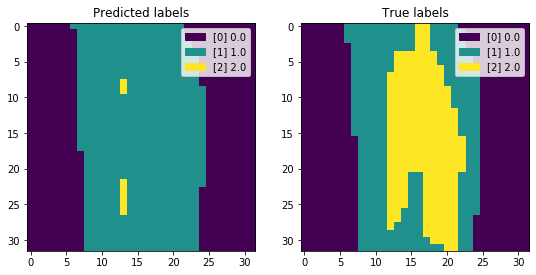

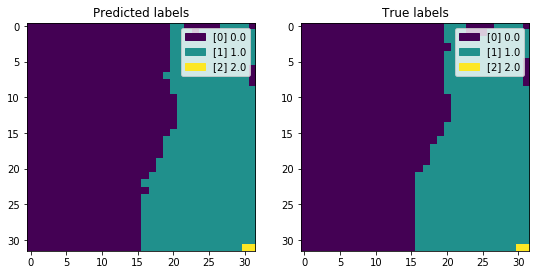

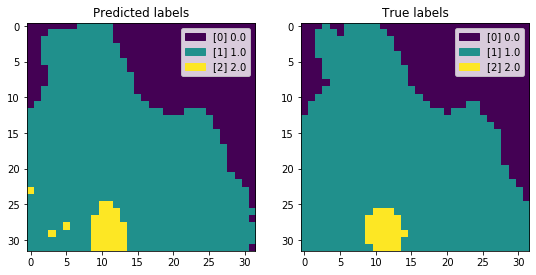

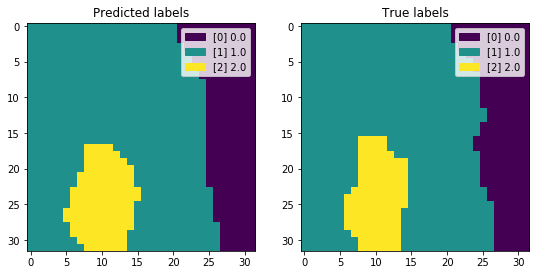

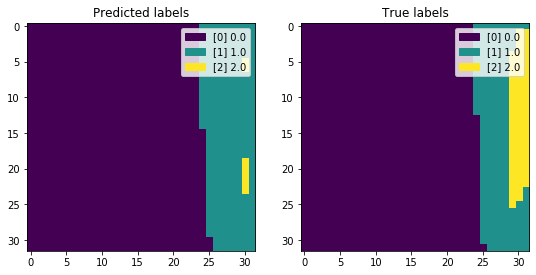

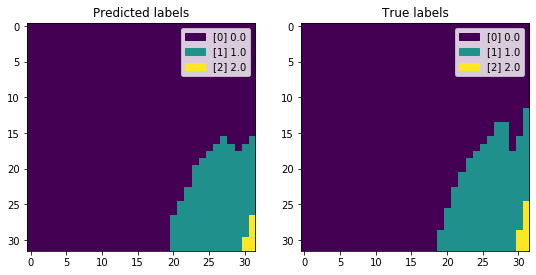

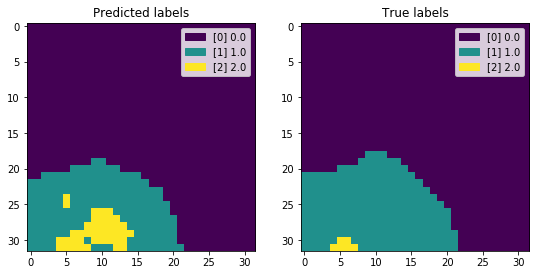

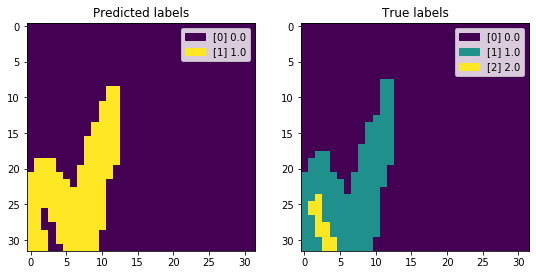

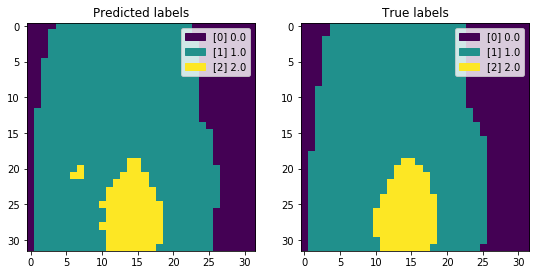

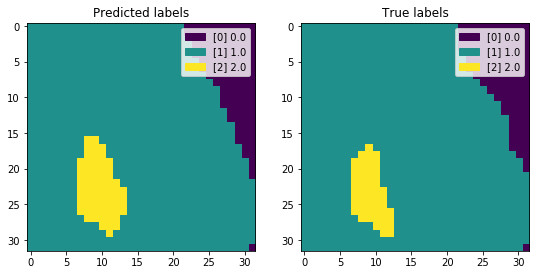

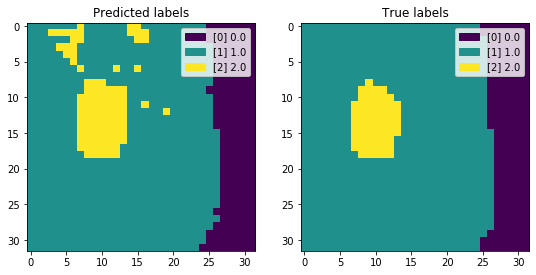

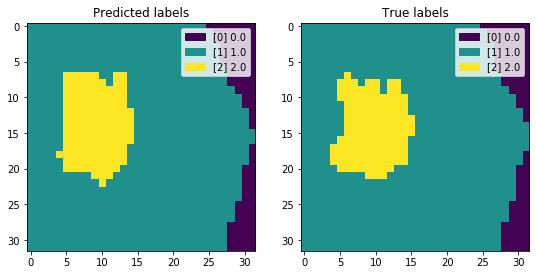

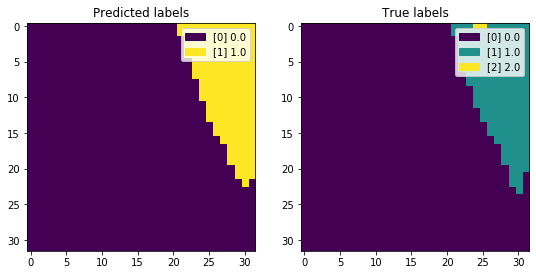

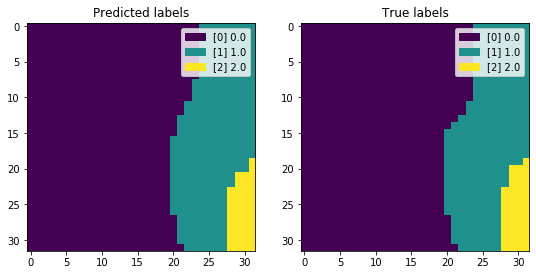

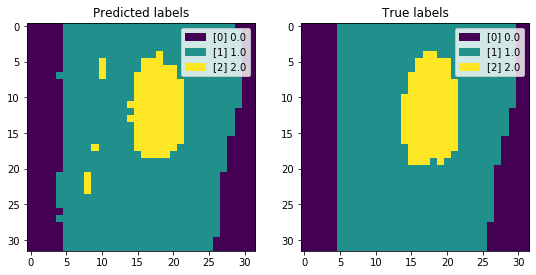

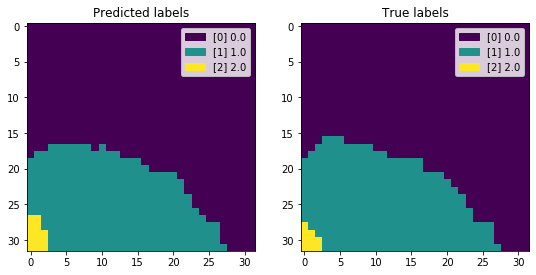

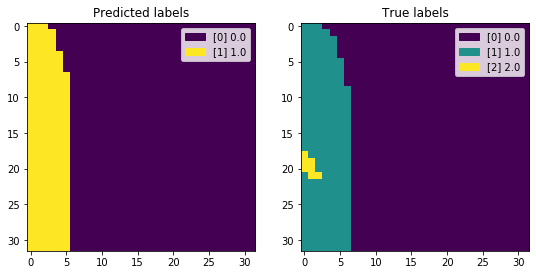

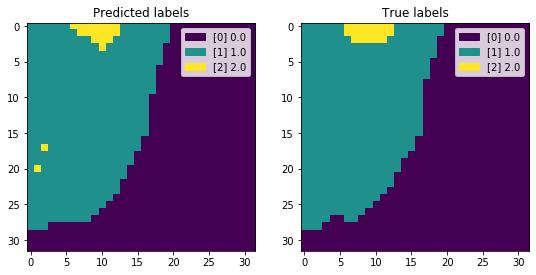

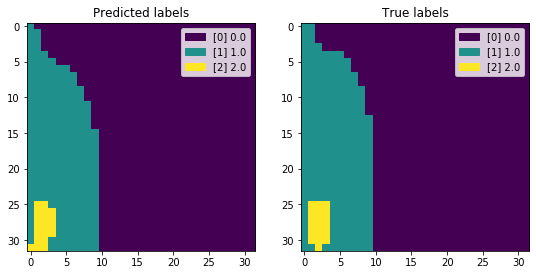

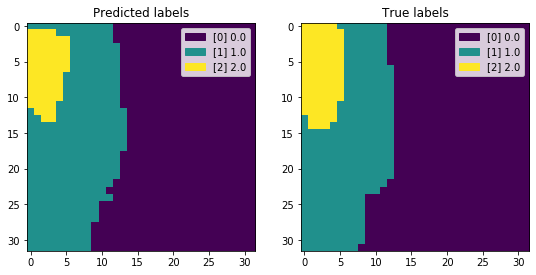

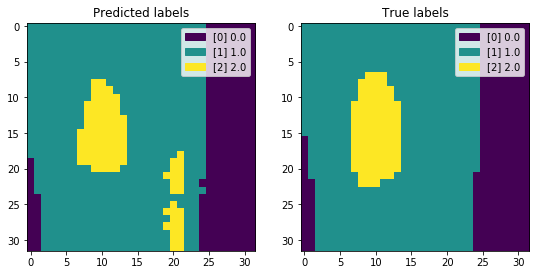

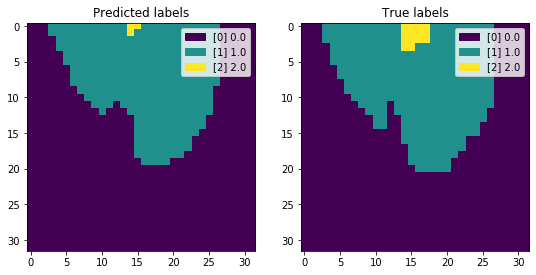

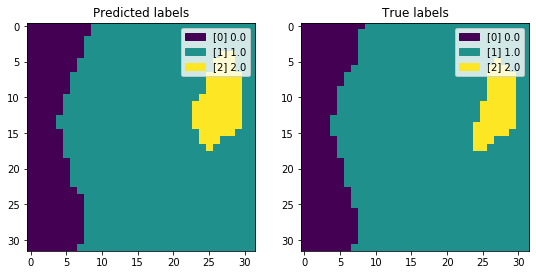

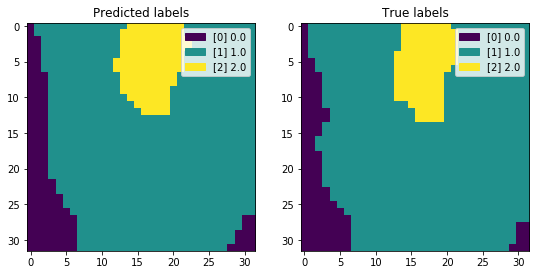

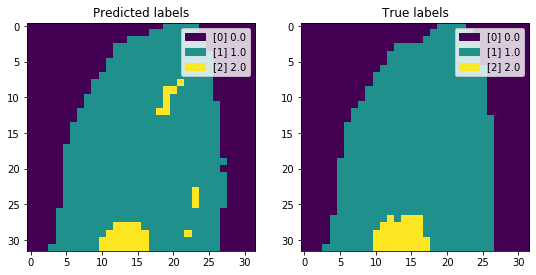

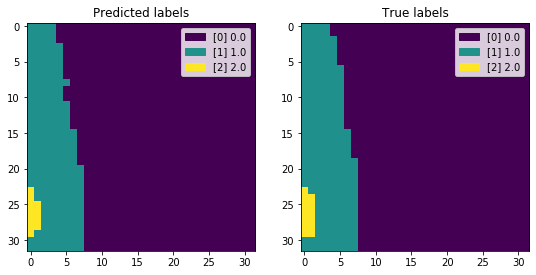

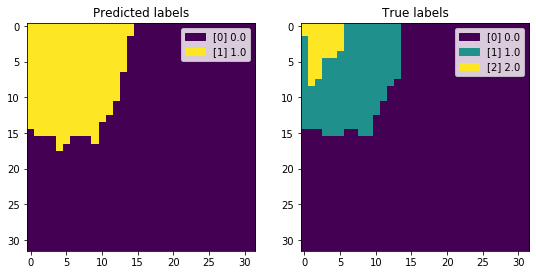

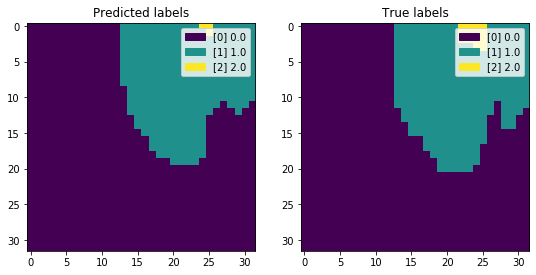

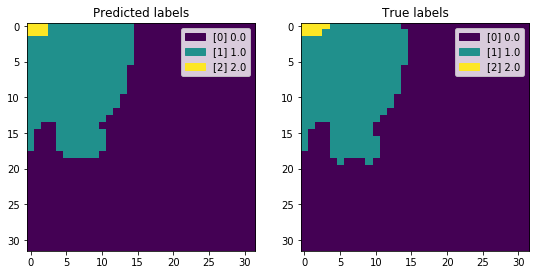

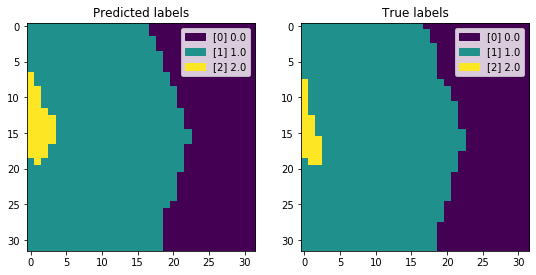

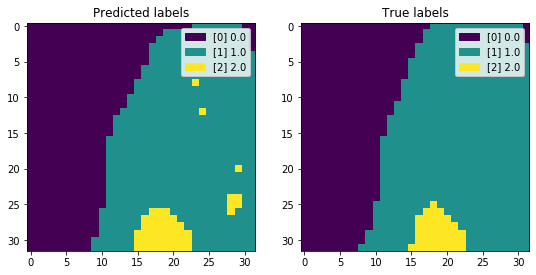

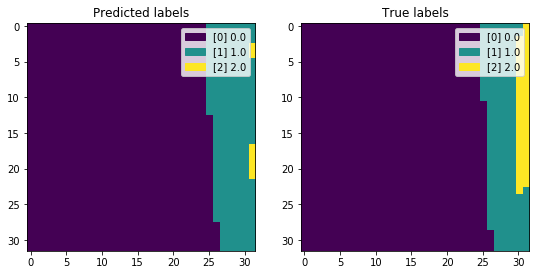

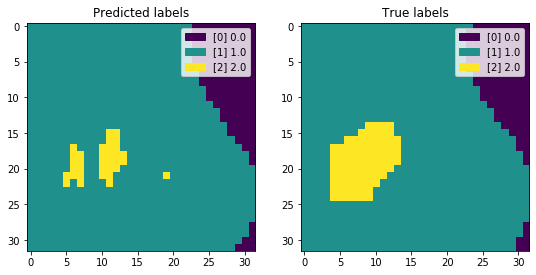

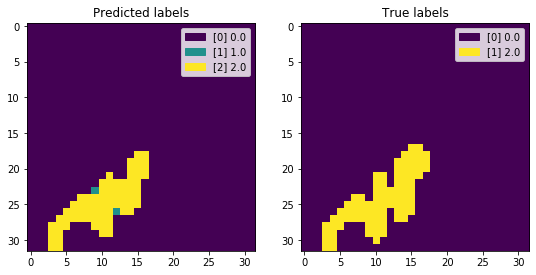

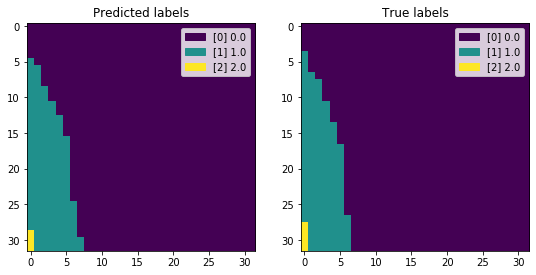

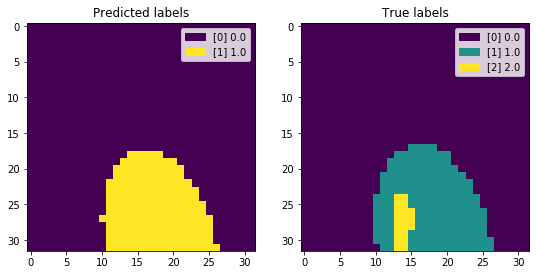

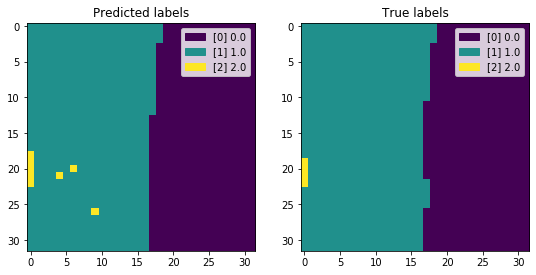

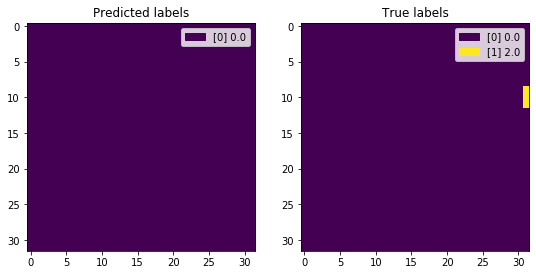

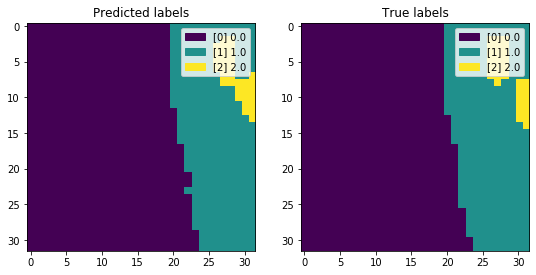

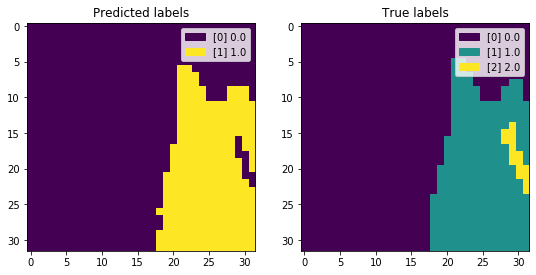

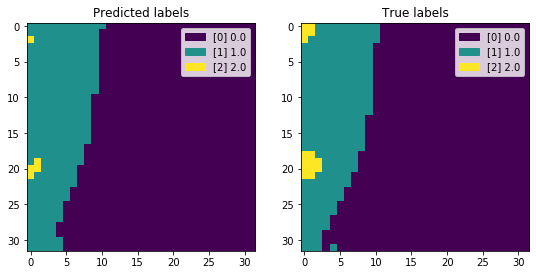

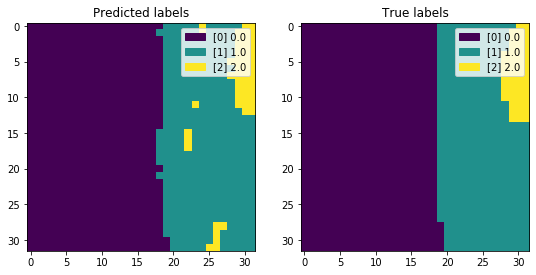

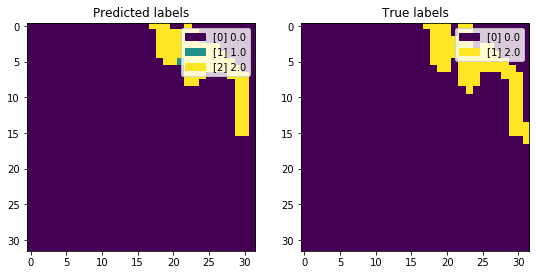

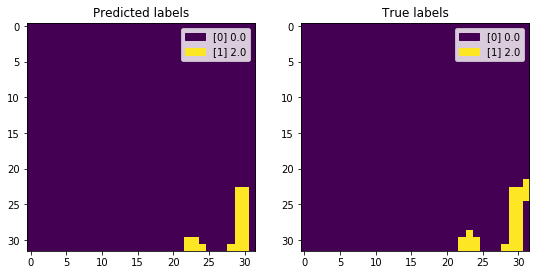

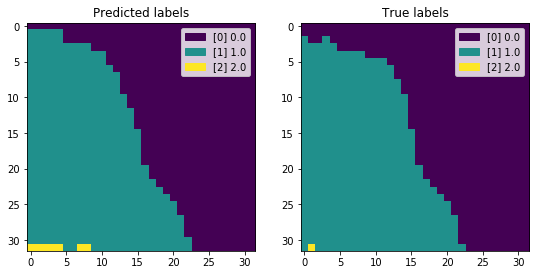

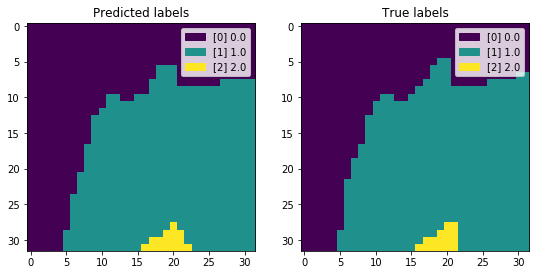

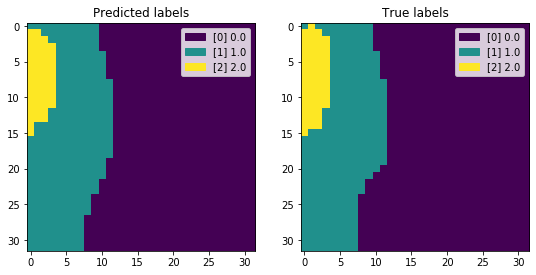

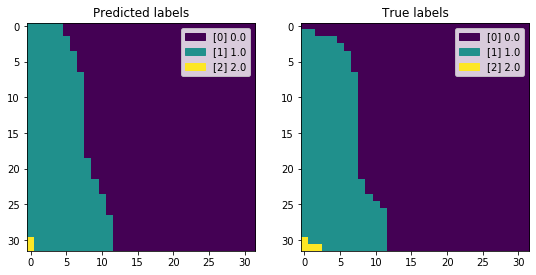

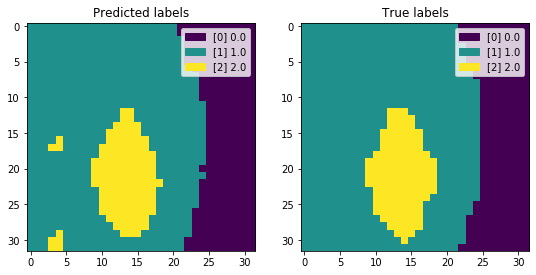

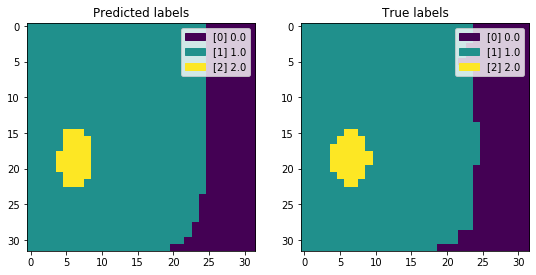

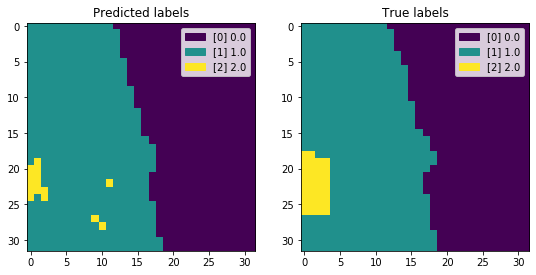

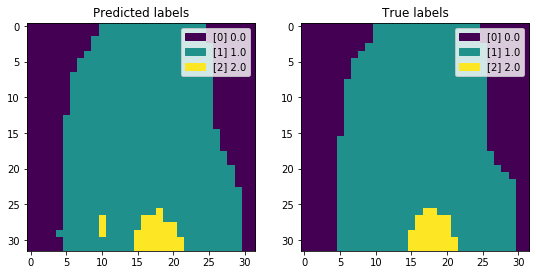

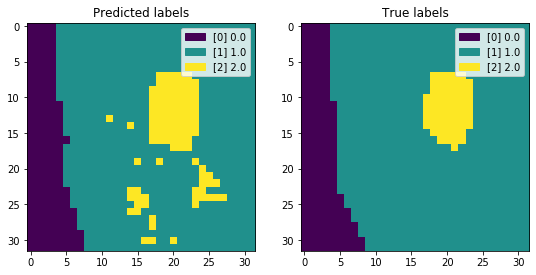

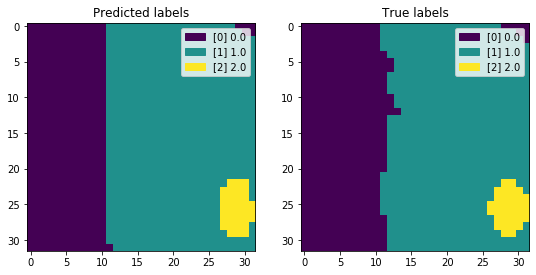

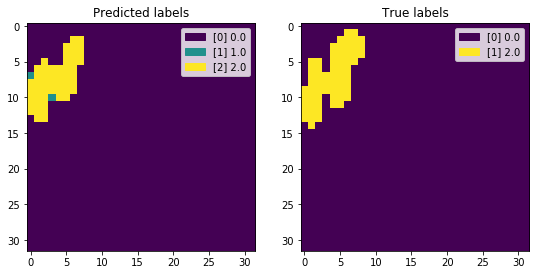

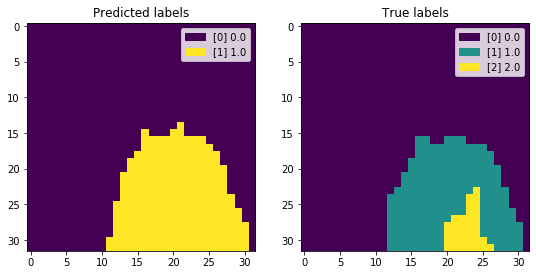

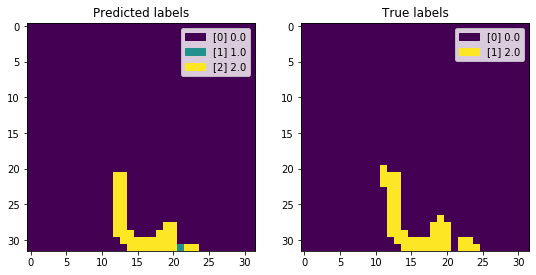

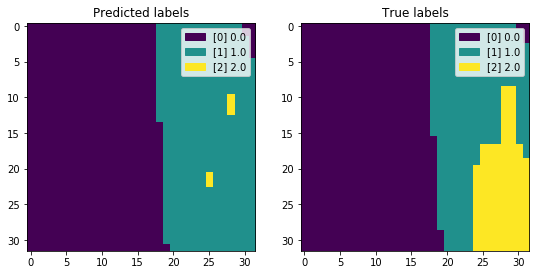

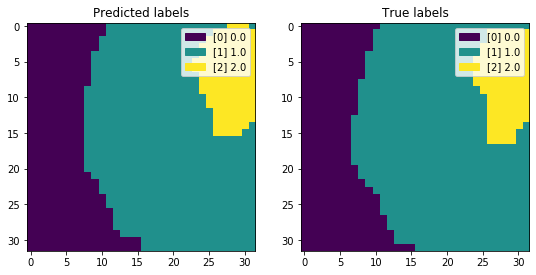

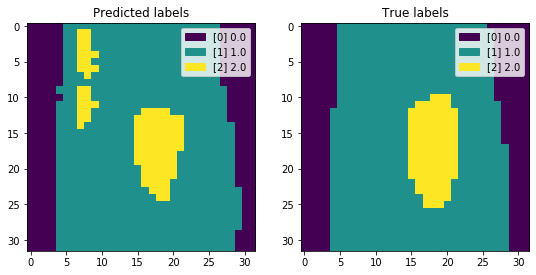

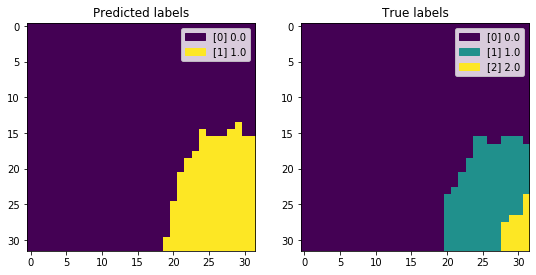

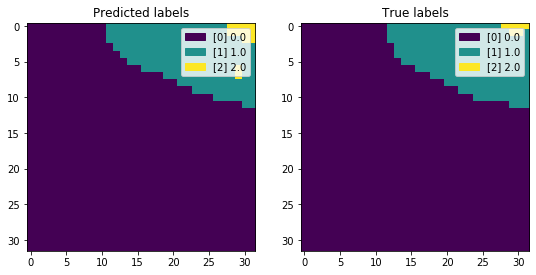

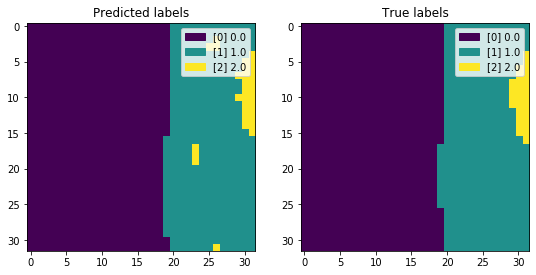

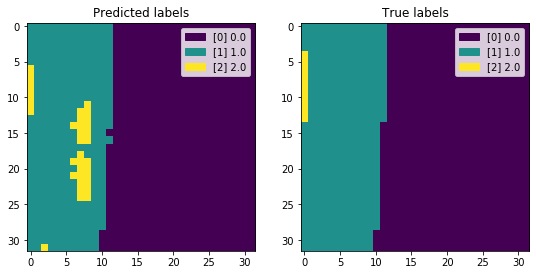

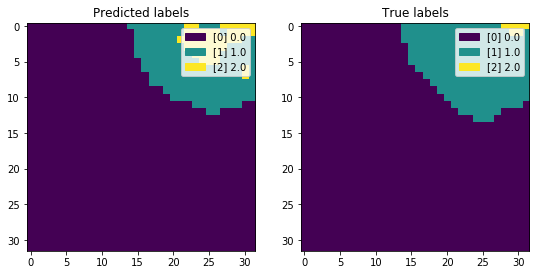

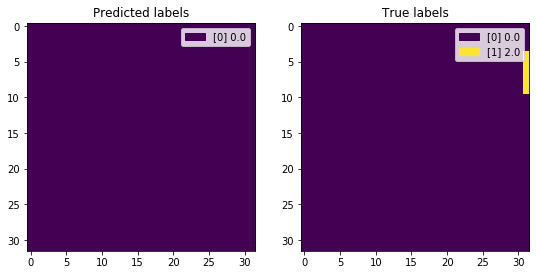

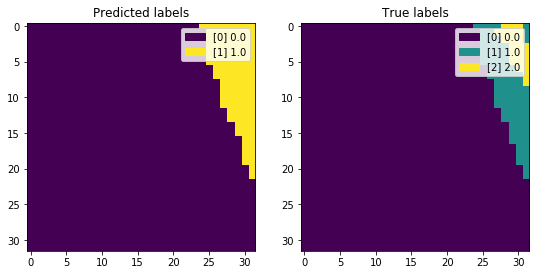

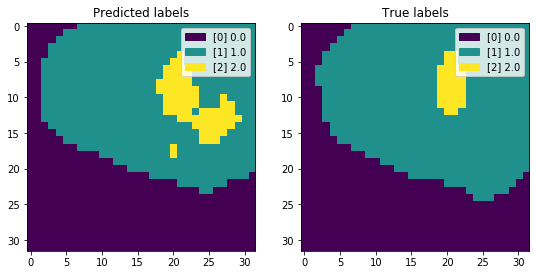

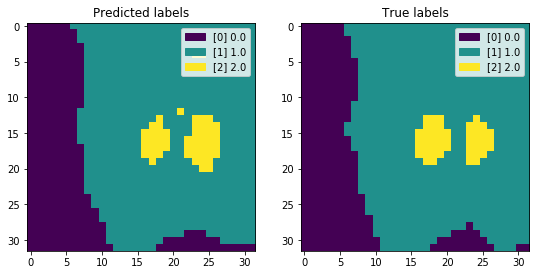

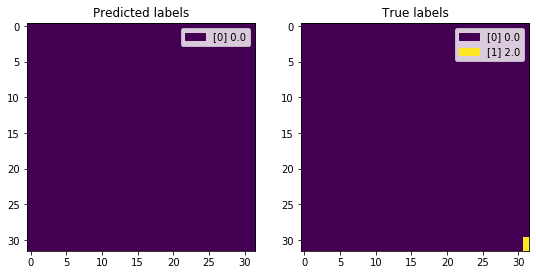

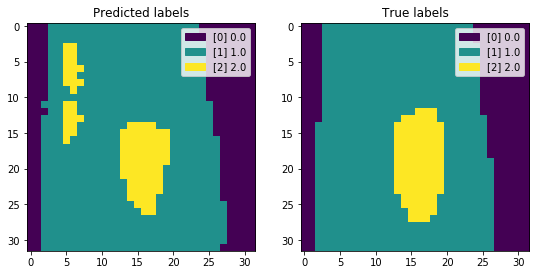

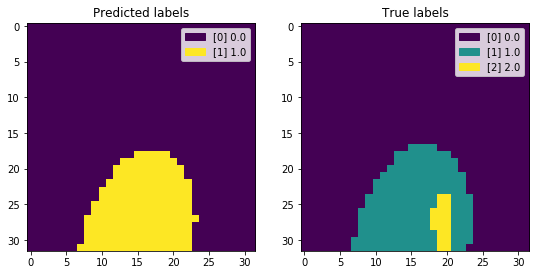

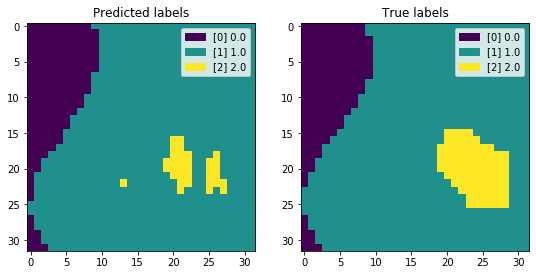

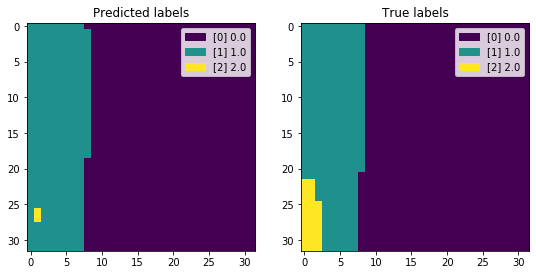

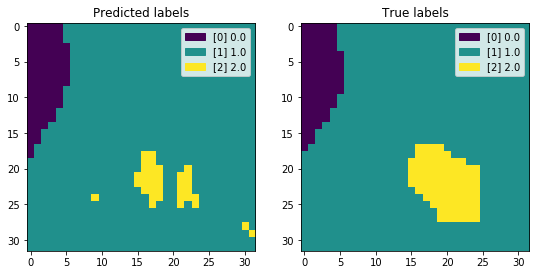

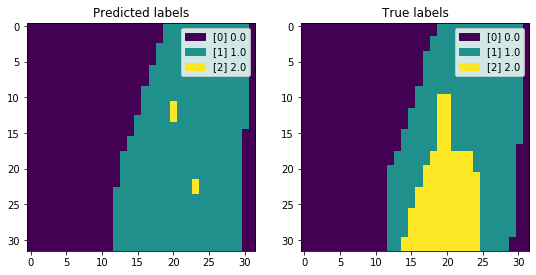

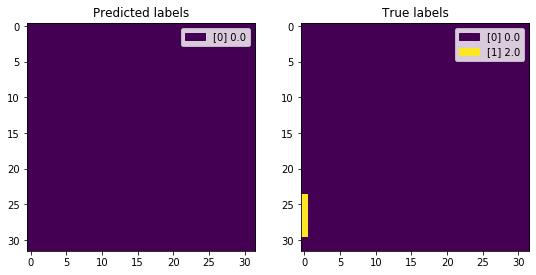

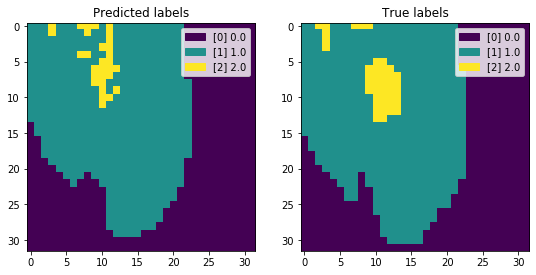

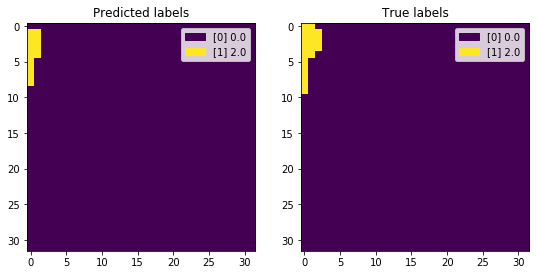

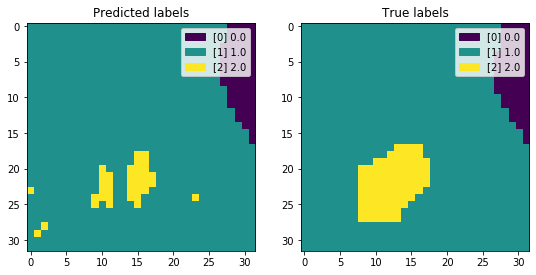

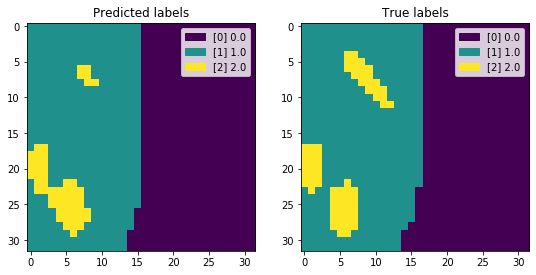

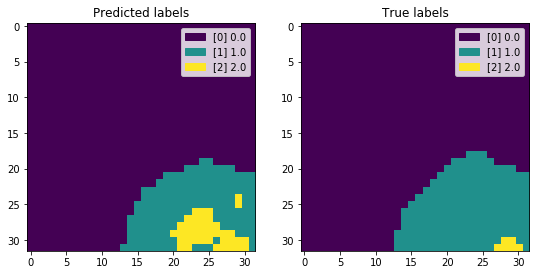

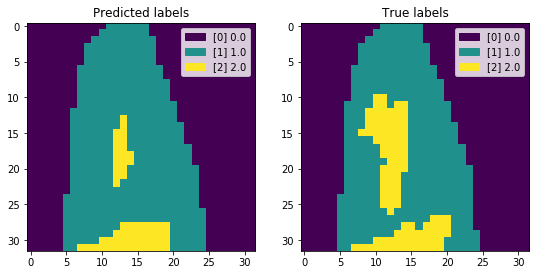

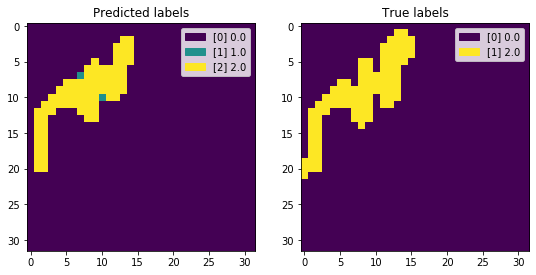

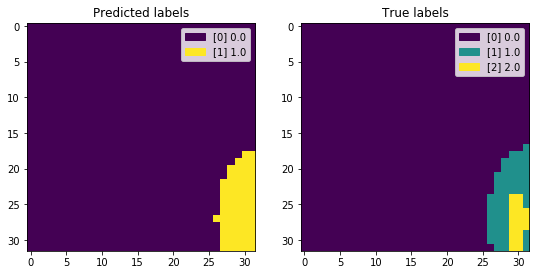

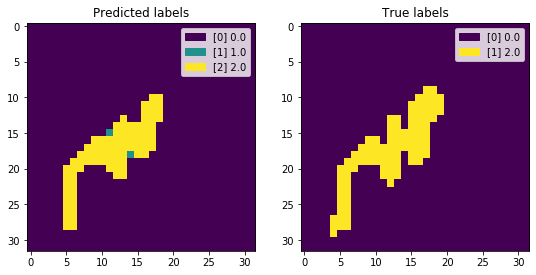

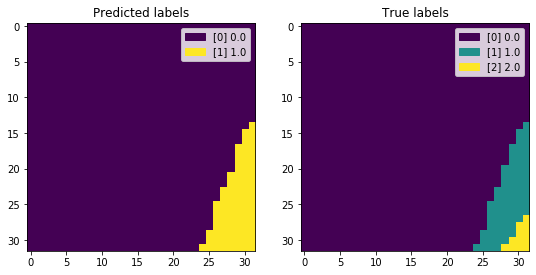

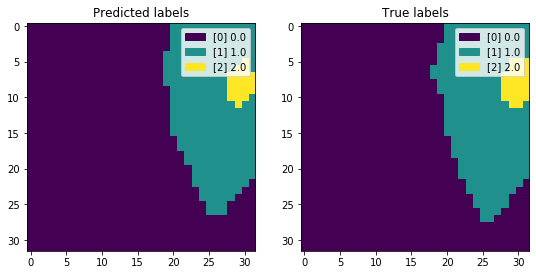

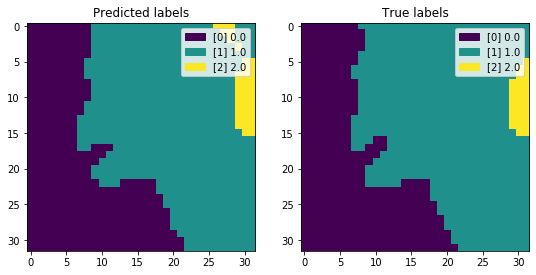

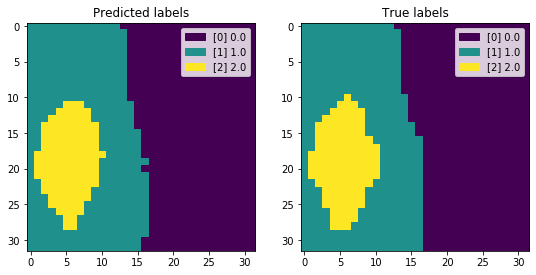

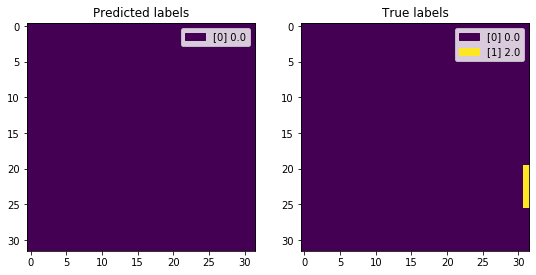

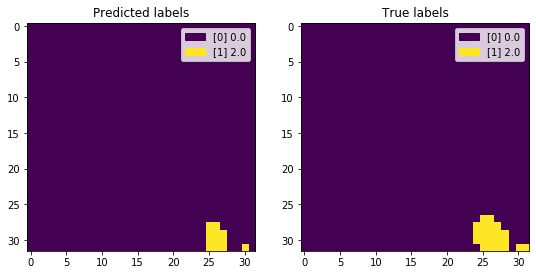

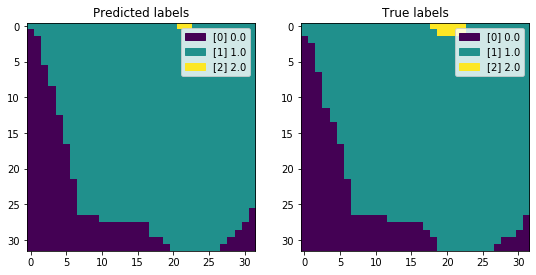

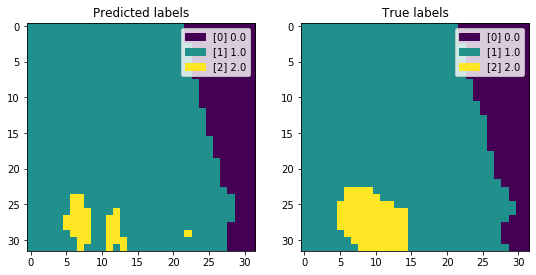

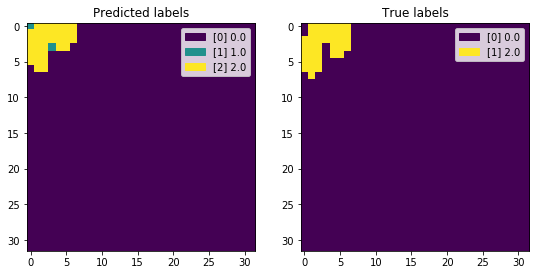

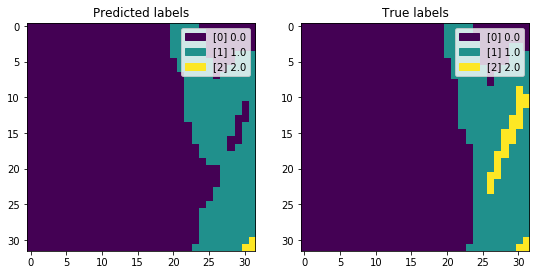

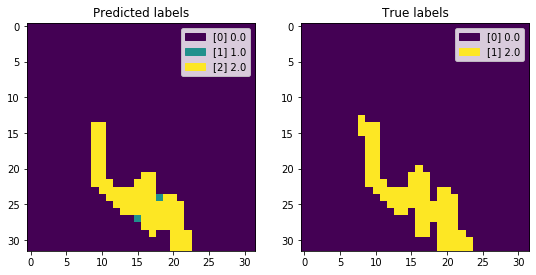

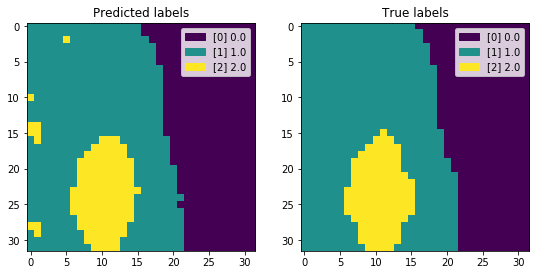

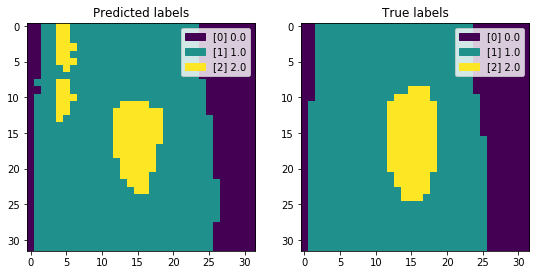

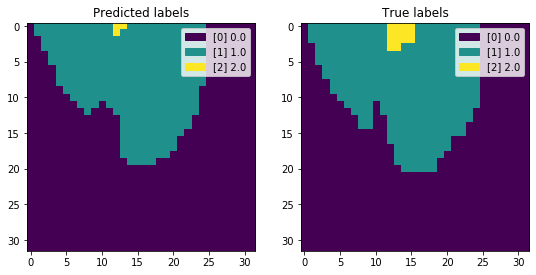

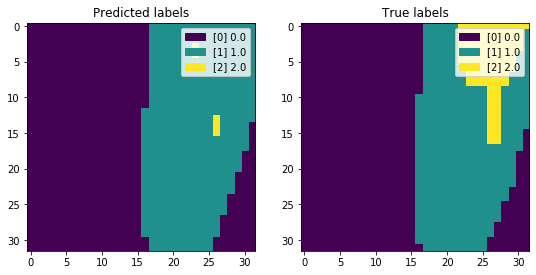

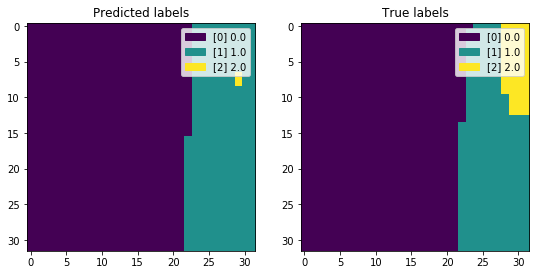

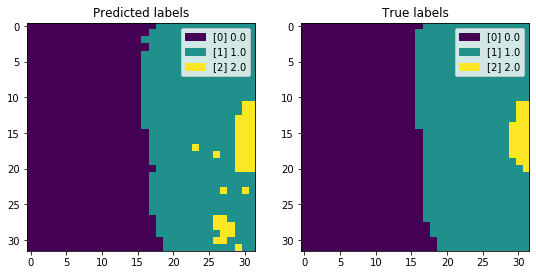

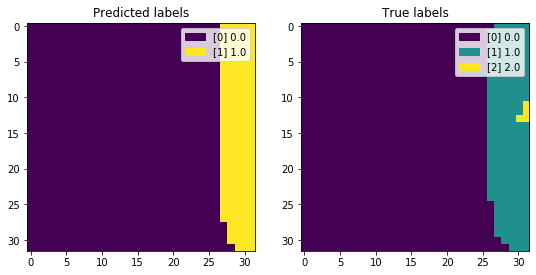

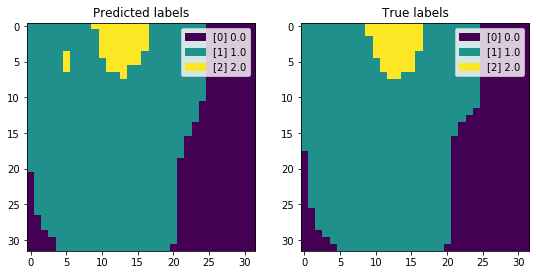

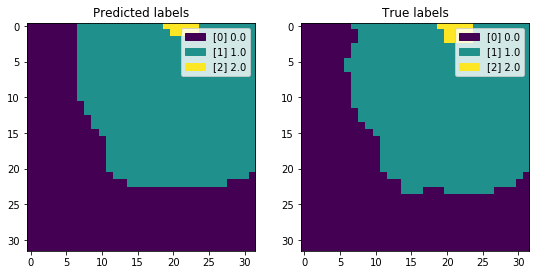

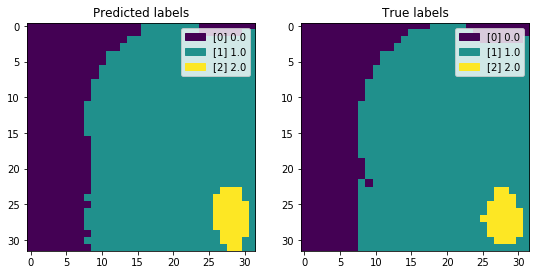

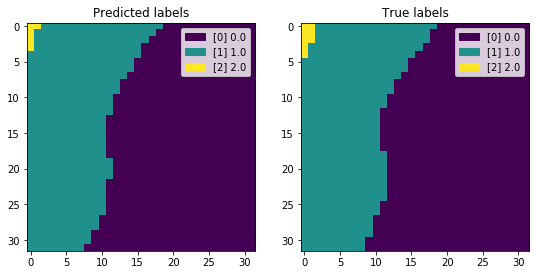

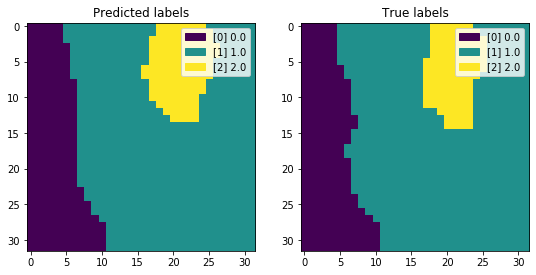

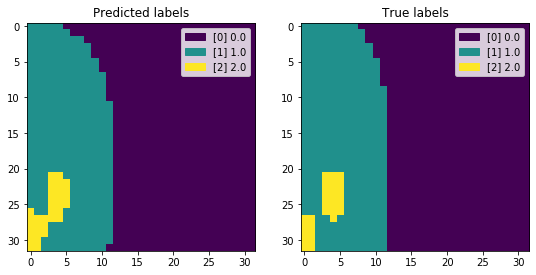

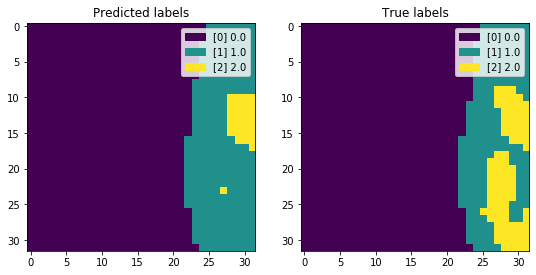

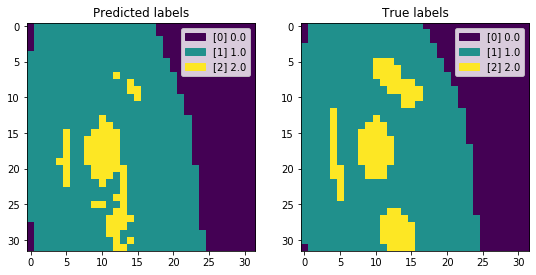

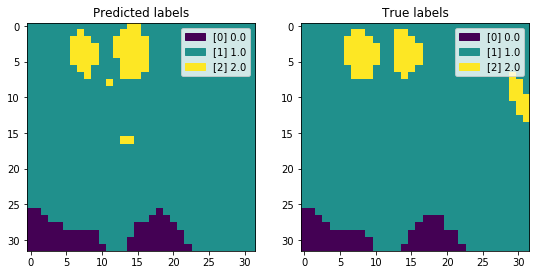

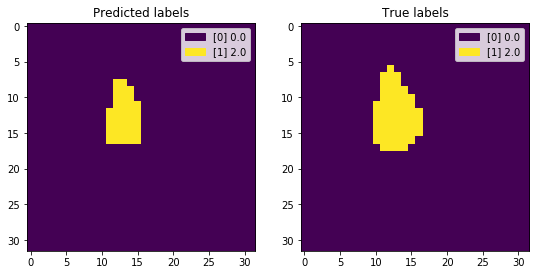

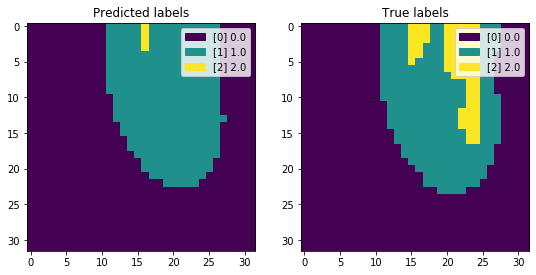

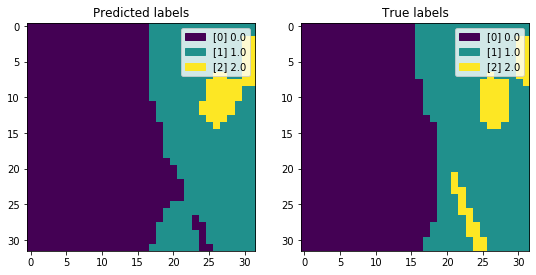

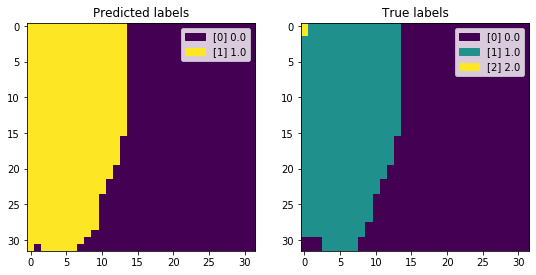

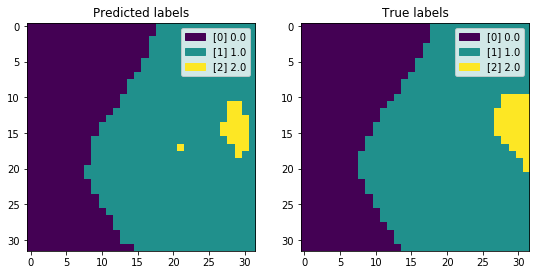

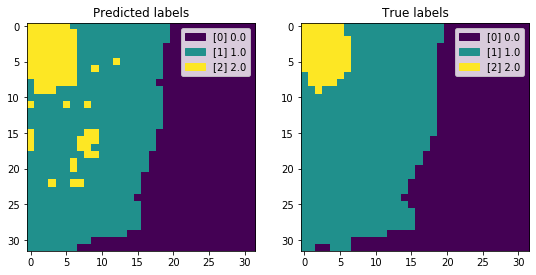

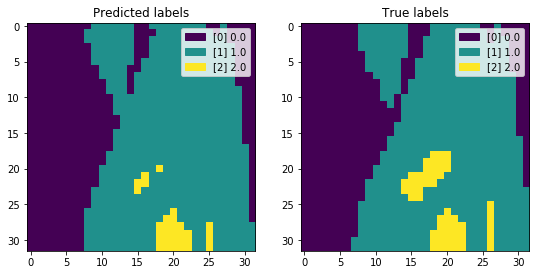

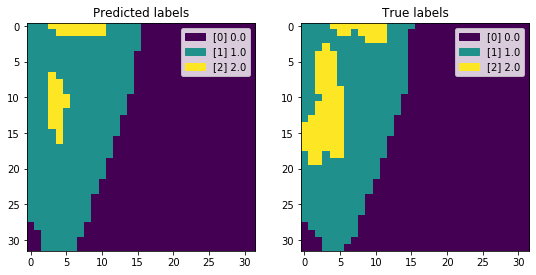

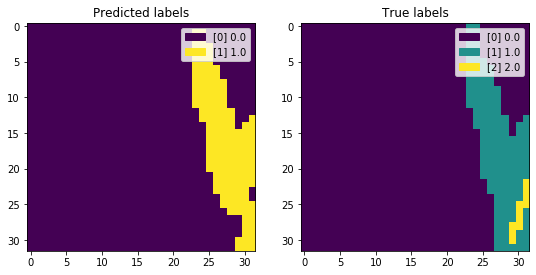

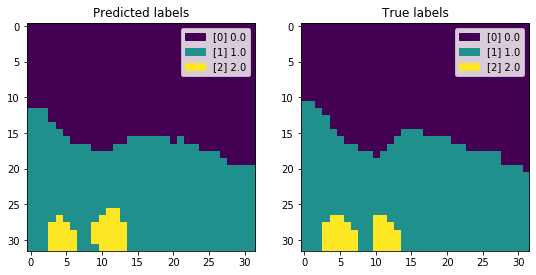

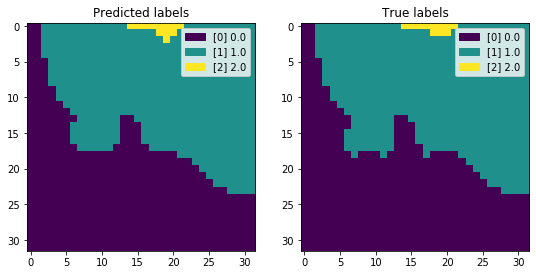

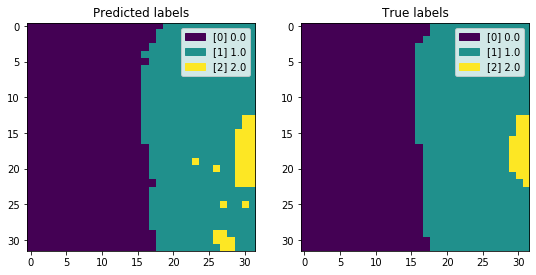

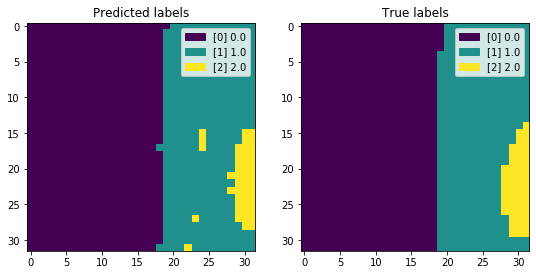

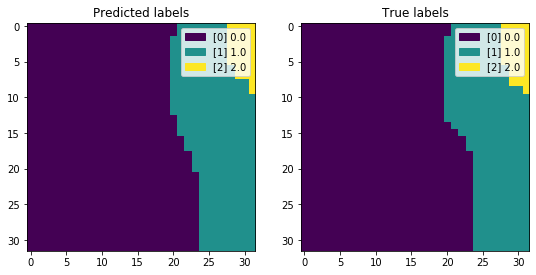

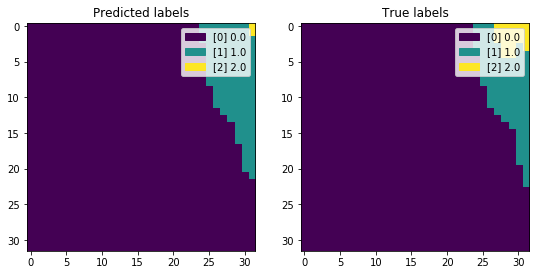

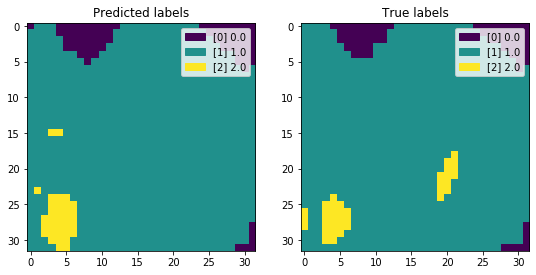

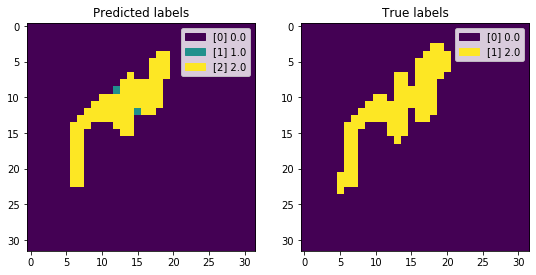

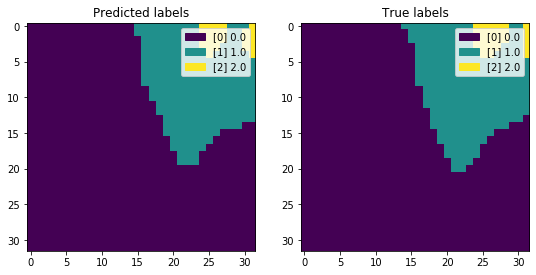

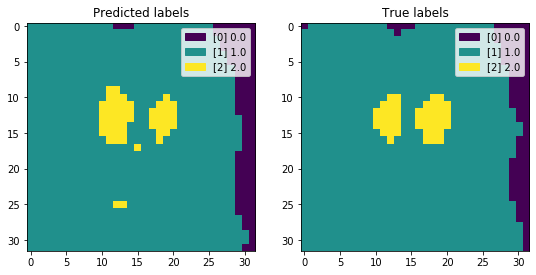

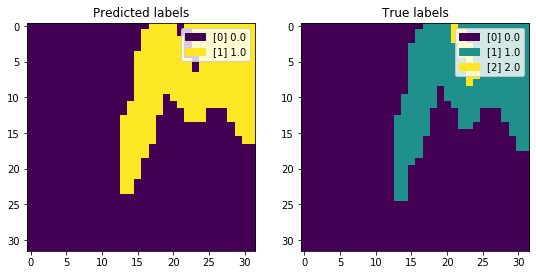

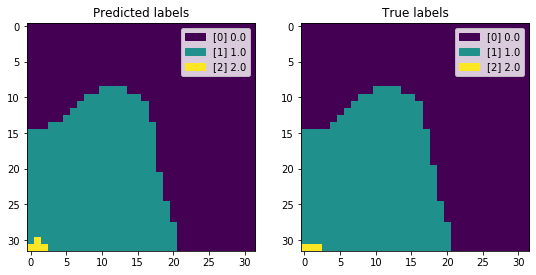

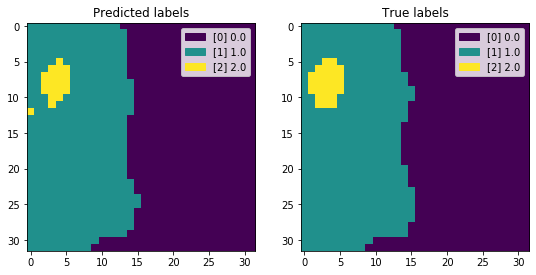

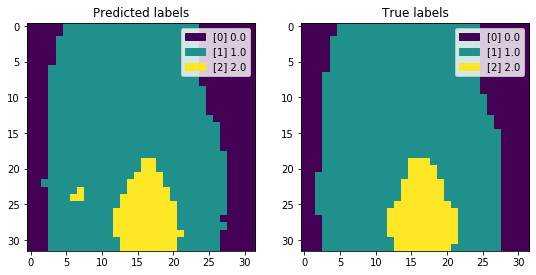

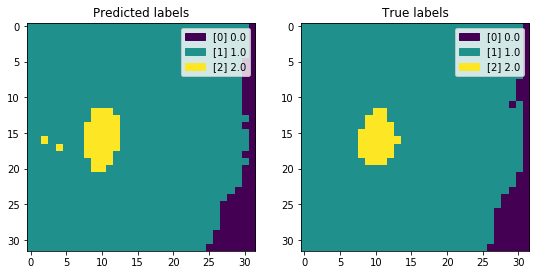

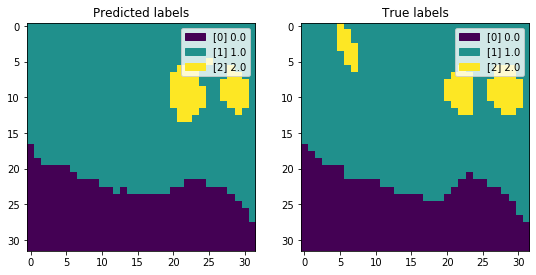

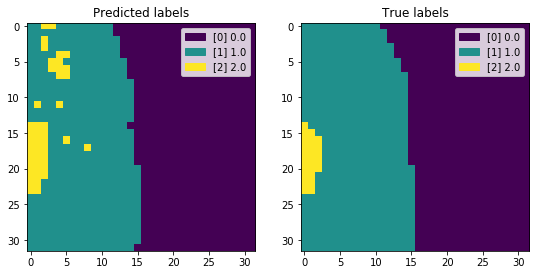

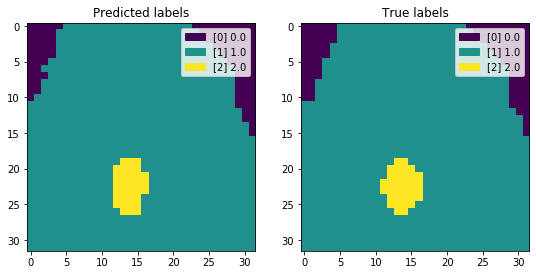

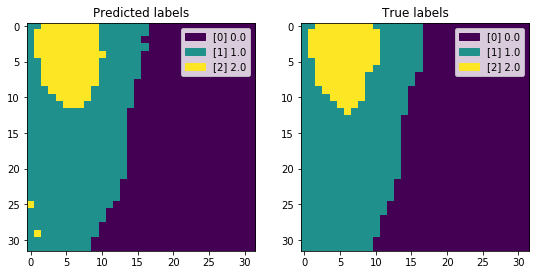

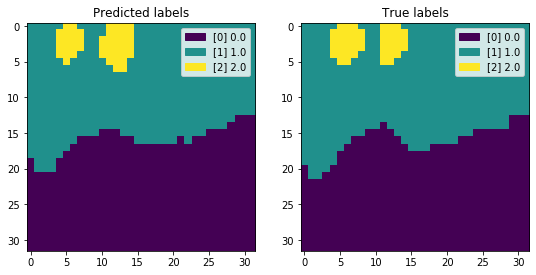

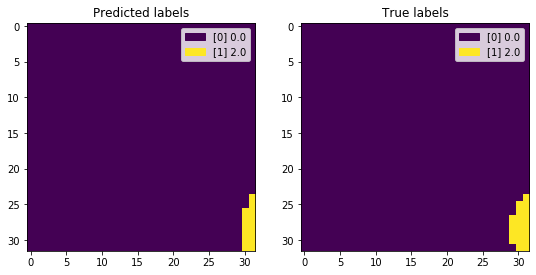

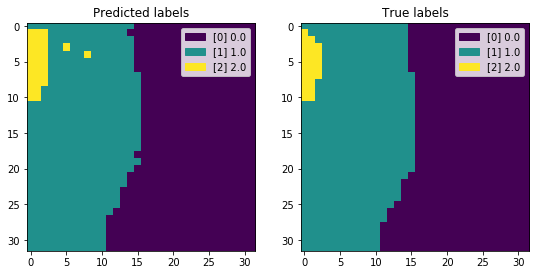

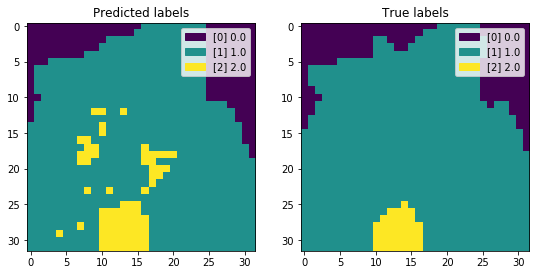

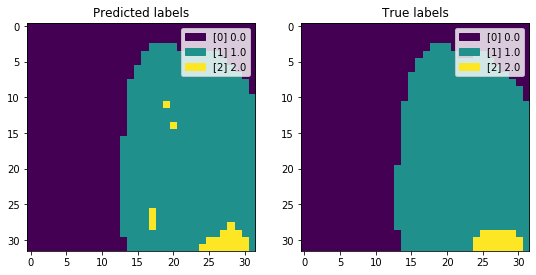

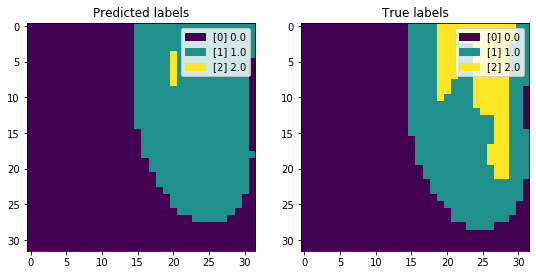

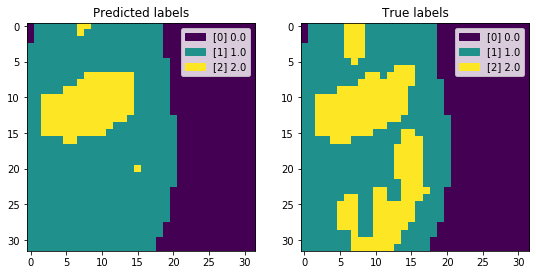

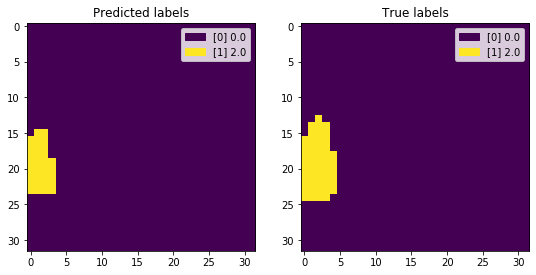

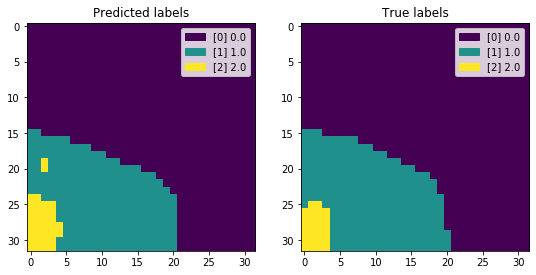

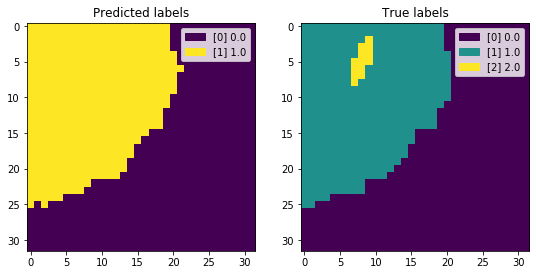

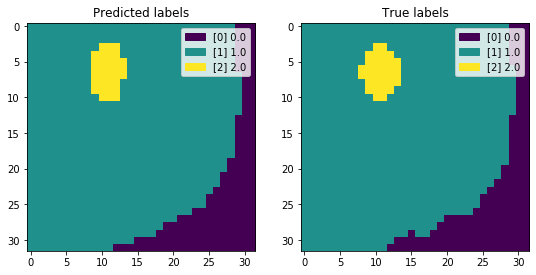

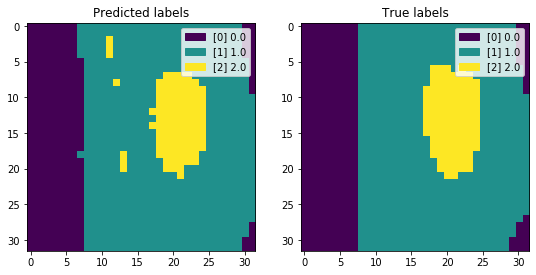

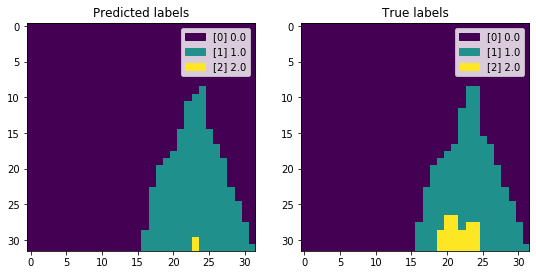

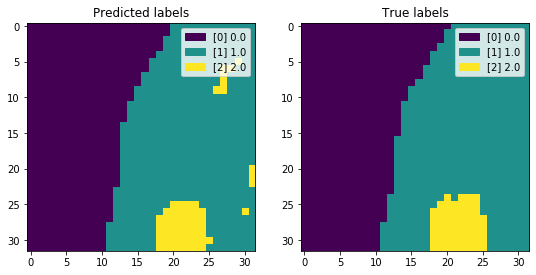

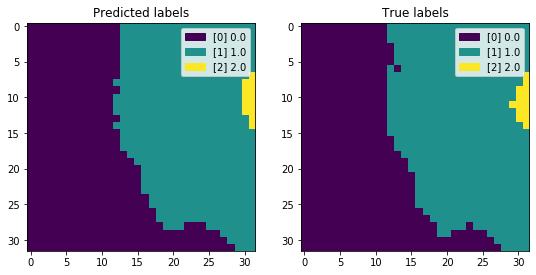

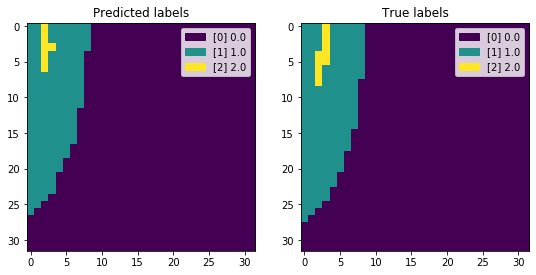

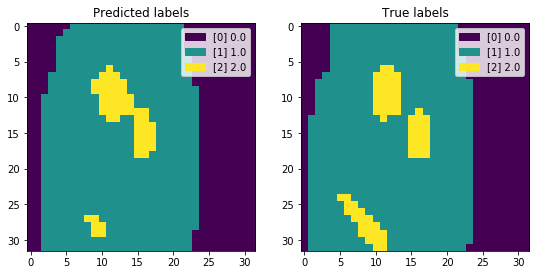

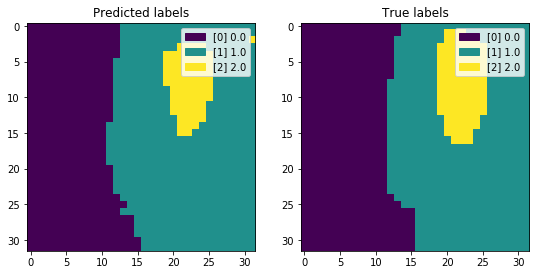

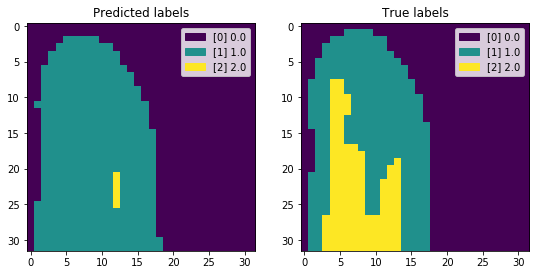

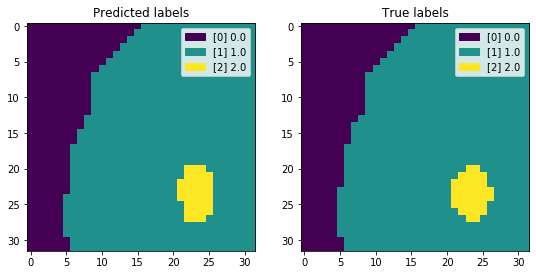

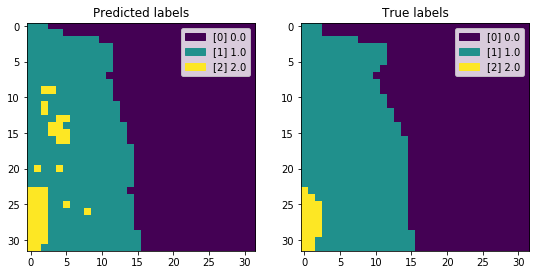

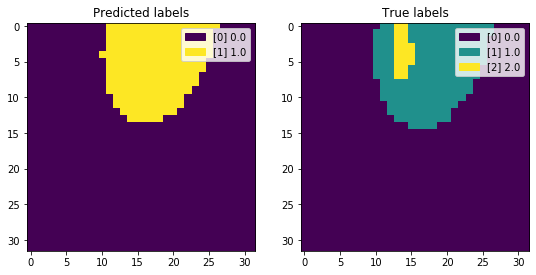

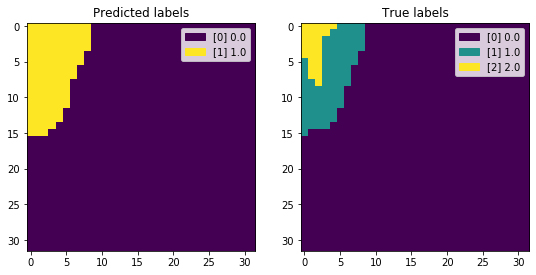

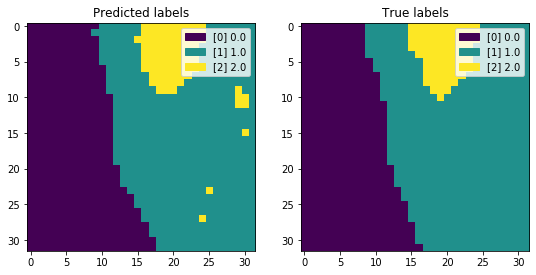

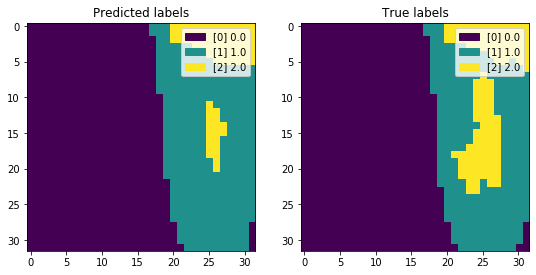

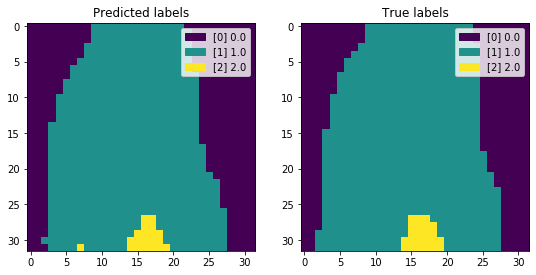

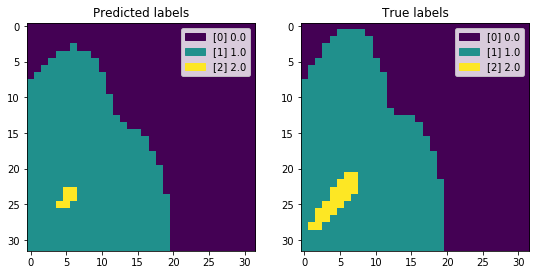

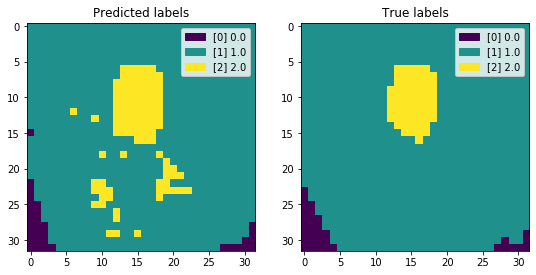

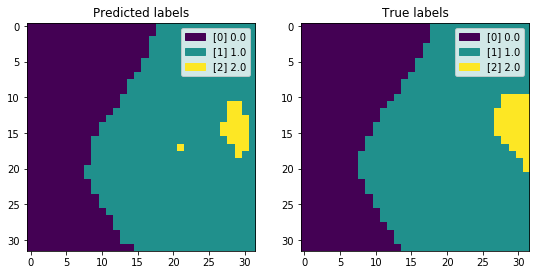

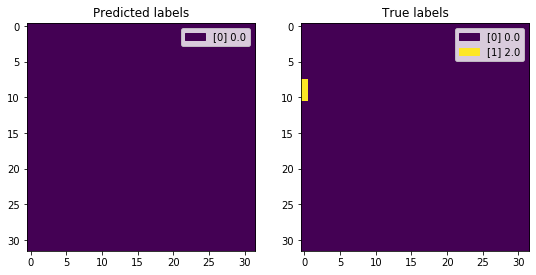

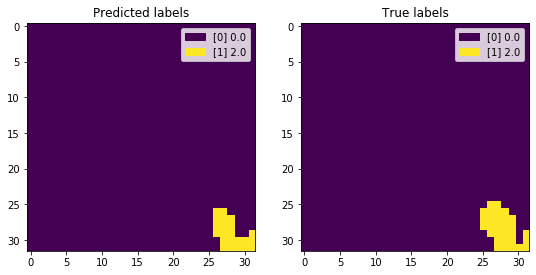

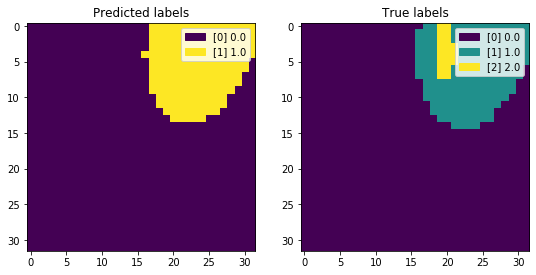

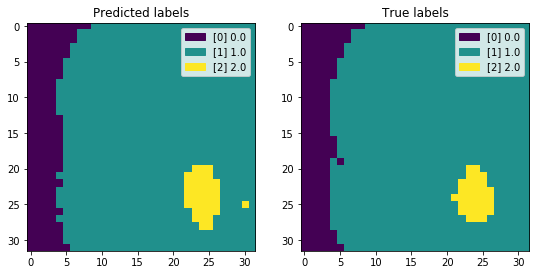

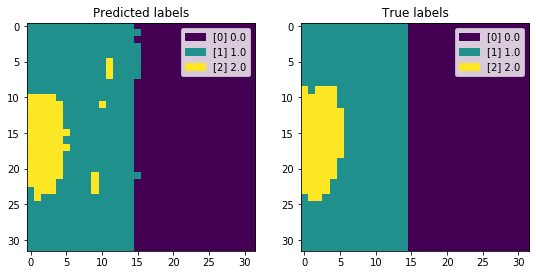

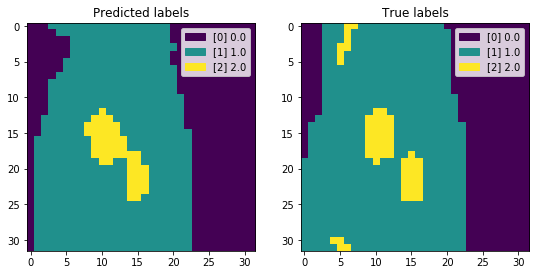

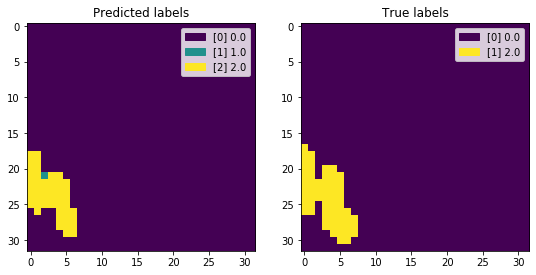

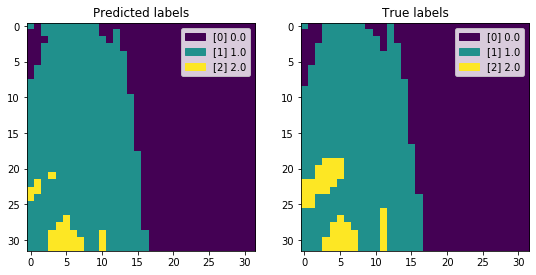

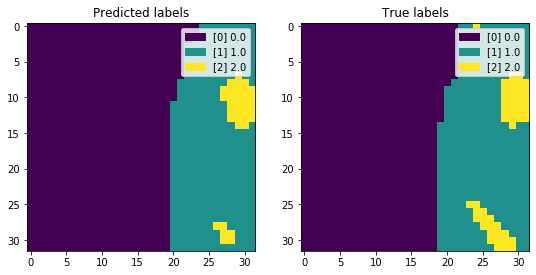

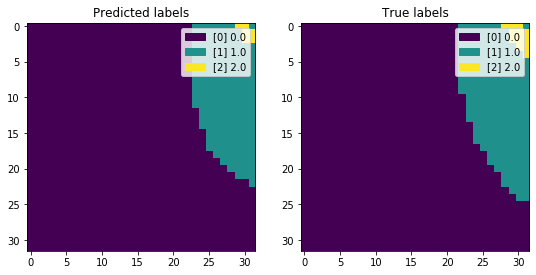

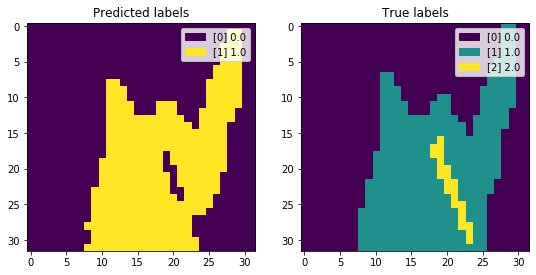

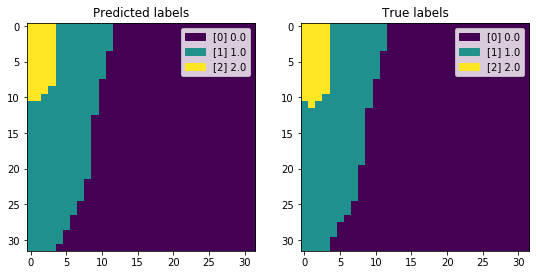

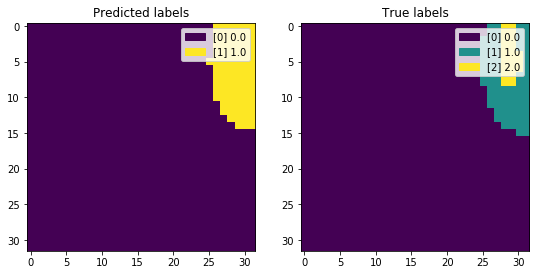

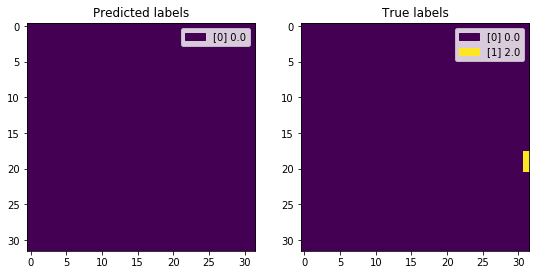

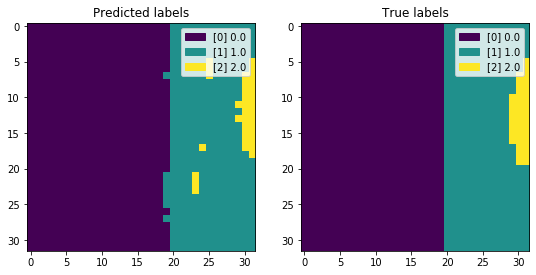

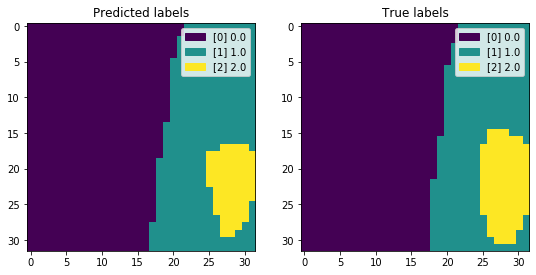

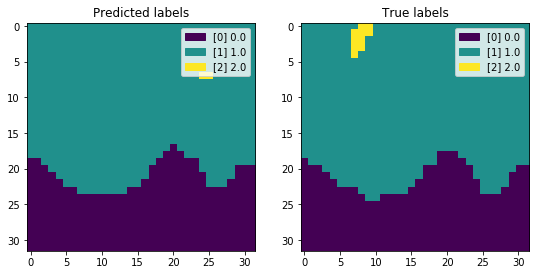

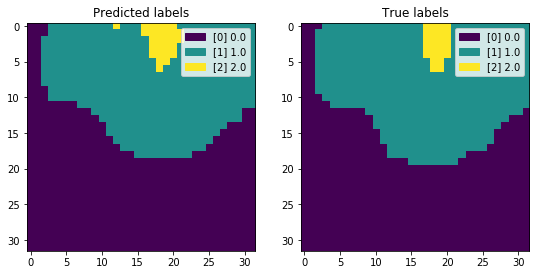

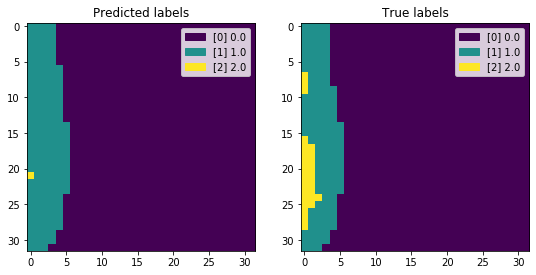

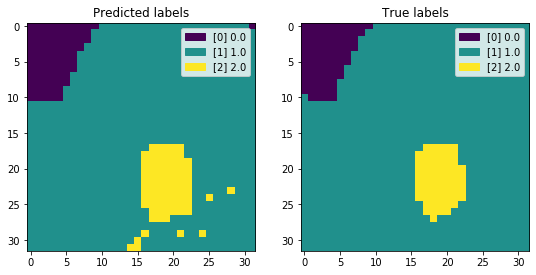

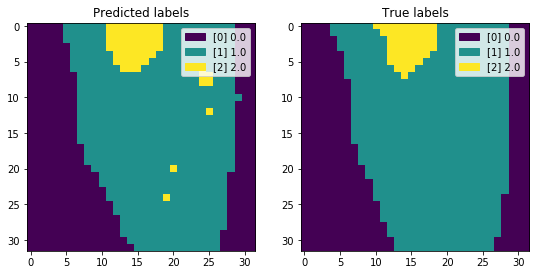

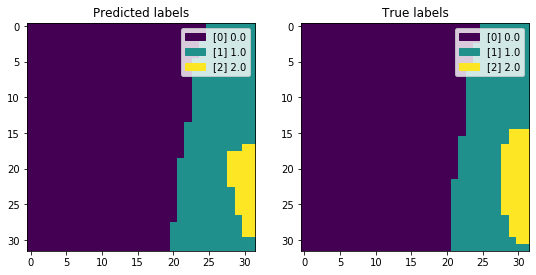

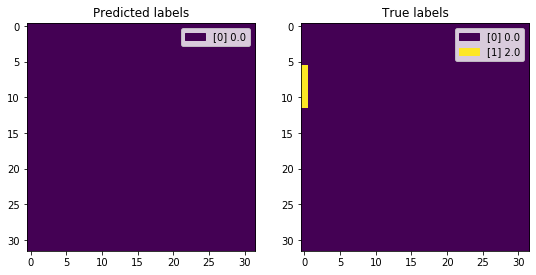

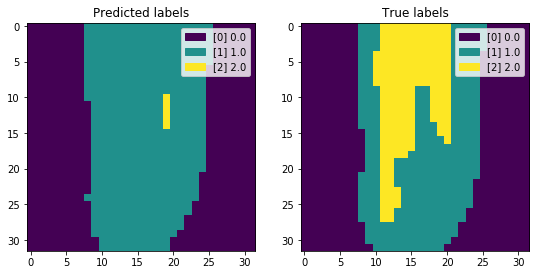

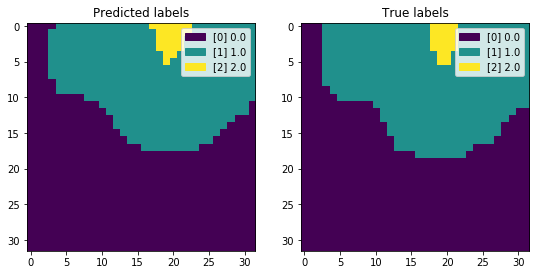

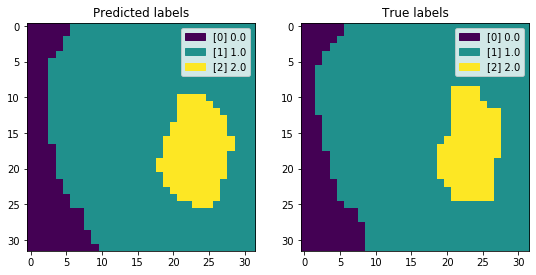

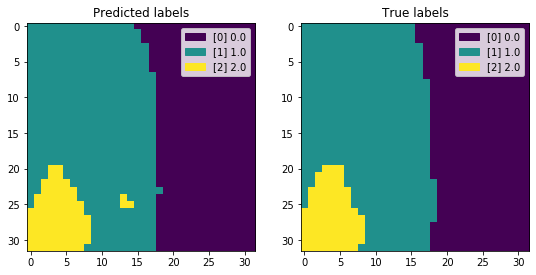

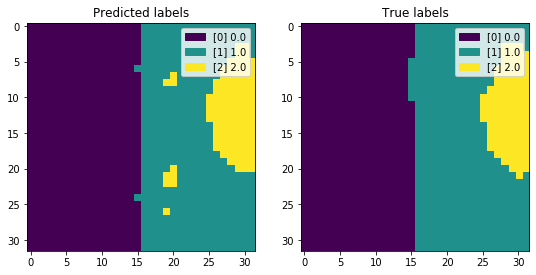

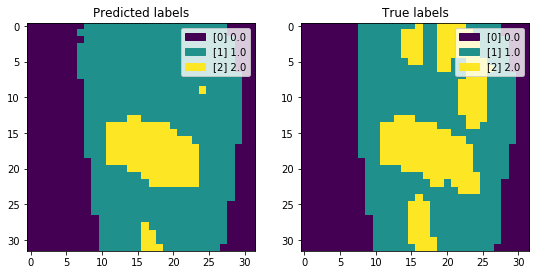

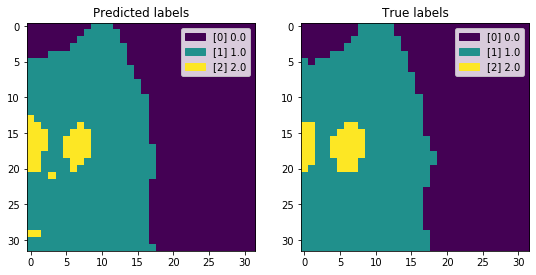

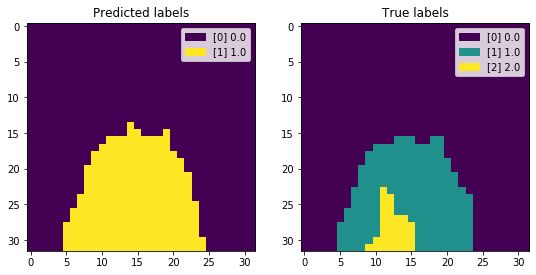

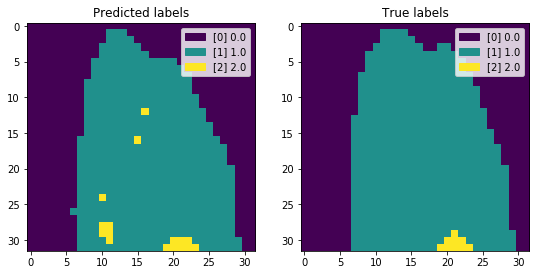

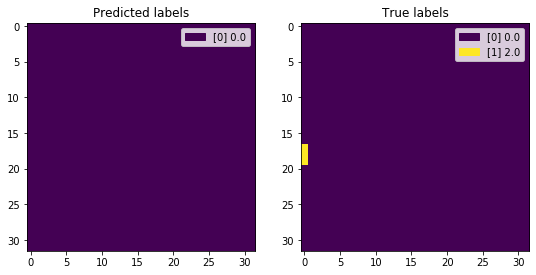

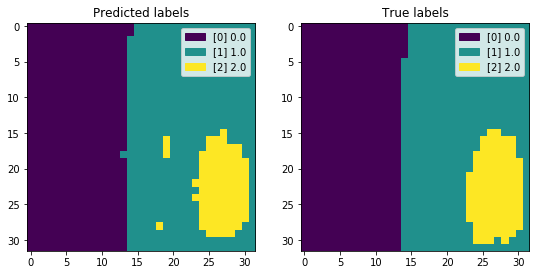

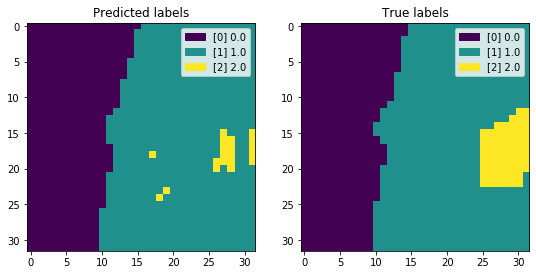

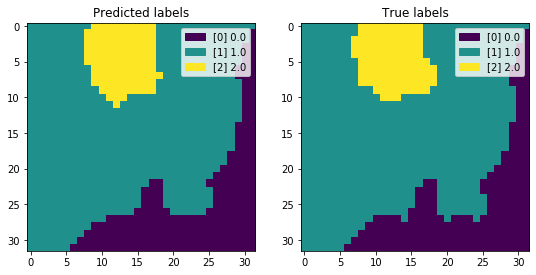

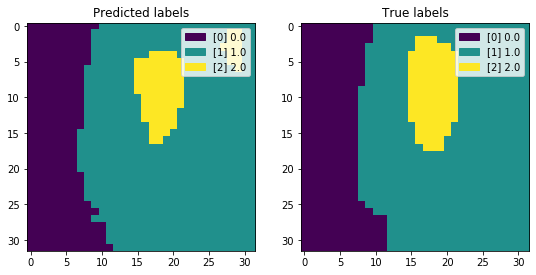

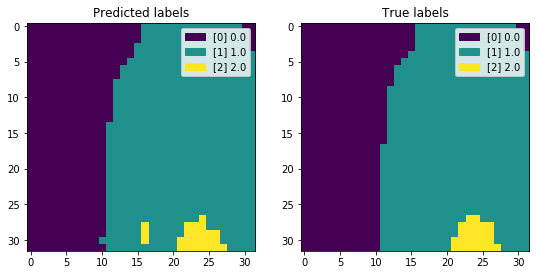

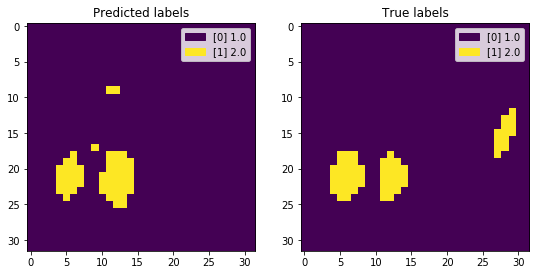

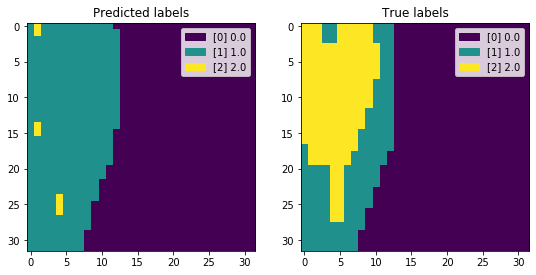

In [11]:
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plt.figure(figsize=(9, 6))
        plt.subplot(121)
        img = plt.imshow(np.squeeze(Y_hat[i]))
        mypackage.Dataset._Dataset__add_legend_to_image(Y_hat[i], img)
        plt.title("Predicted labels")
        plt.subplot(122)
        img = plt.imshow(np.squeeze(Y_test[i]))
        mypackage.Dataset._Dataset__add_legend_to_image(Y_test[i], img)
        plt.title("True labels")

In [119]:
# train = mypackage.StackTransform(X_train_orig, Y_train_orig)
# Y_hat_train = logreg.predict(train.X_stack())
# Y_hat_train = train.Unstack(Y_hat_train, k=1)
# print(f"Fasle positive blobs {mypackage.count_false_positive(Y_hat_train, Y_train)}")

# for i in range(len(Y_train_orig)):
#     if 2 in Y_train_orig[i]:
#         plt.figure(figsize=(9, 6))
#         plt.subplot(121)
#         img = plt.imshow(np.squeeze(Y_hat_train[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_hat_train[i], img)
#         plt.title("Predicted labels")
#         plt.subplot(122)
#         img = plt.imshow(np.squeeze(Y_train_orig[i]))
#         mypackage.Dataset._Dataset__add_legend_to_image(Y_train_orig[i], img)
#         plt.title("True labels")

### Test SpectralUNet on the same data

Start training
Train on 1584 samples, validate on 176 samples
Epoch 1/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.2886 - accuracy: 0.9546
Epoch 00001: val_loss improved from inf to 0.08895, saving model to latest_spectral_unet.hdf5
1584/1584 [==============================] - 100s 63ms/sample - loss: 0.2880 - accuracy: 0.9546 - val_loss: 0.0889 - val_accuracy: 0.9783
Epoch 2/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.1039 - accuracy: 0.9742
Epoch 00002: val_loss improved from 0.08895 to 0.06422, saving model to latest_spectral_unet.hdf5
1584/1584 [==============================] - 95s 60ms/sample - loss: 0.1038 - accuracy: 0.9742 - val_loss: 0.0642 - val_accuracy: 0.9791
Epoch 3/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9756
Epoch 00003: val_loss improved from 0.06422 to 0.06020, saving model to latest_spectral_unet.hdf5
1584/1584 [==============================] - 97s 61ms/sample - loss: 0.0842 - a

Epoch 55/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9862
Epoch 00055: val_loss did not improve from 0.03203
1584/1584 [==============================] - 88s 56ms/sample - loss: 0.0372 - accuracy: 0.9862 - val_loss: 0.0327 - val_accuracy: 0.9874
Epoch 56/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.0371 - accuracy: 0.9860
Epoch 00056: val_loss did not improve from 0.03203
1584/1584 [==============================] - 90s 57ms/sample - loss: 0.0371 - accuracy: 0.9860 - val_loss: 0.0342 - val_accuracy: 0.9862
Epoch 57/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9863
Epoch 00057: val_loss improved from 0.03203 to 0.03084, saving model to latest_spectral_unet.hdf5
1584/1584 [==============================] - 88s 55ms/sample - loss: 0.0368 - accuracy: 0.9862 - val_loss: 0.0308 - val_accuracy: 0.9880
Epoch 58/60
1580/1584 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 

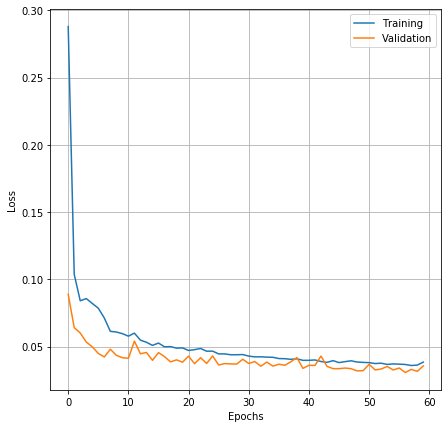

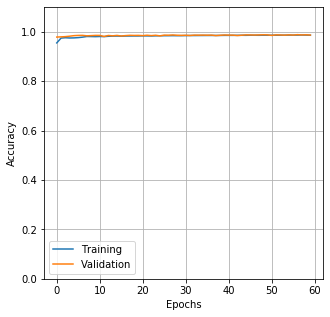

Predicting for train data
Elapsed time: 23.2072 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      1.00   1453547
           1       0.97      0.97      0.97    325701
           2       0.89      0.83      0.86     22992

    accuracy                           0.99   1802240
   macro avg       0.95      0.93      0.94   1802240
weighted avg       0.99      0.99      0.99   1802240



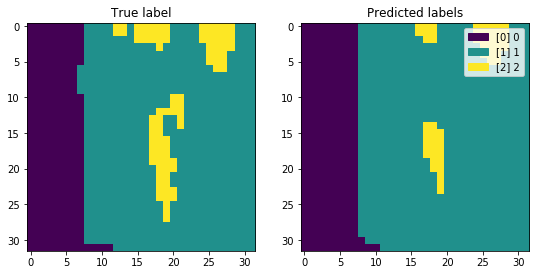

Predicting for test data
Elapsed time: 10.0316 seconds
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    631508
           1       0.95      0.97      0.96    136330
           2       0.74      0.53      0.62     10402

    accuracy                           0.98    778240
   macro avg       0.89      0.83      0.86    778240
weighted avg       0.98      0.98      0.98    778240



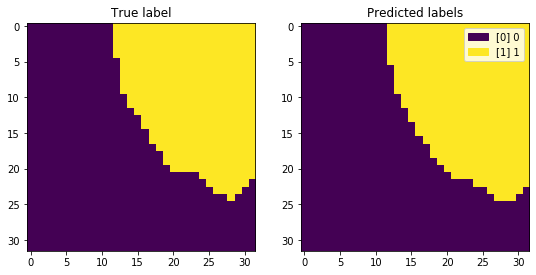

Elapsed time: 11.1483 seconds


In [5]:
spectral_unet = mypackage.SpectralUNet(X_train, Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
spectral_unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
timer.stop()

# spectral_unet.summary()
spectral_unet.plot_training_results()
print("Predicting for train data")
spectral_unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = spectral_unet.predict(X_test, Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")


### Test 2D UNet on the same data

Start training
Elapsed time: 272.8755 seconds


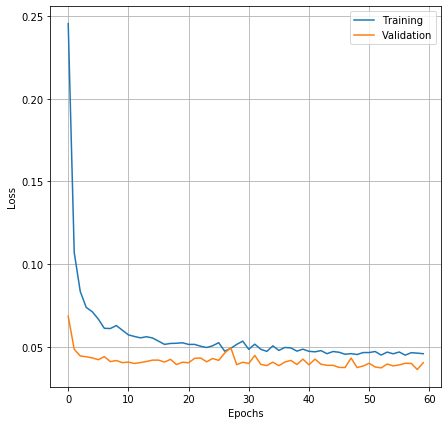

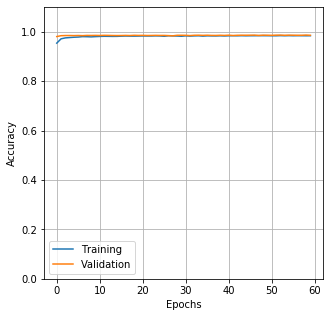

Predicting for train data
Elapsed time: 0.8783 seconds
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   1453547
           1       0.96      0.97      0.96    325701
           2       0.84      0.66      0.74     22992

    accuracy                           0.99   1802240
   macro avg       0.93      0.87      0.90   1802240
weighted avg       0.99      0.99      0.99   1802240



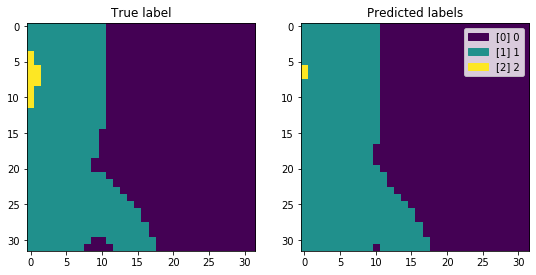

Predicting for test data
Elapsed time: 0.5112 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    631508
           1       0.94      0.97      0.96    136330
           2       0.74      0.47      0.58     10402

    accuracy                           0.98    778240
   macro avg       0.89      0.81      0.84    778240
weighted avg       0.98      0.98      0.98    778240



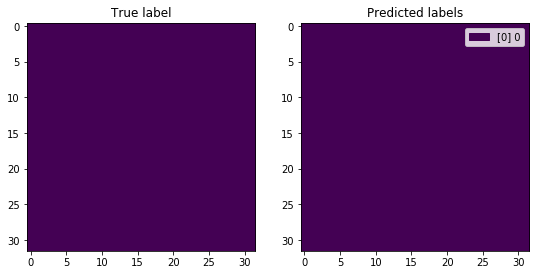

Elapsed time: 1.6761 seconds
Number of layers in the base model:  49


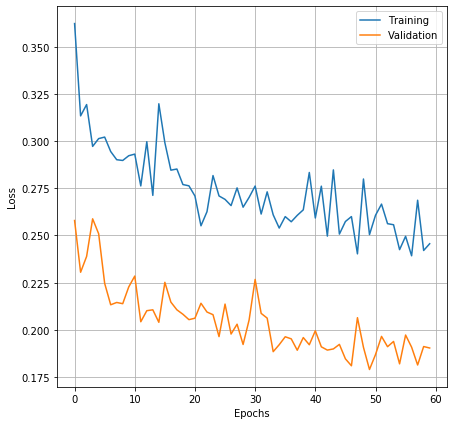

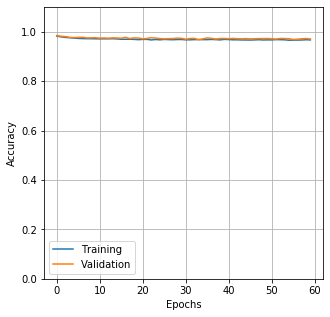

Predicting for test data after Dice_Loss focus on contaminants
Elapsed time: 0.4858 seconds
              precision    recall  f1-score   support

           0       0.97      1.00      0.99    631508
           1       0.97      0.87      0.91    136330
           2       0.76      0.54      0.63     10402

    accuracy                           0.97    778240
   macro avg       0.90      0.80      0.85    778240
weighted avg       0.97      0.97      0.97    778240



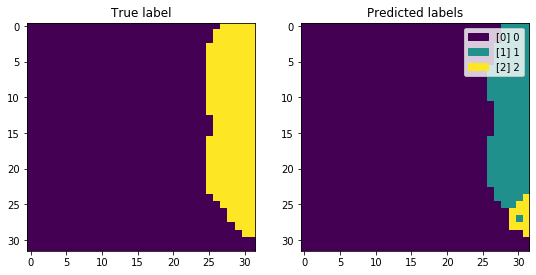

In [6]:
# I would like to use as input these channels
# 7: 953nm, 40: 1072, 68: 1173nm, 138: 1426nm, -1: 1674nm -> 1173nm, 1426nm, 1674nm match to the expected based on labratory measurements
channels_used = [7, 40, 68, 138, -1]
unet = mypackage.UNet(X_train[..., channels_used], Y_train, batchnorm=True, dropout=0.5)
print("Start training")
timer.start()
unet.train(batch_size=5, epochs=60, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min', verbose=0)
timer.stop()

# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(X_train[..., channels_used], Y_labels=Y_train)
print("Predicting for test data")
timer.start()
y_pred_test = unet.predict(X_test[..., channels_used], Y_labels=Y_test);
timer.stop()
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

tl = lambda y_true, y_pred: mypackage.lf.tversky_loss(y_true, y_pred, only_contaminant=True)
unet.retrain(X_train[..., channels_used], Y_train, batch_size=20, epochs=60, loss=tl, validation_split=0.1, verbose=0)
unet.plot_training_results()
print("Predicting for test data after Dice_Loss focus on contaminants")
y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
print(f"Fasle positive blobs {mypackage.count_false_positive(y_pred_test, Y_test)}")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



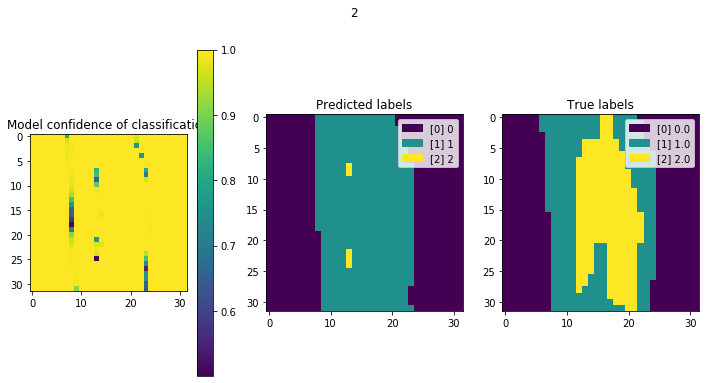

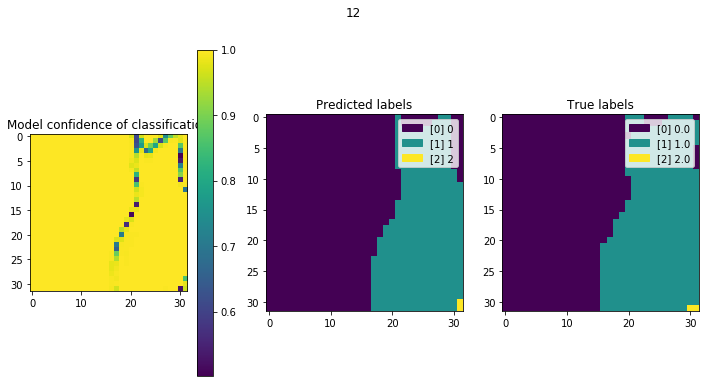

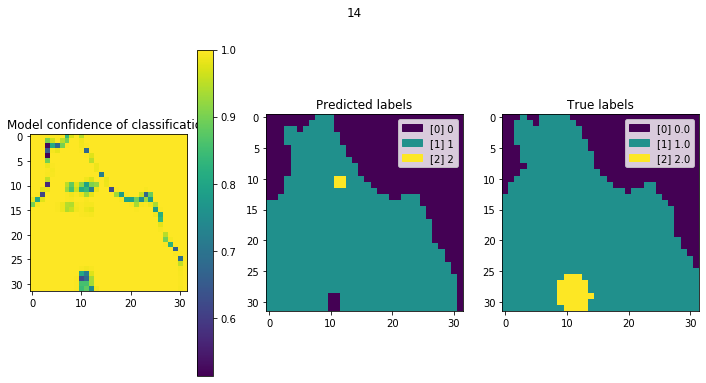

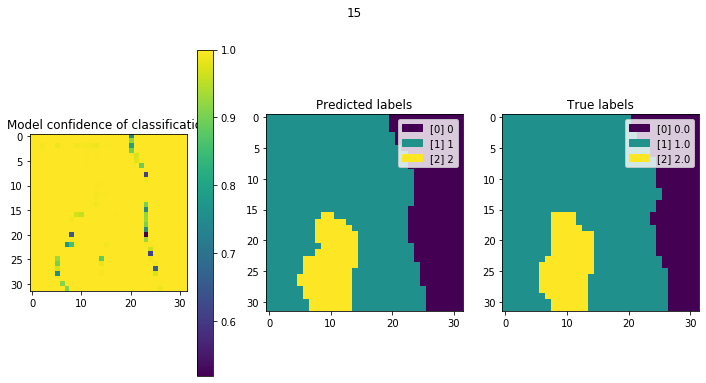

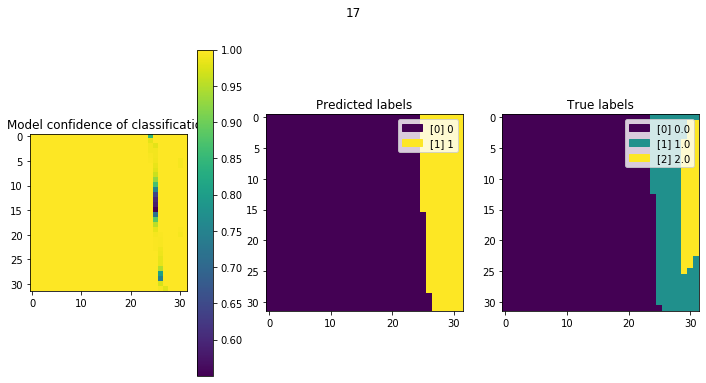

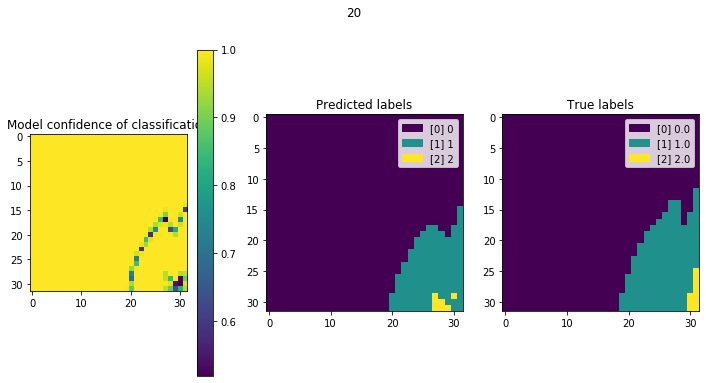

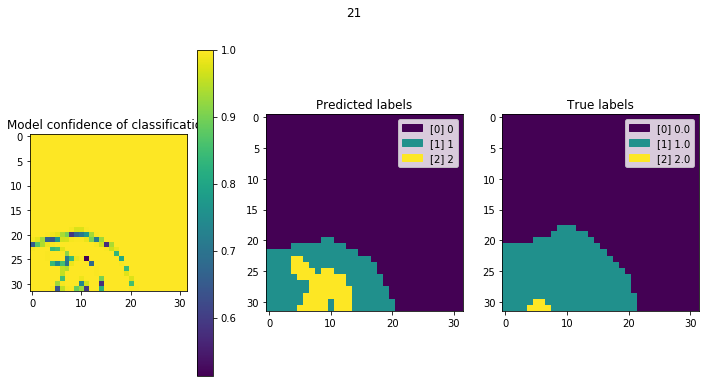

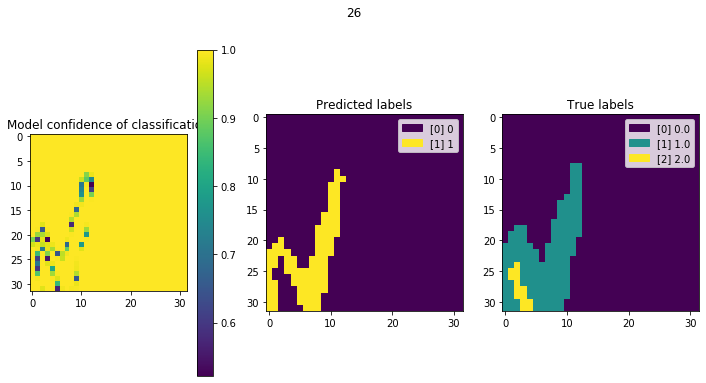

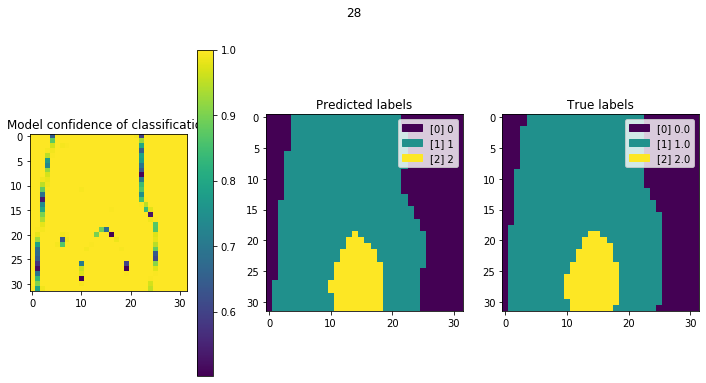

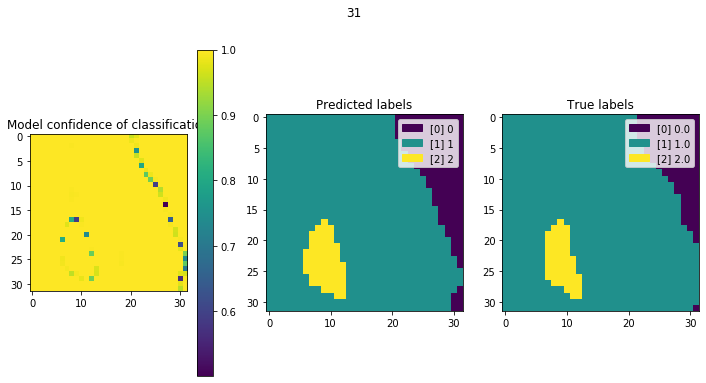

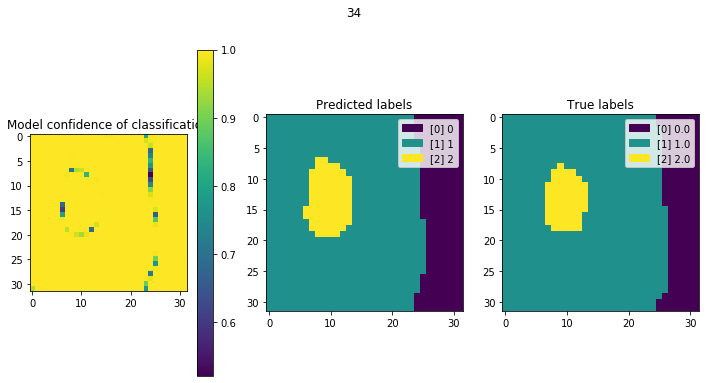

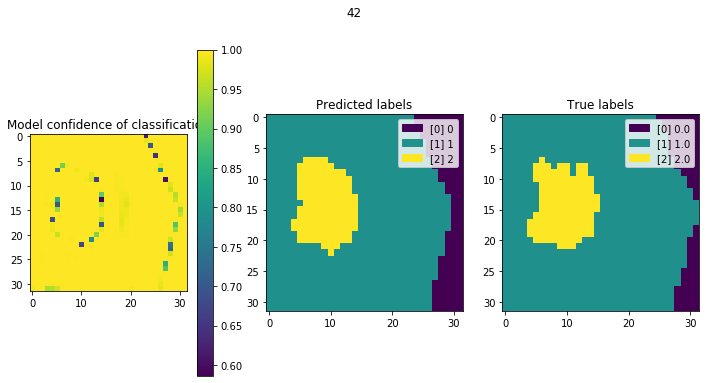

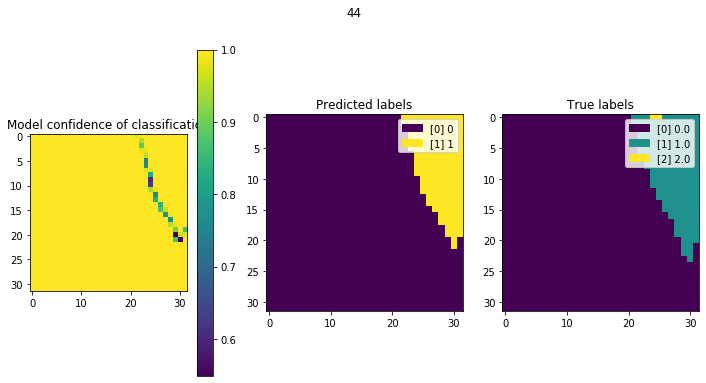

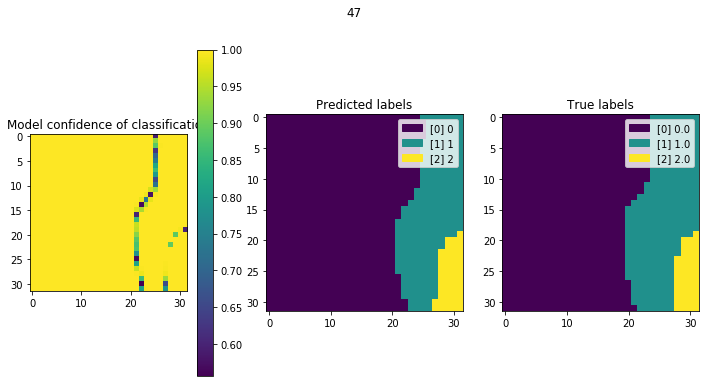

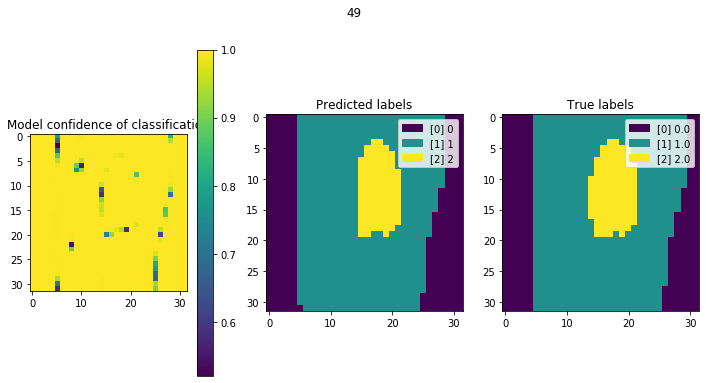

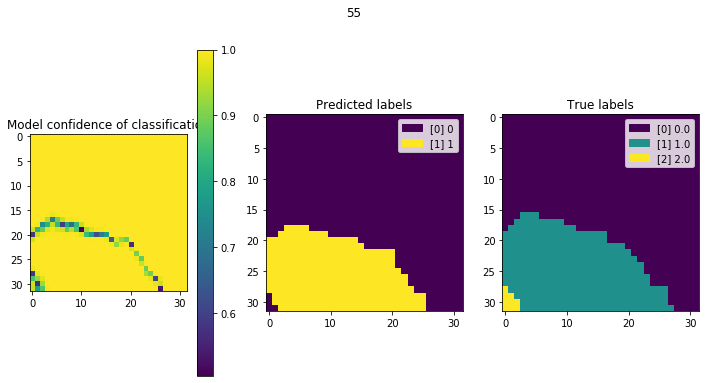

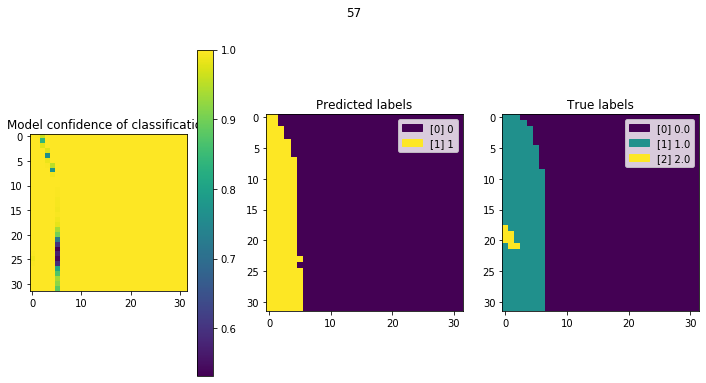

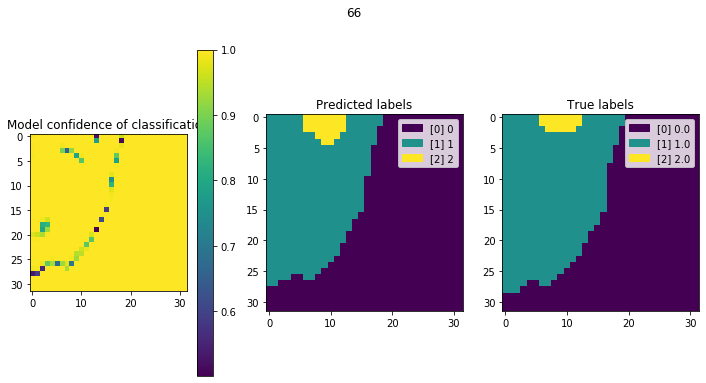

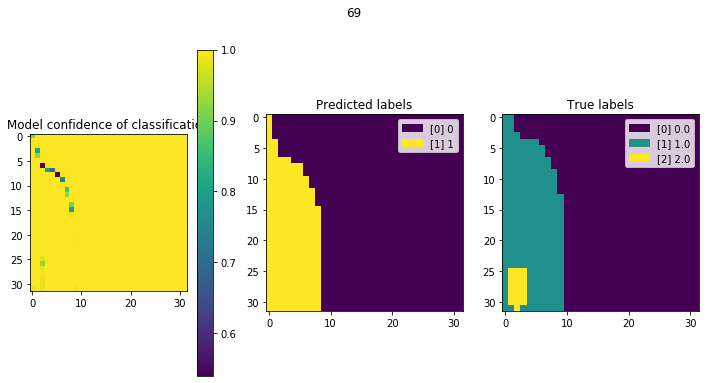

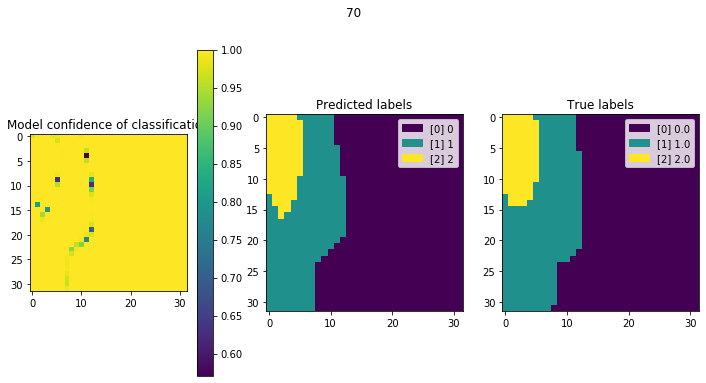

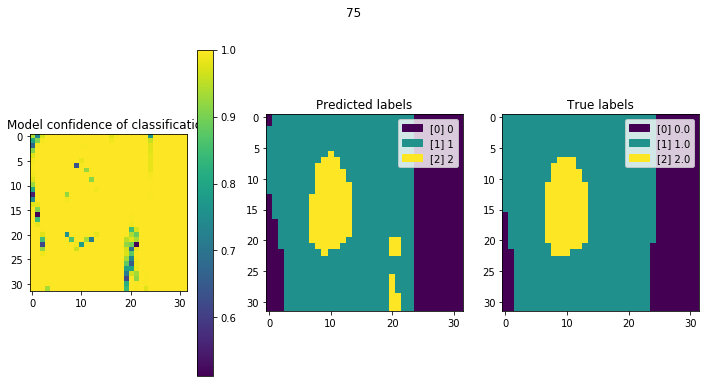

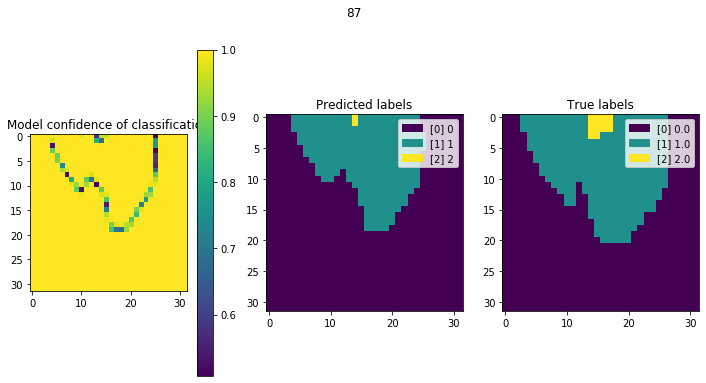

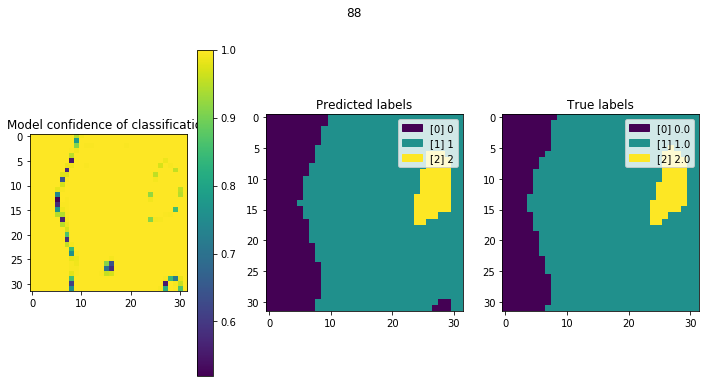

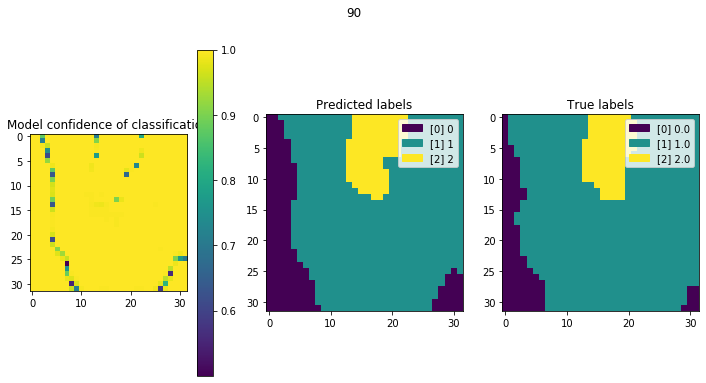

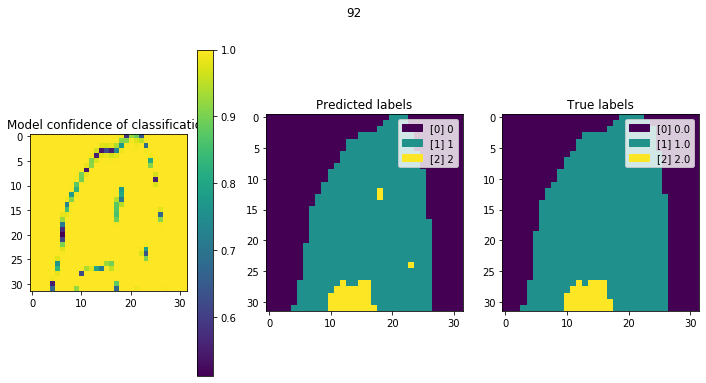

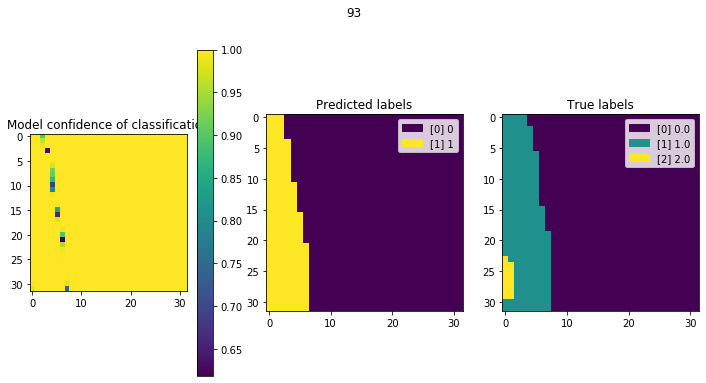

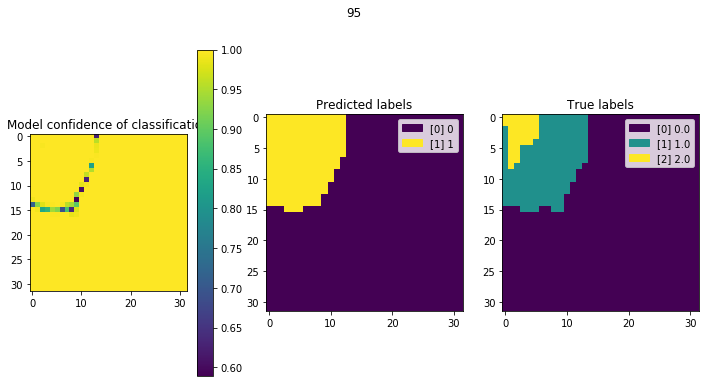

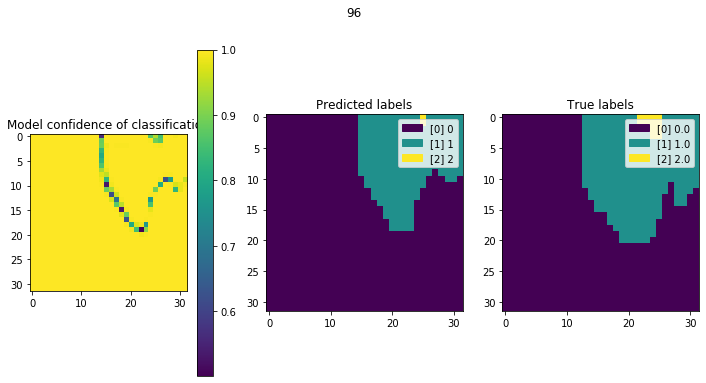

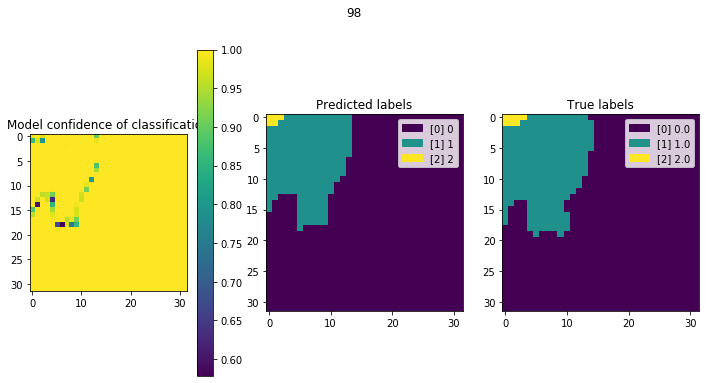

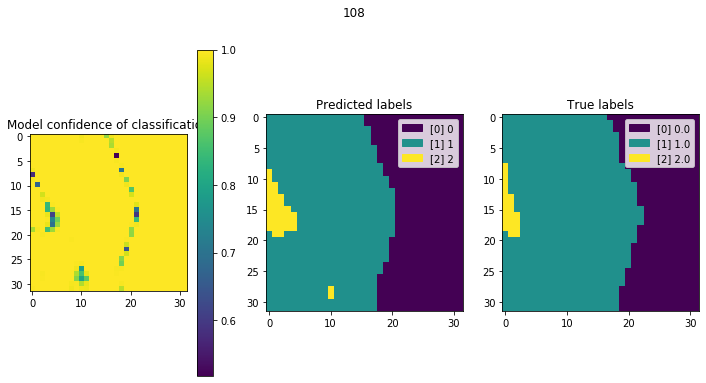

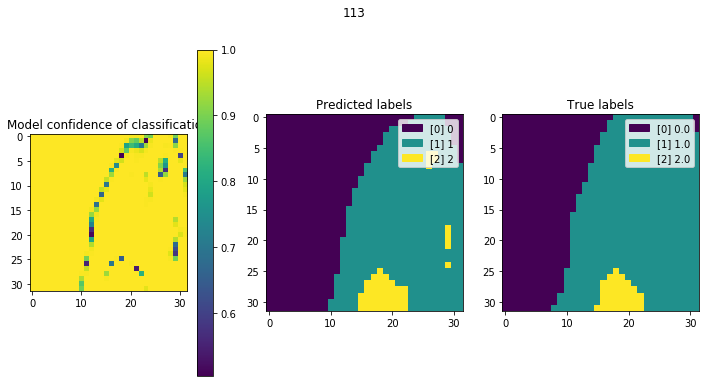

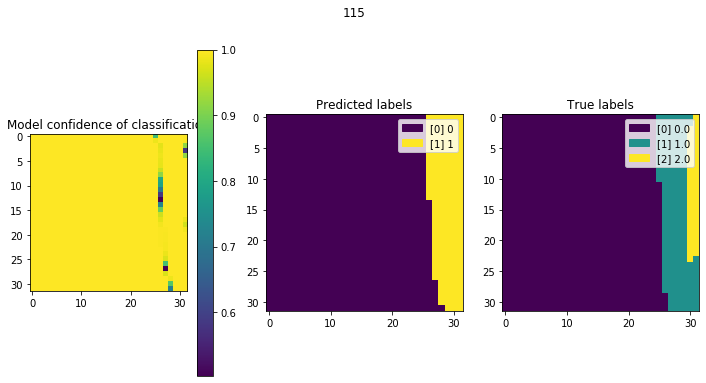

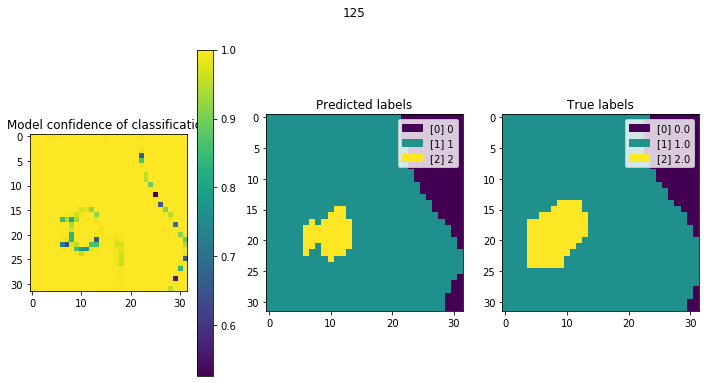

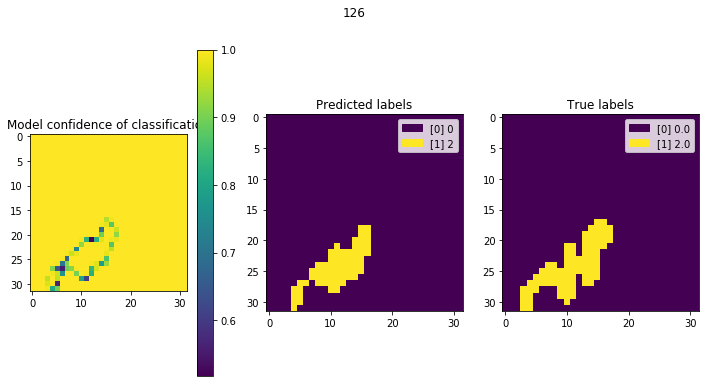

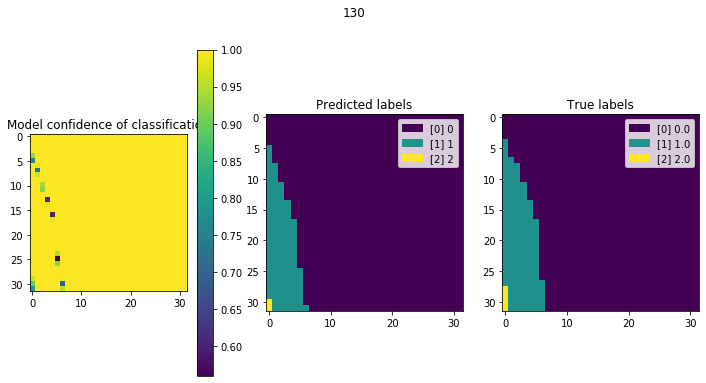

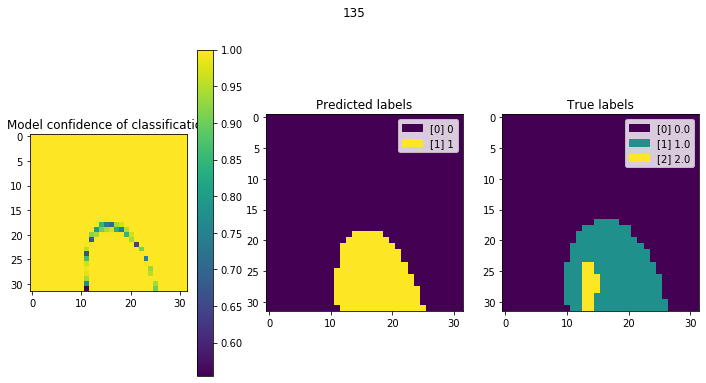

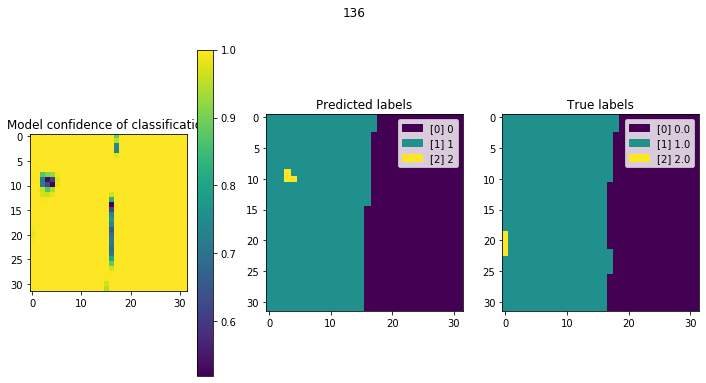

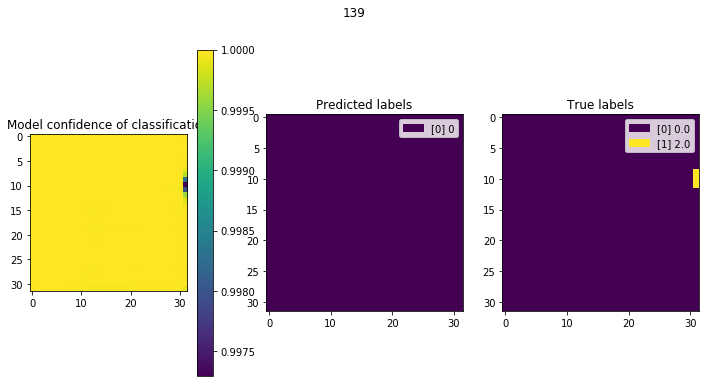

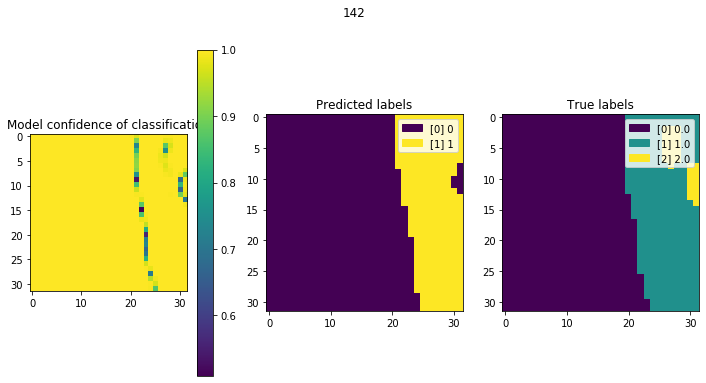

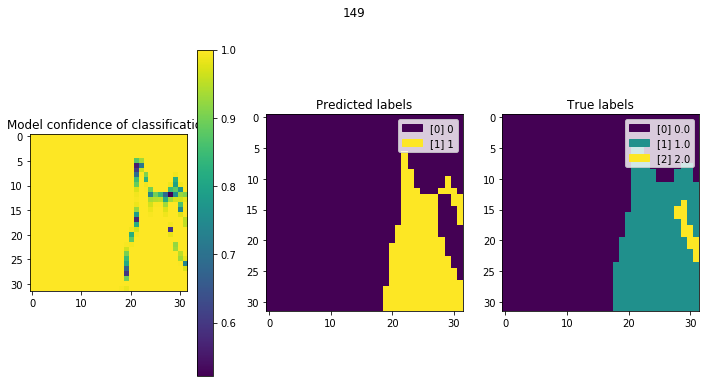

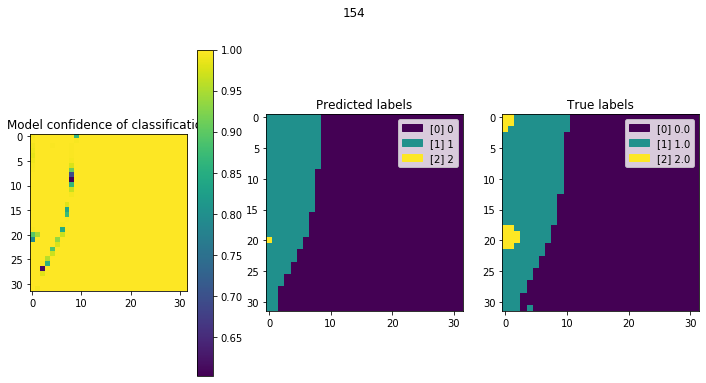

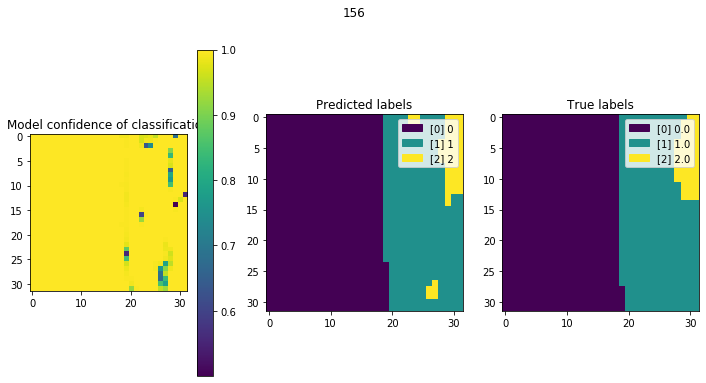

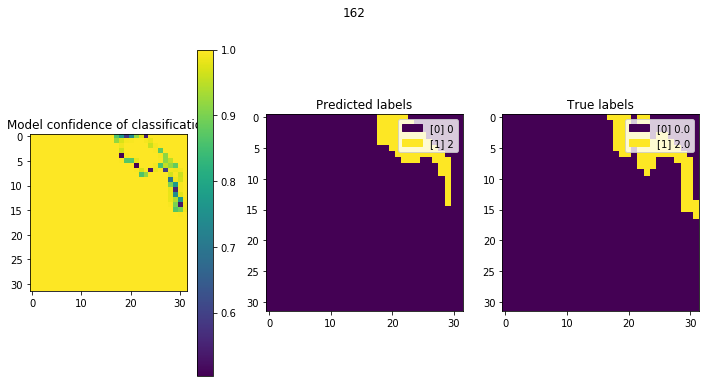

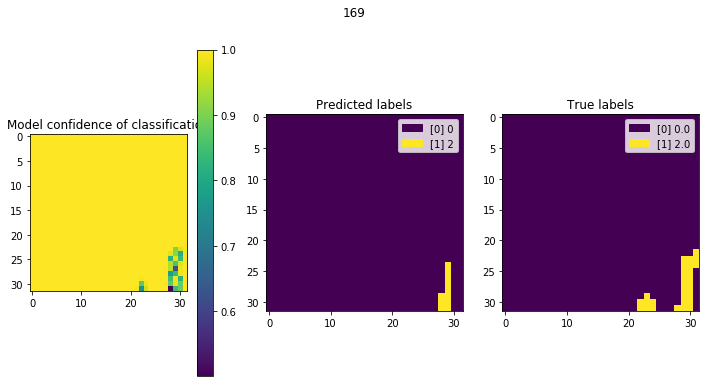

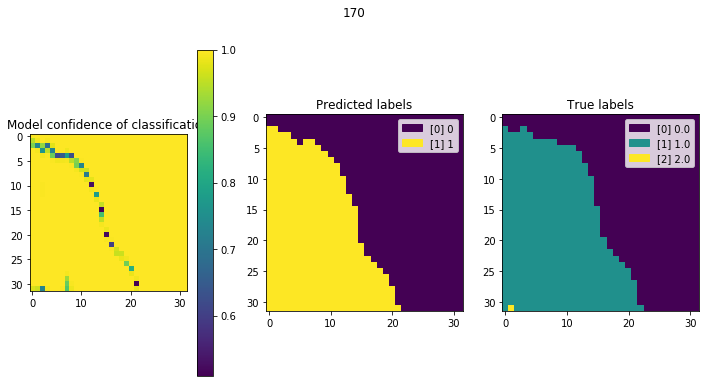

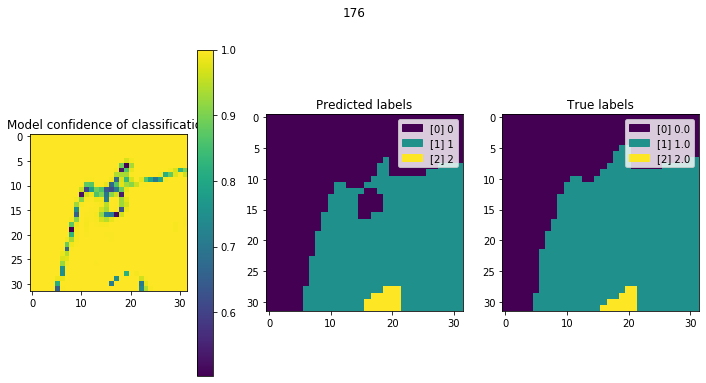

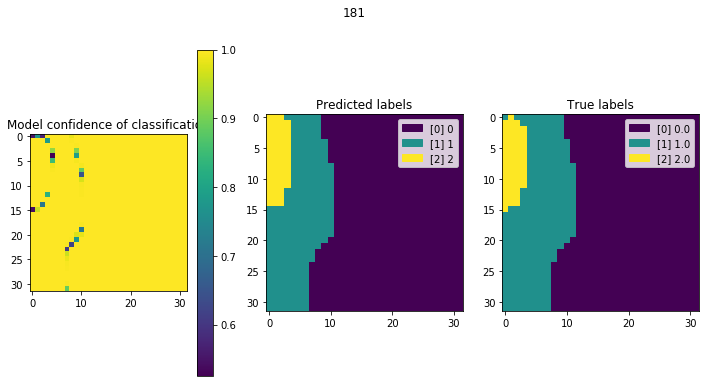

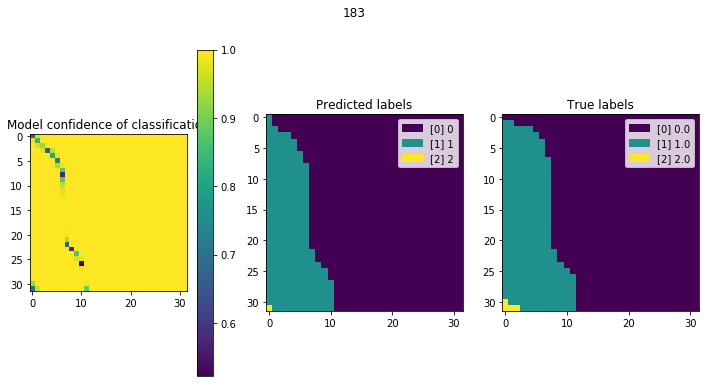

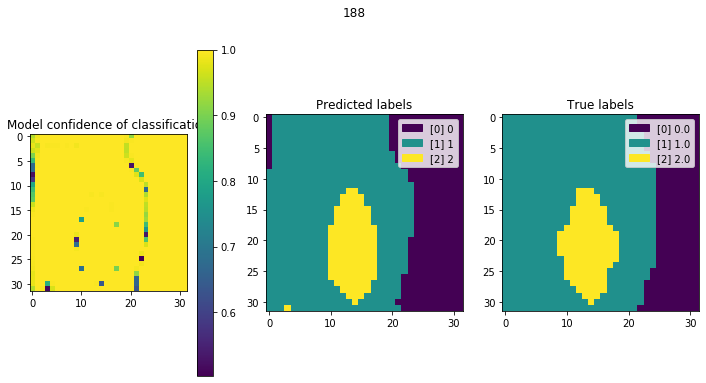

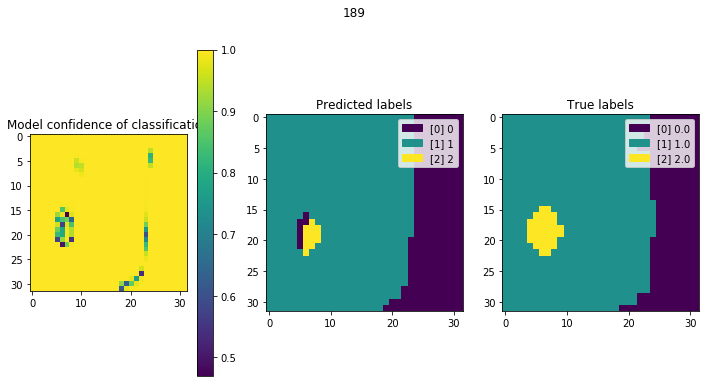

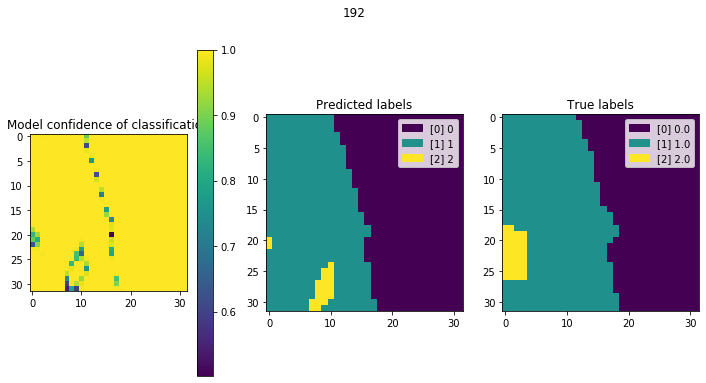

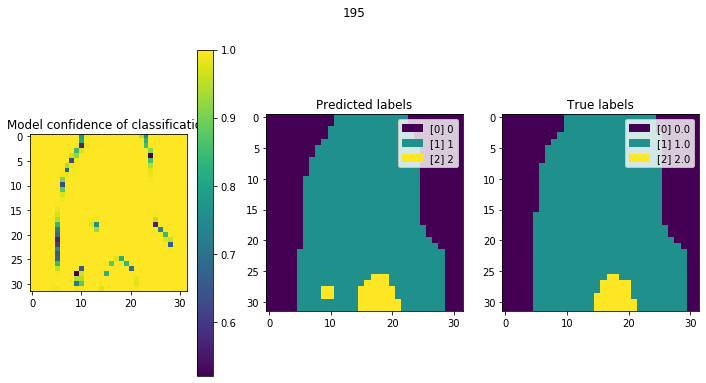

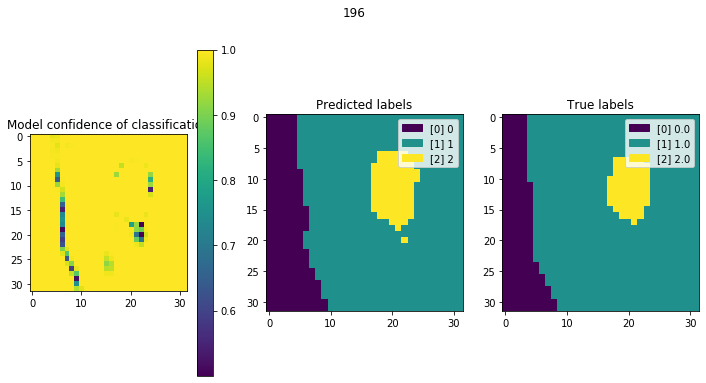

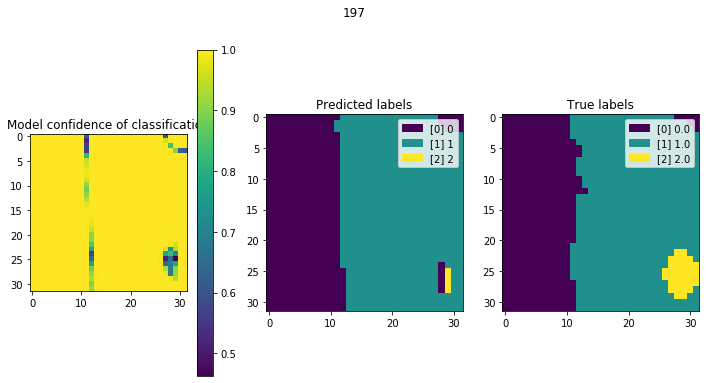

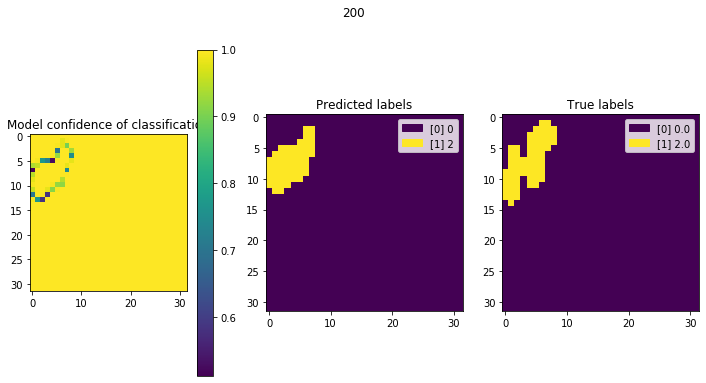

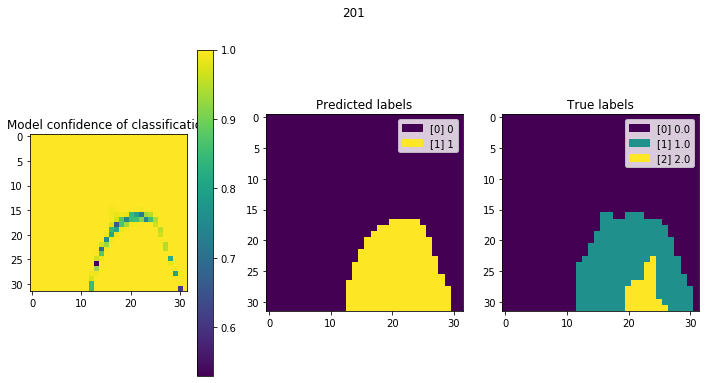

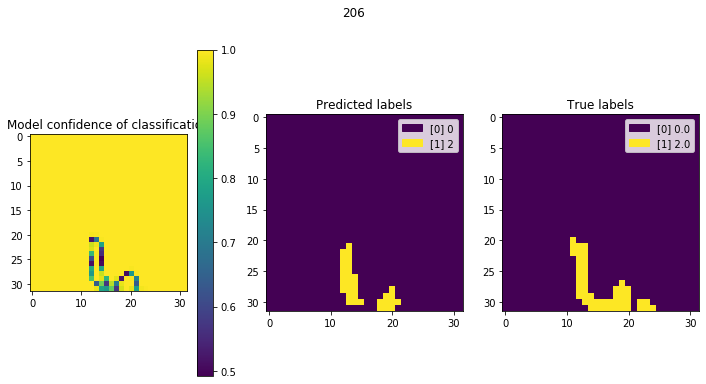

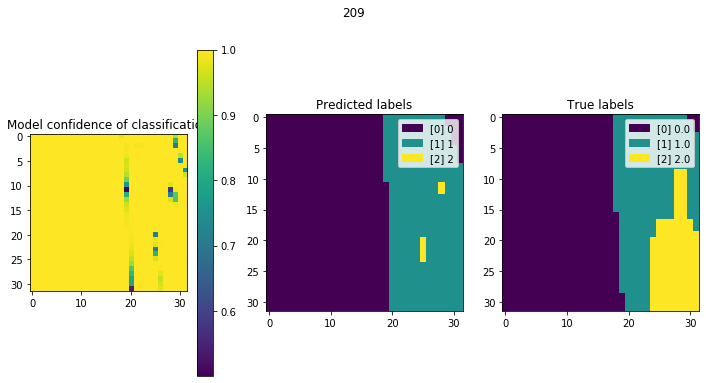

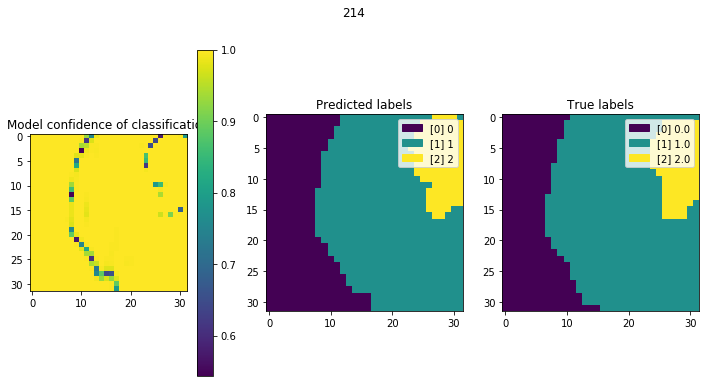

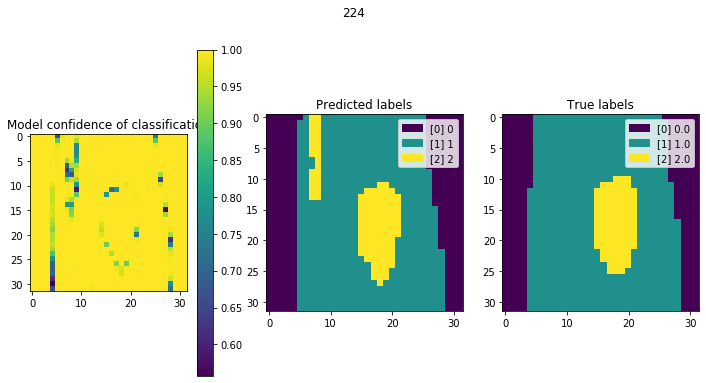

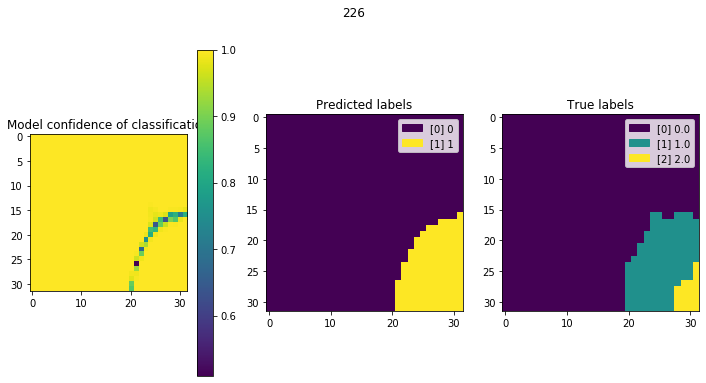

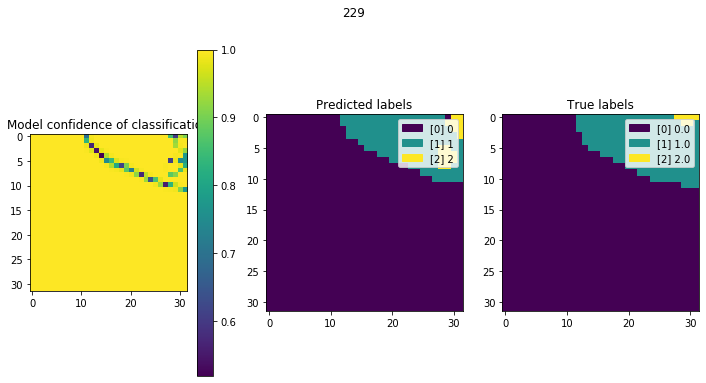

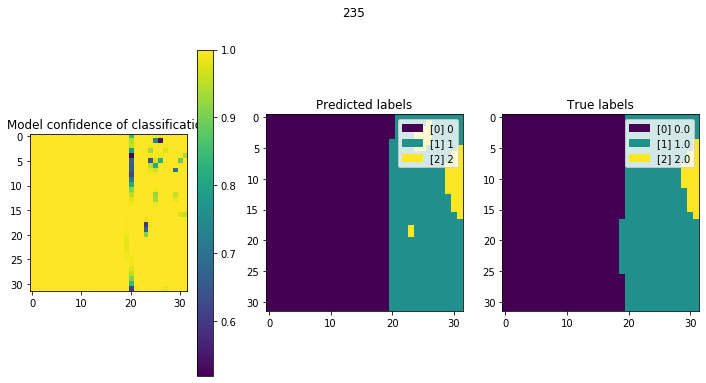

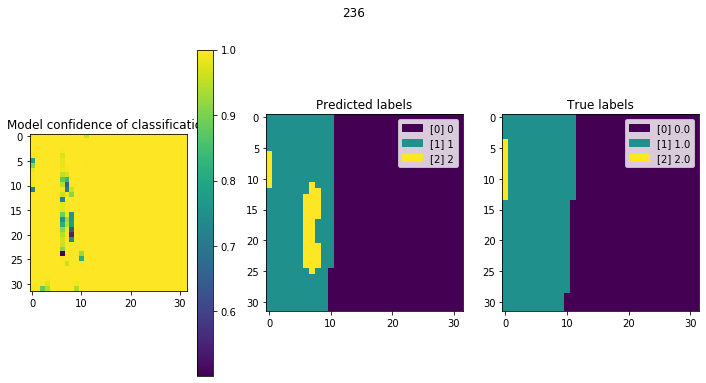

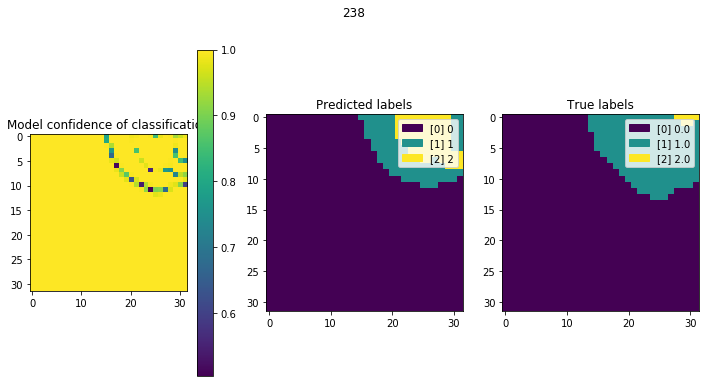

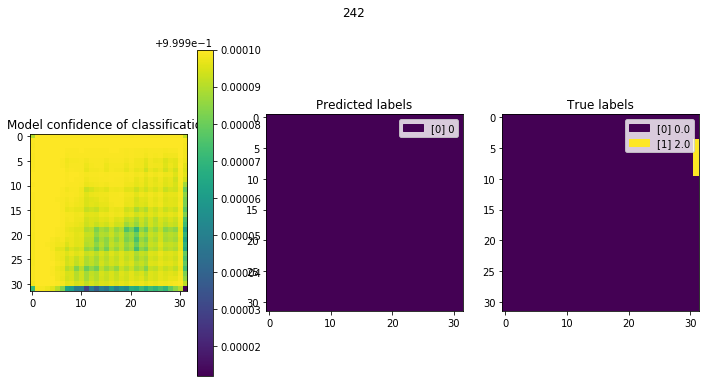

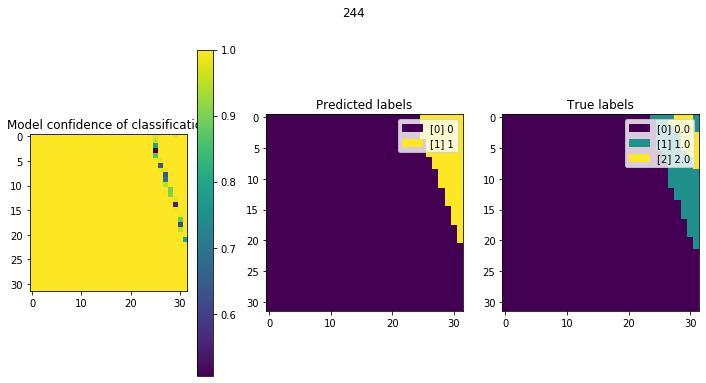

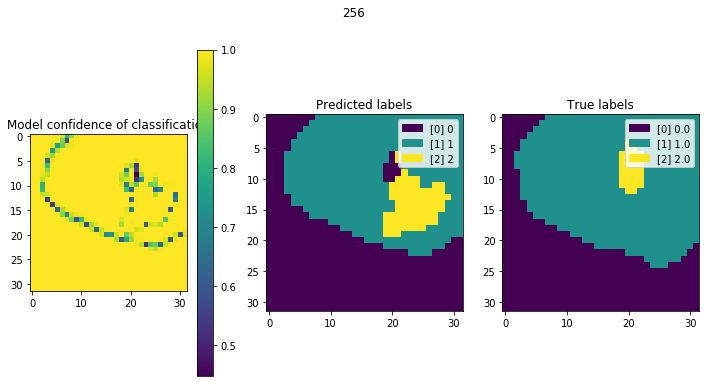

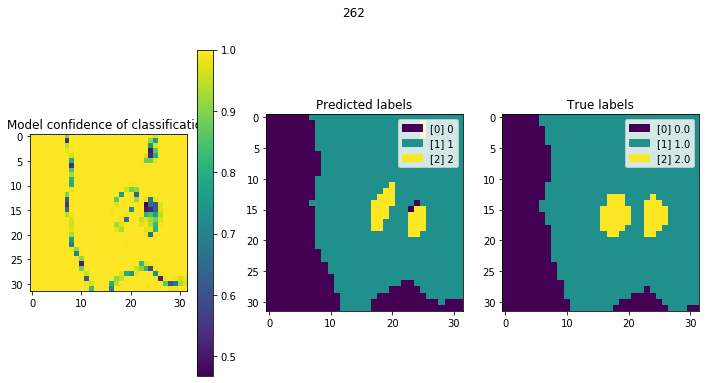

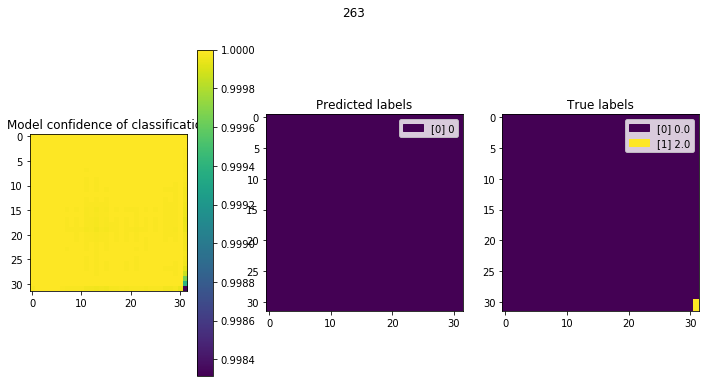

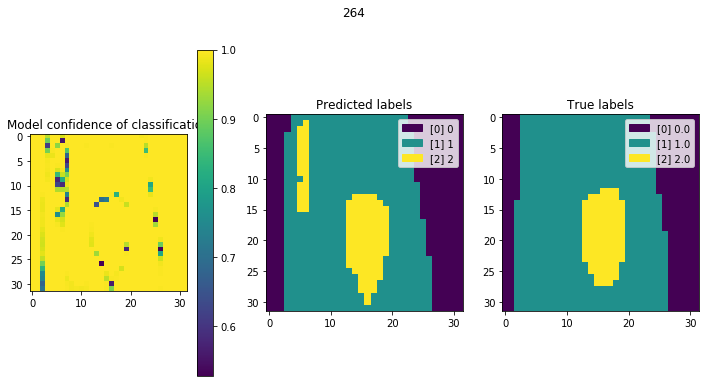

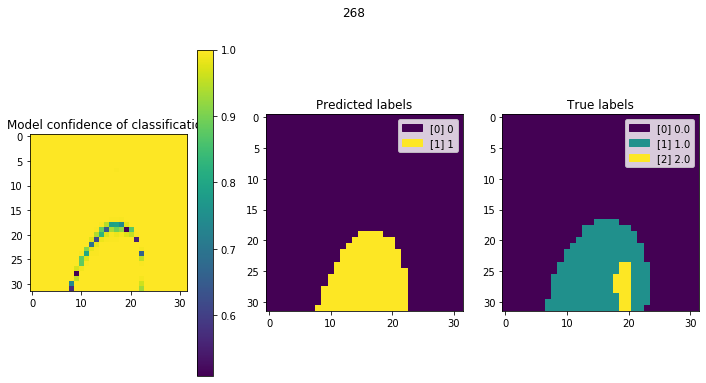

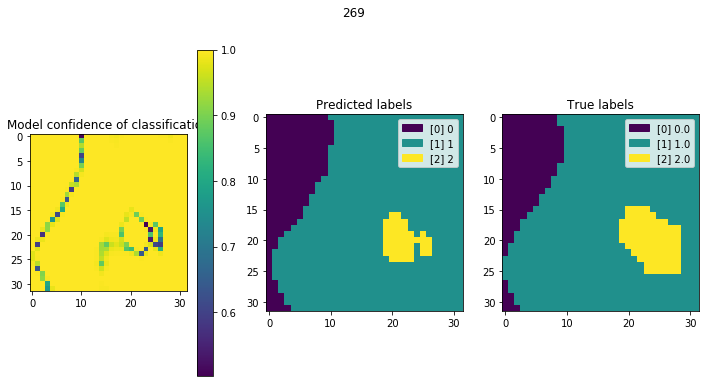

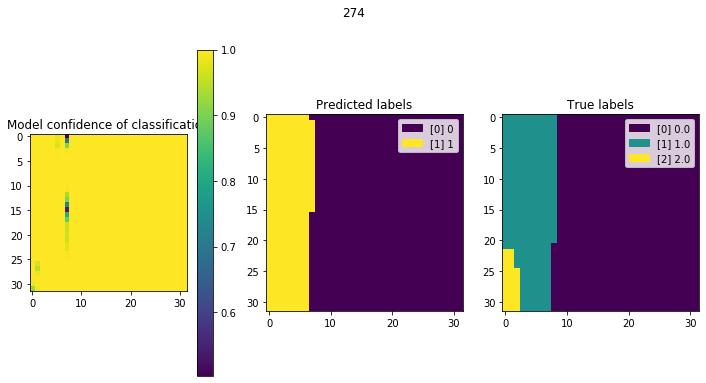

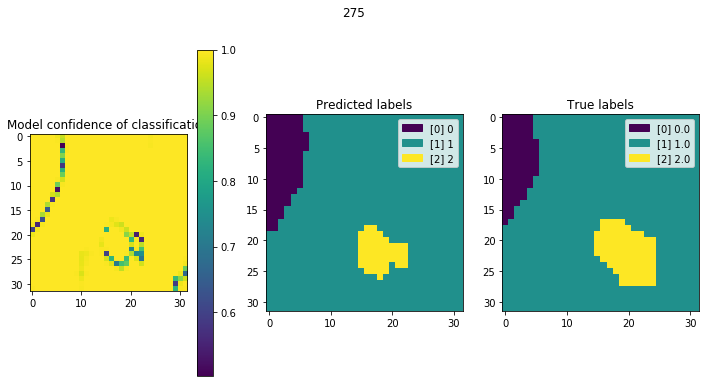

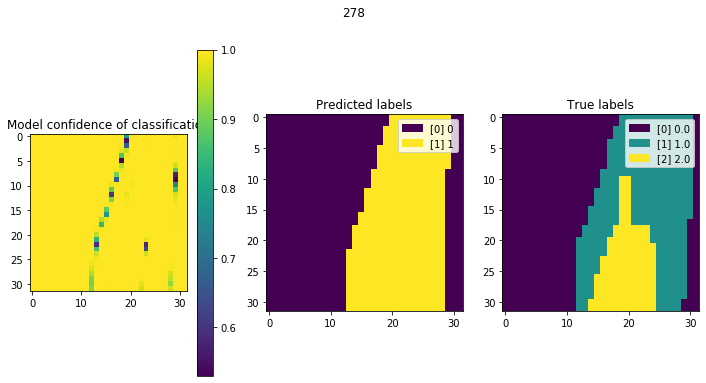

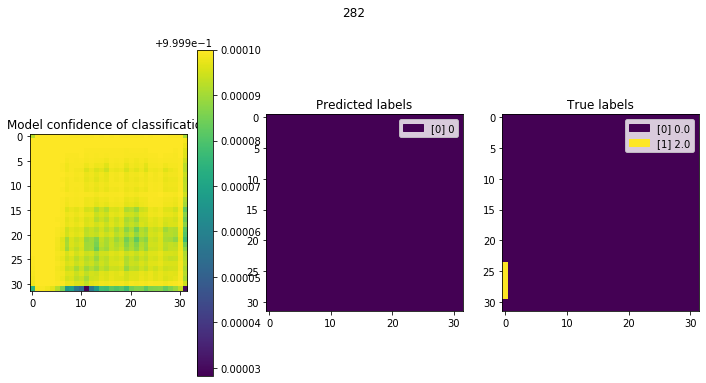

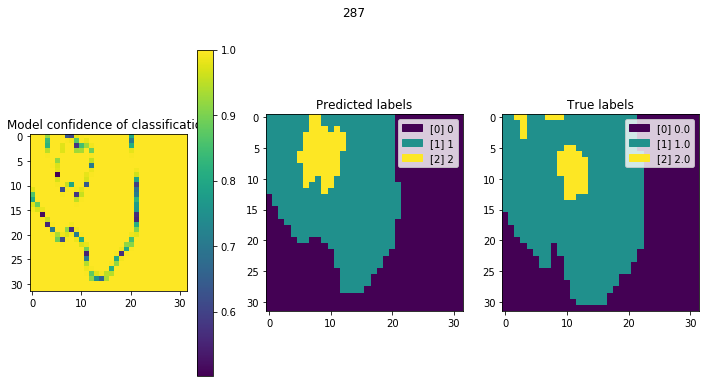

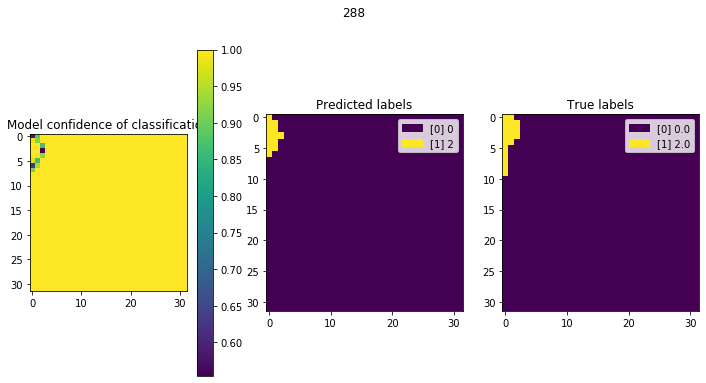

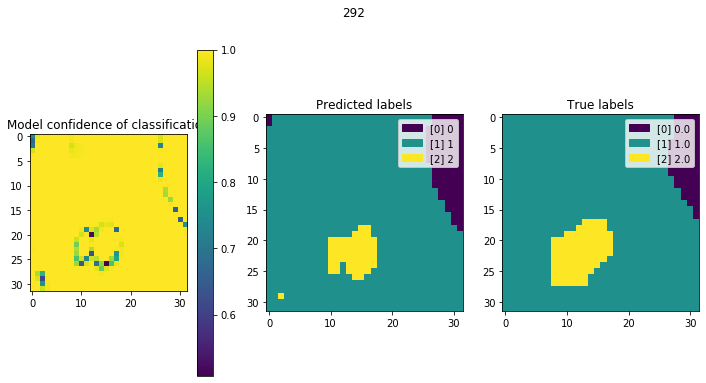

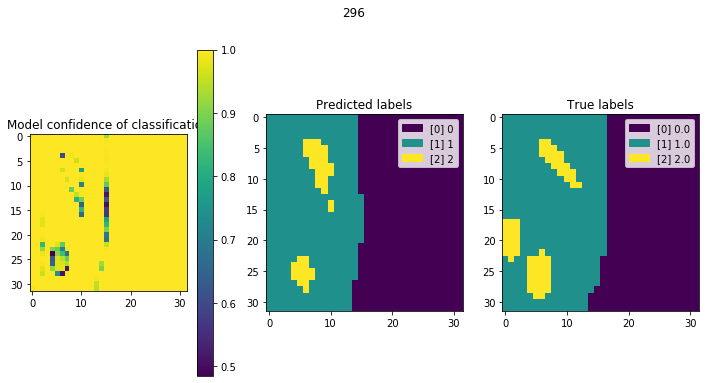

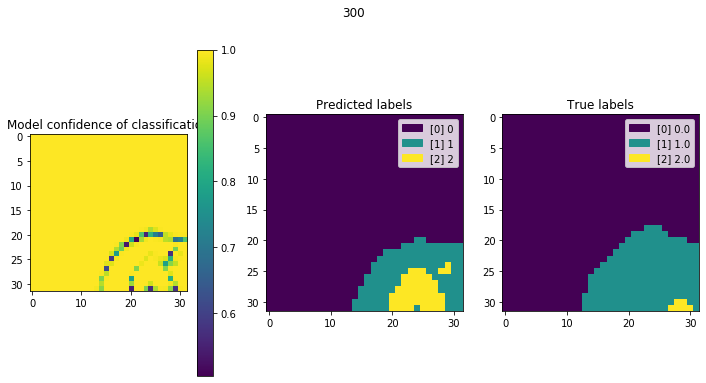

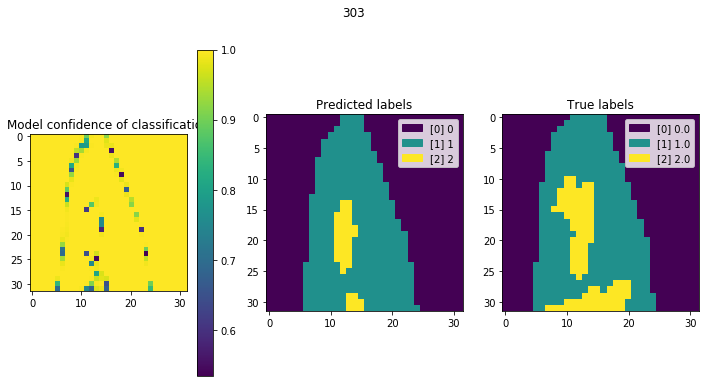

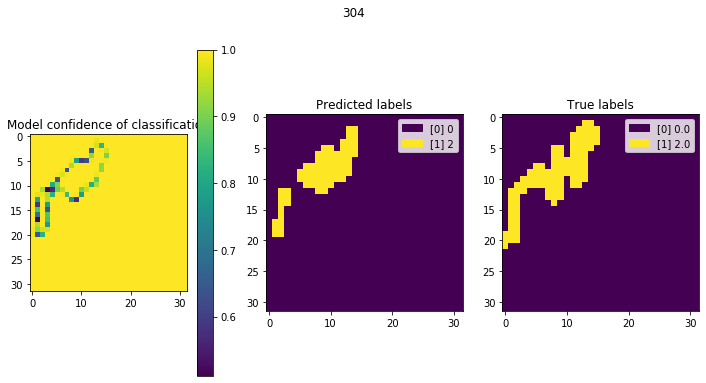

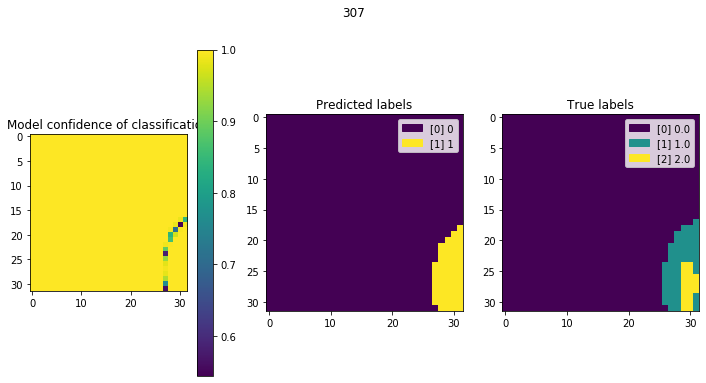

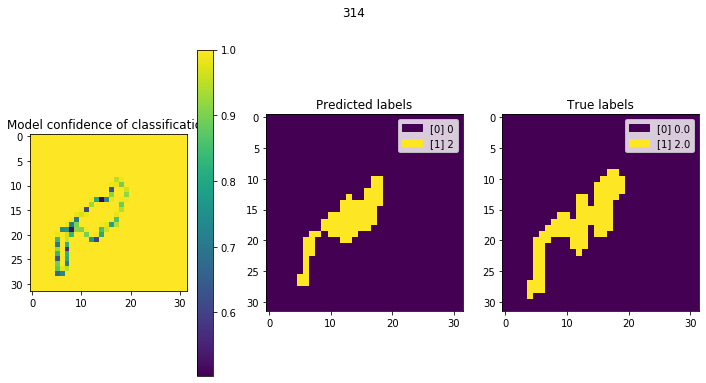

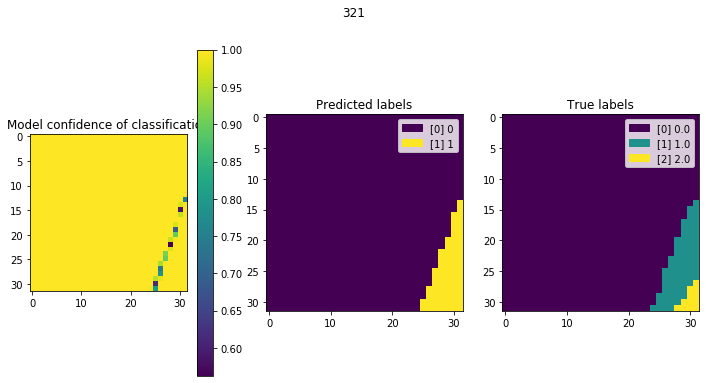

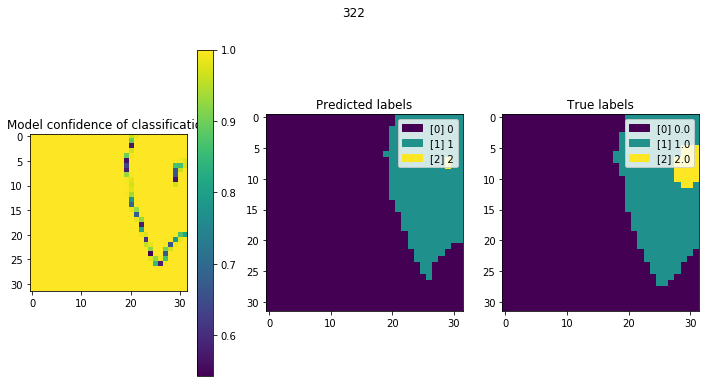

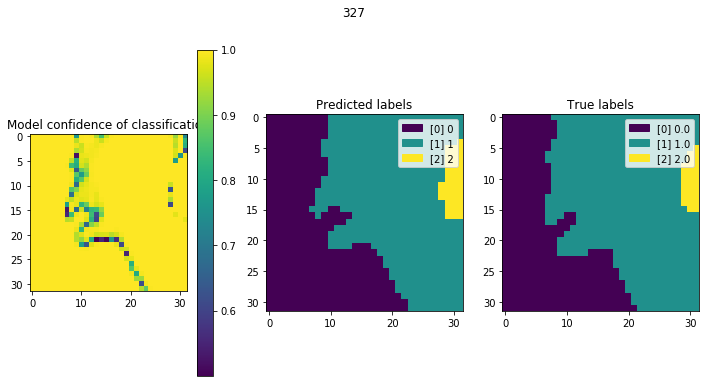

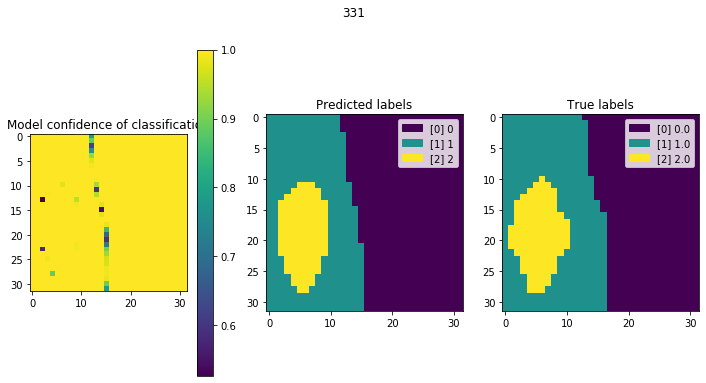

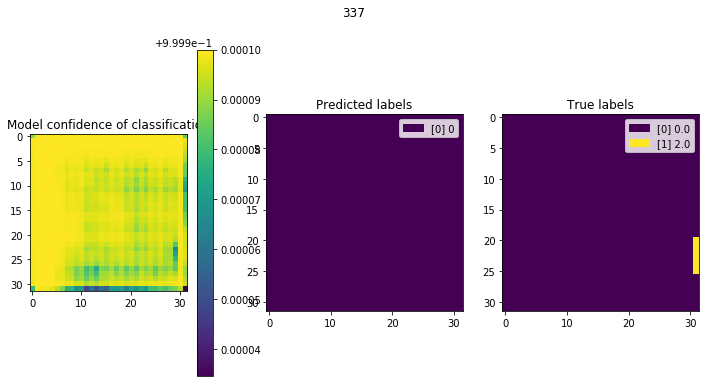

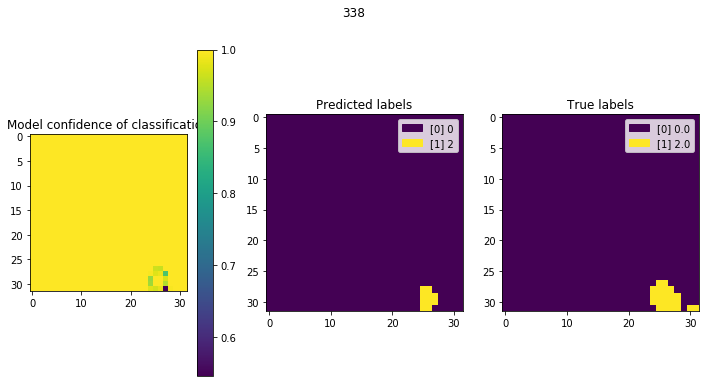

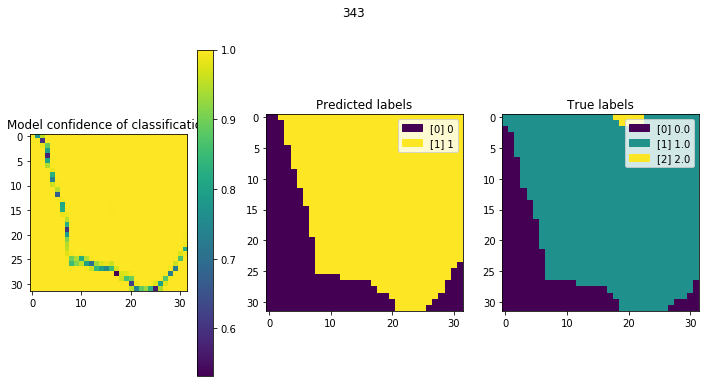

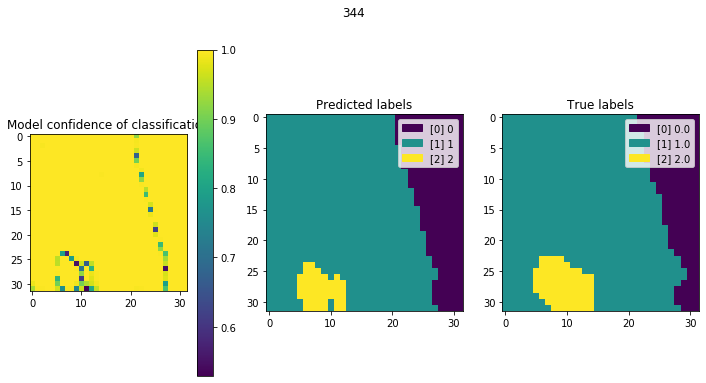

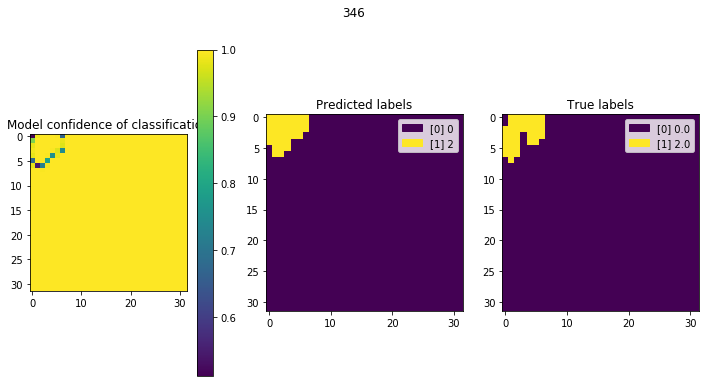

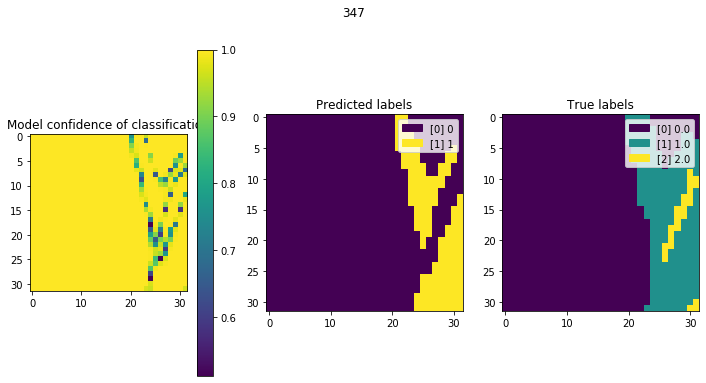

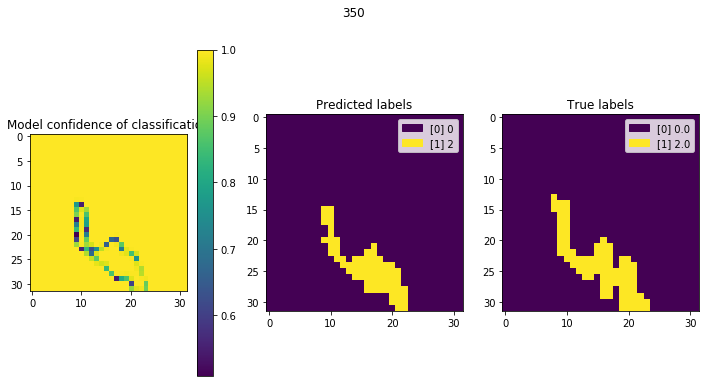

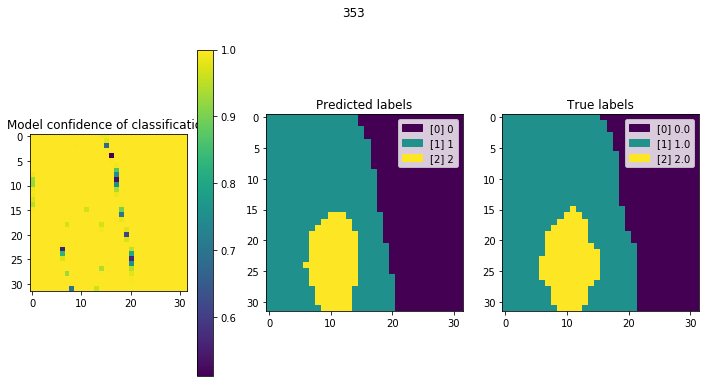

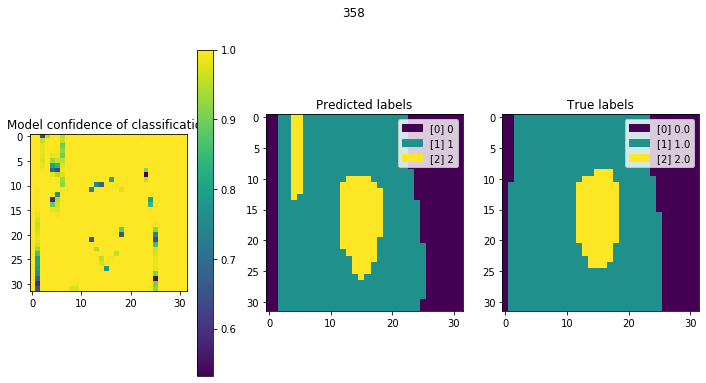

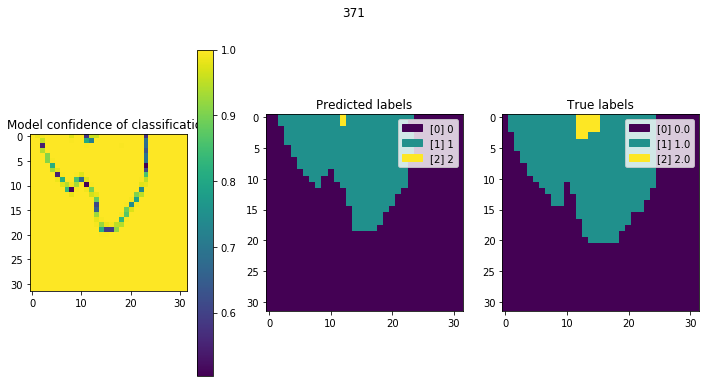

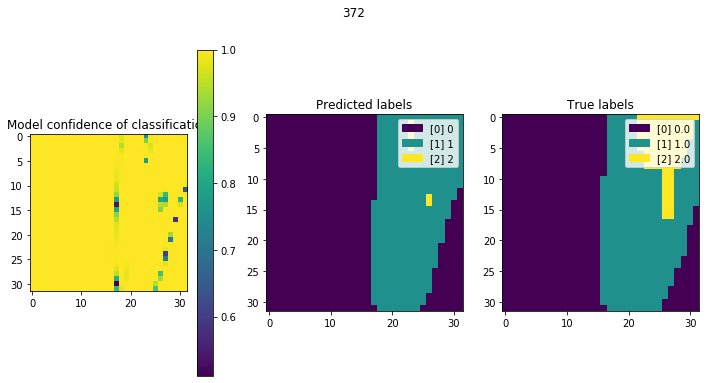

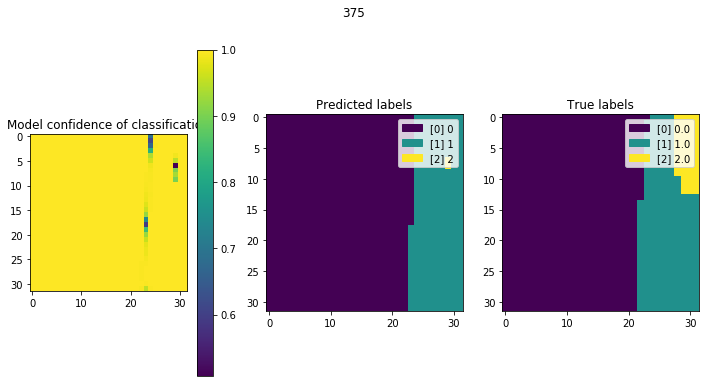

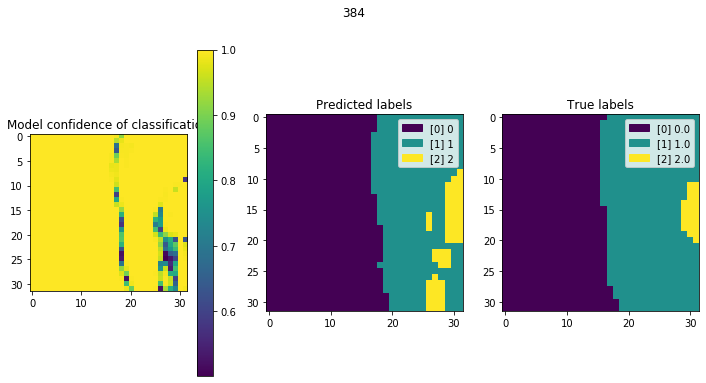

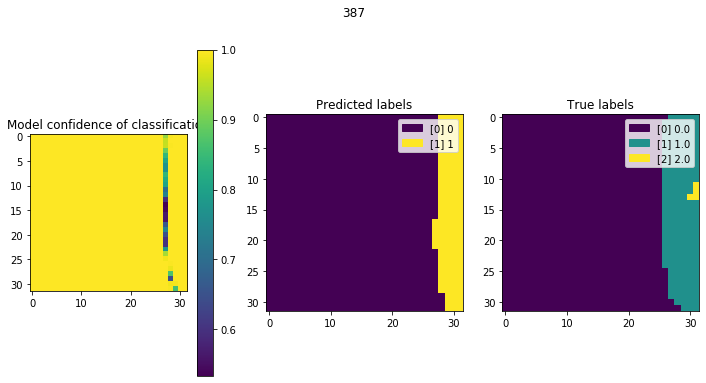

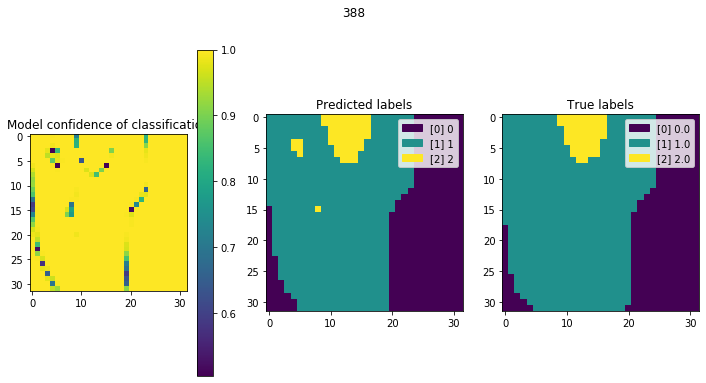

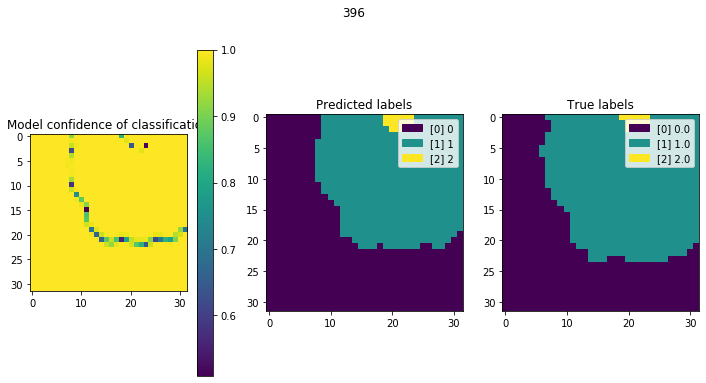

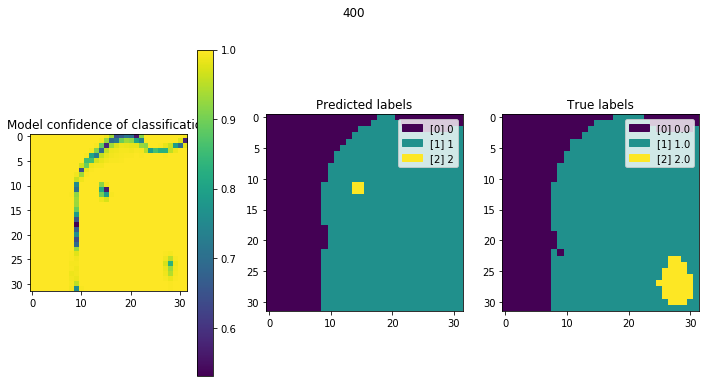

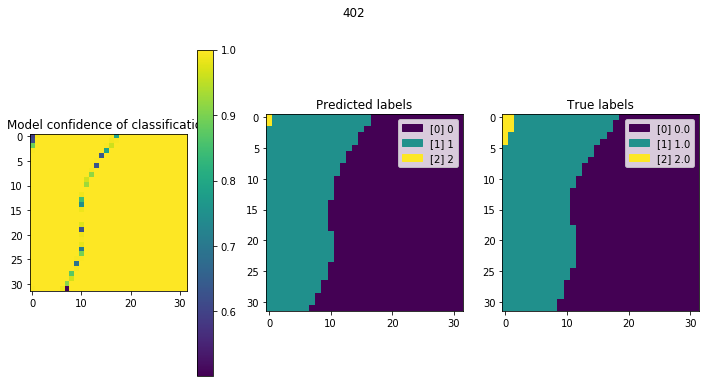

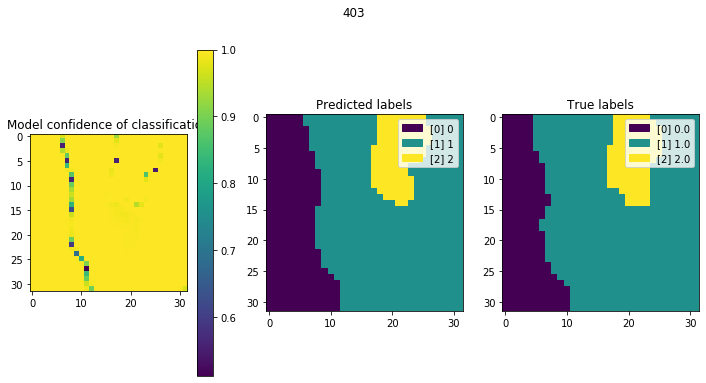

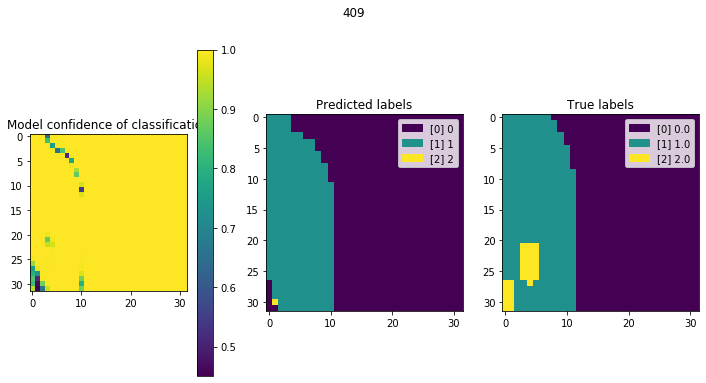

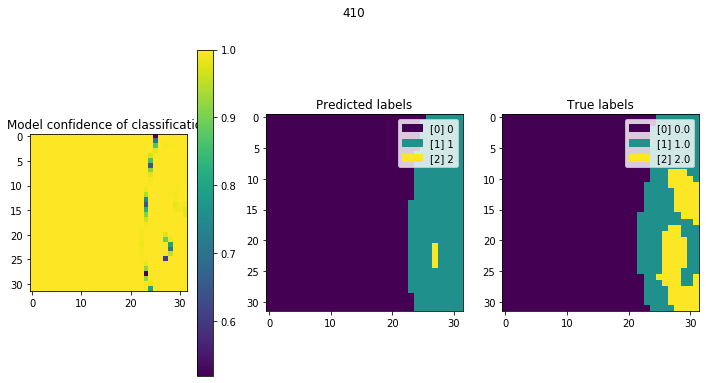

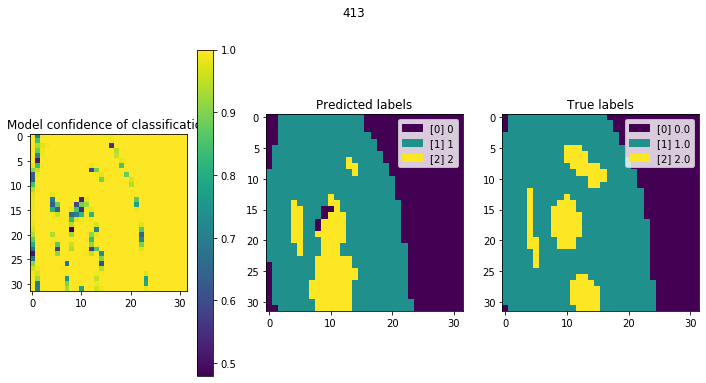

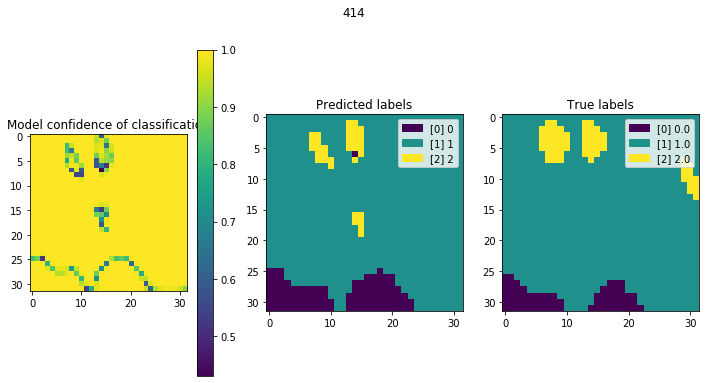

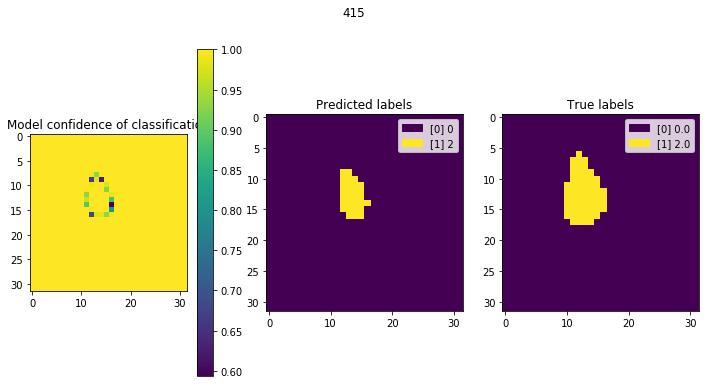

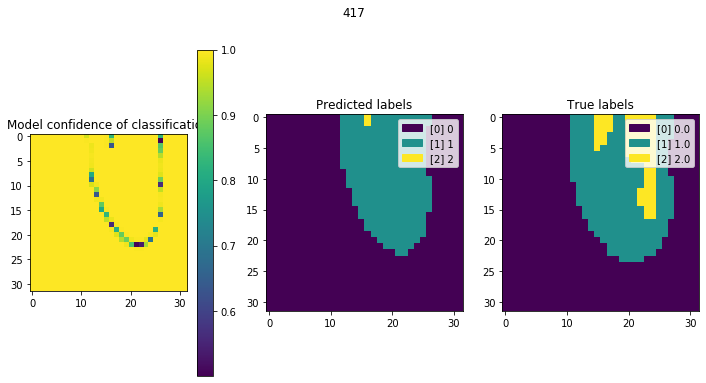

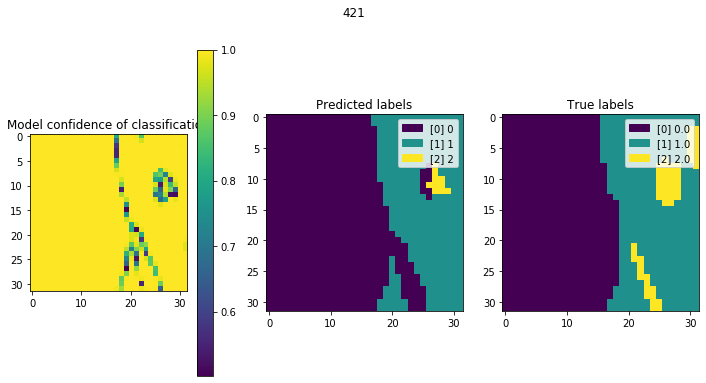

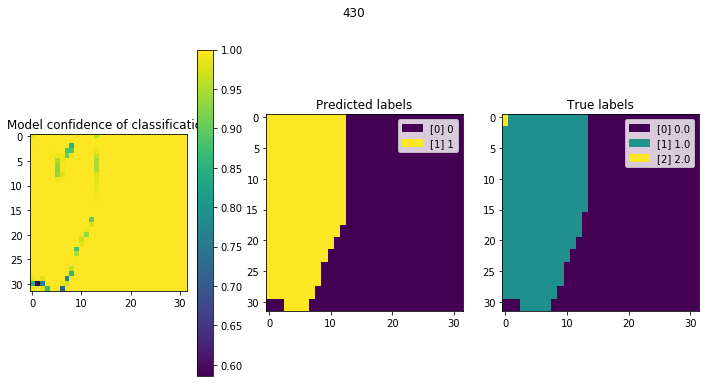

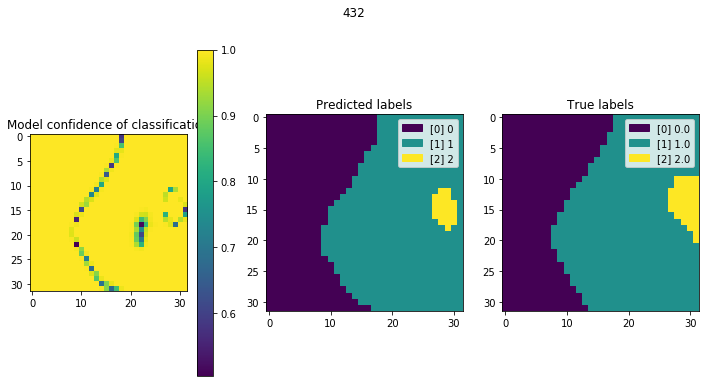

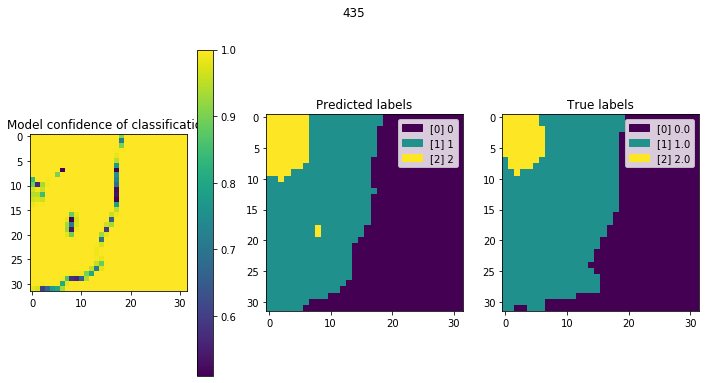

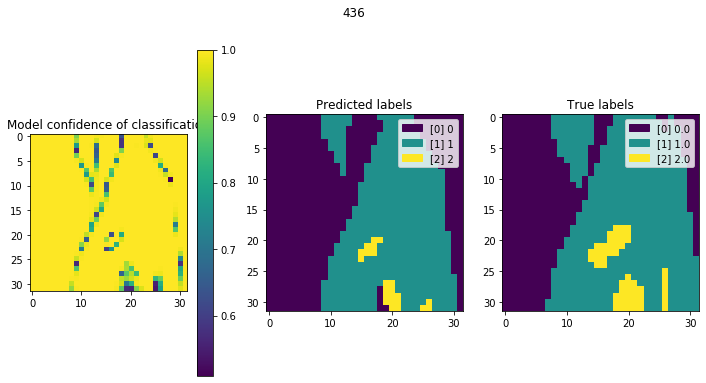

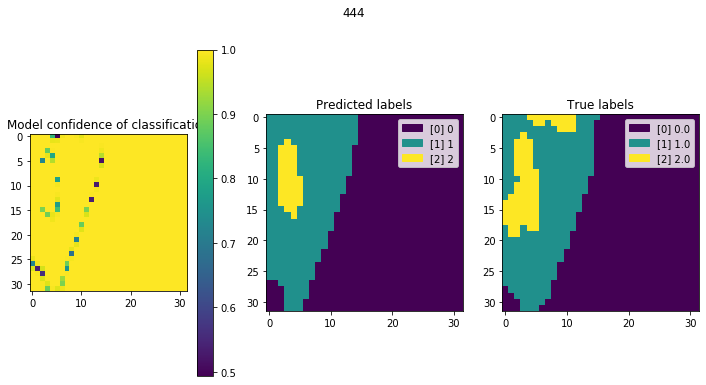

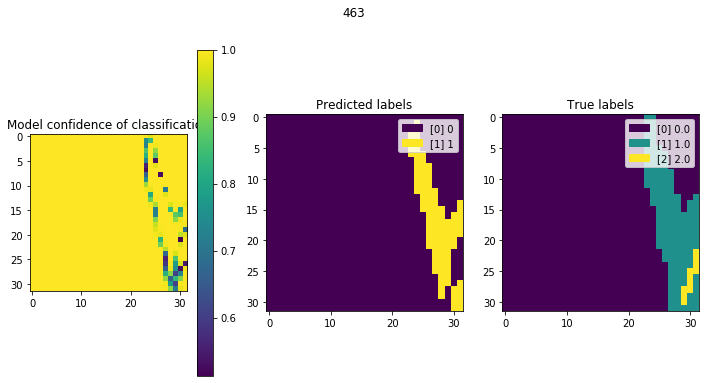

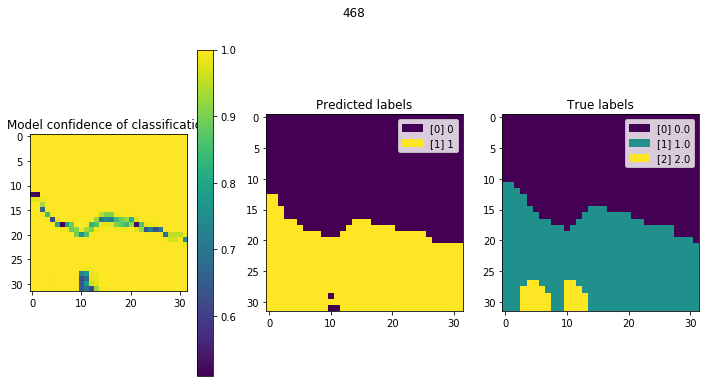

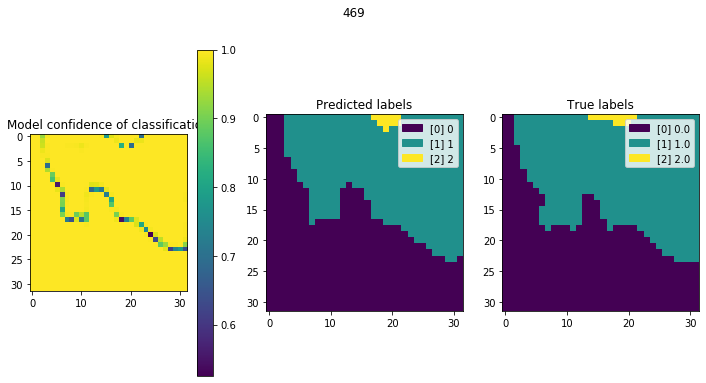

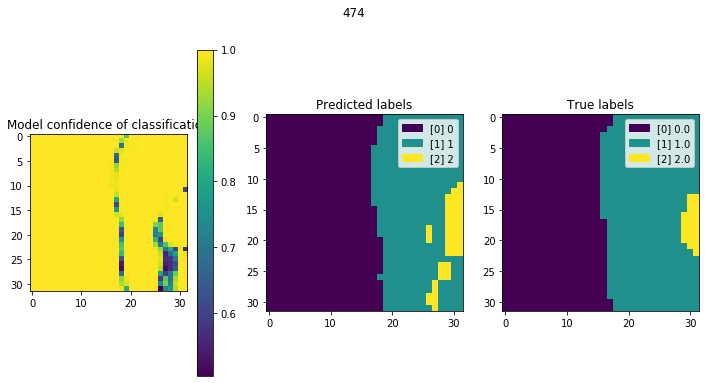

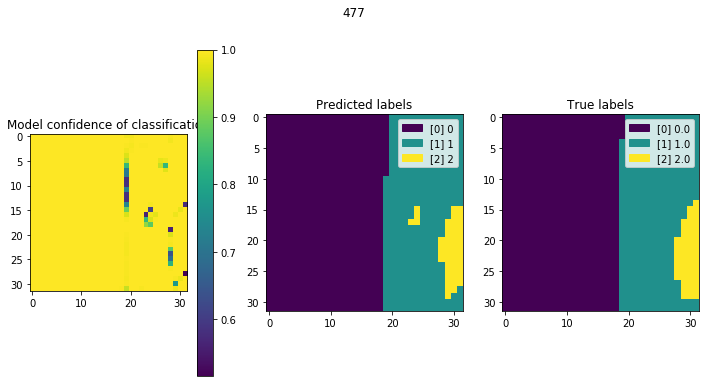

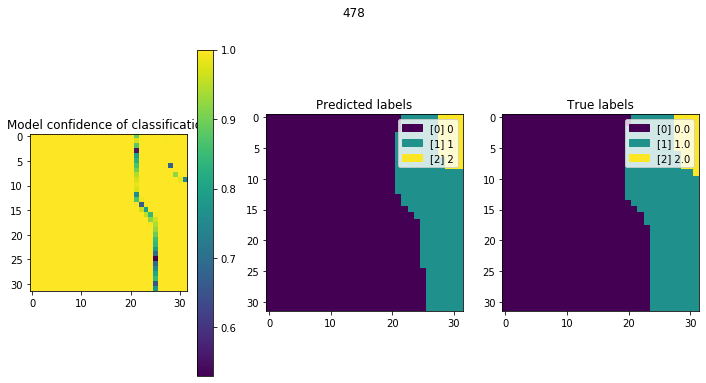

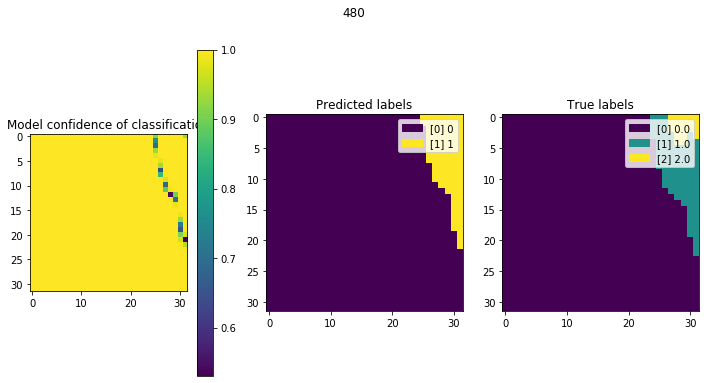

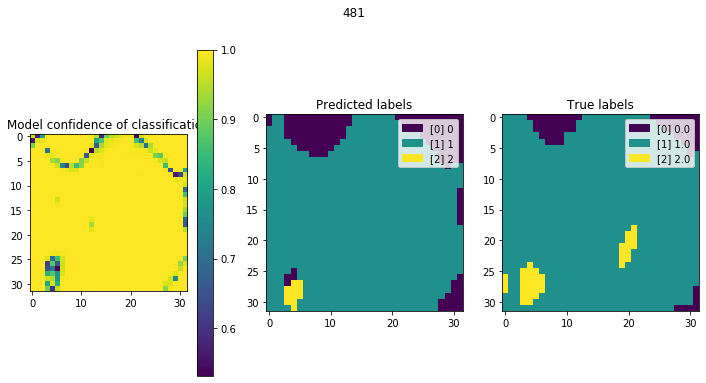

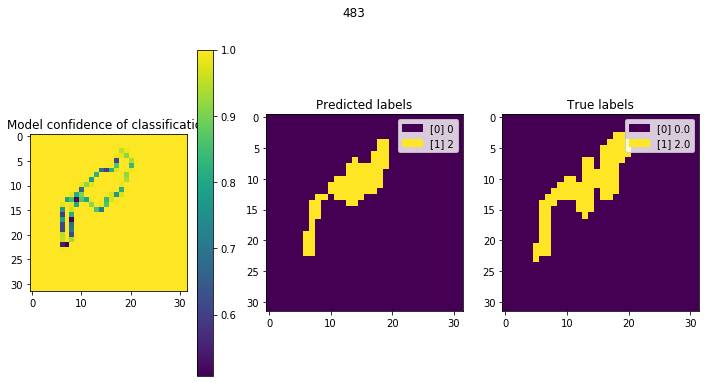

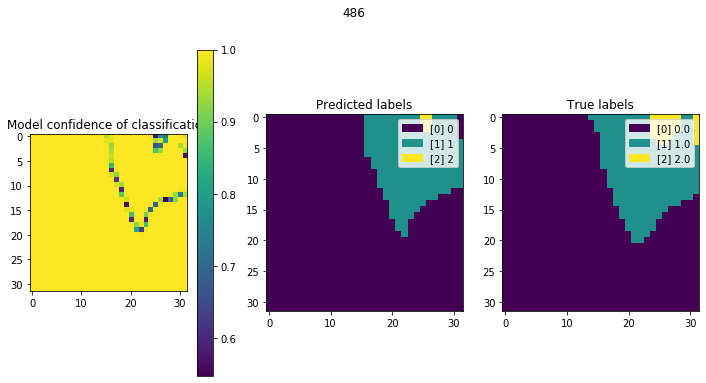

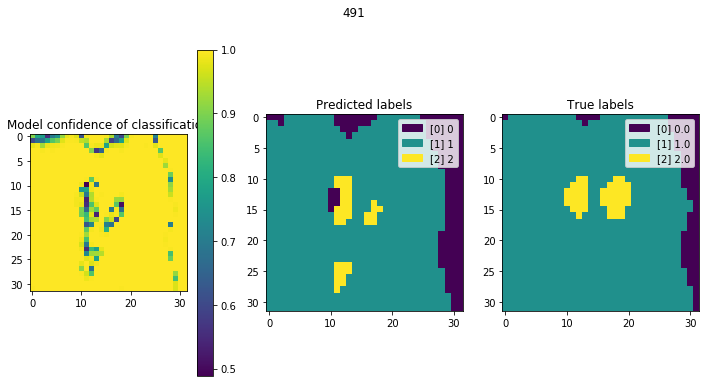

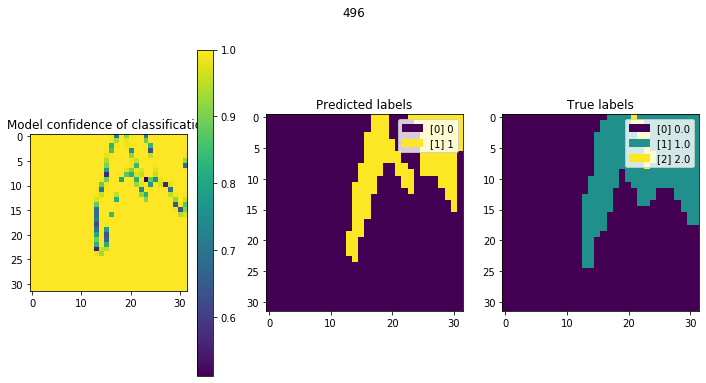

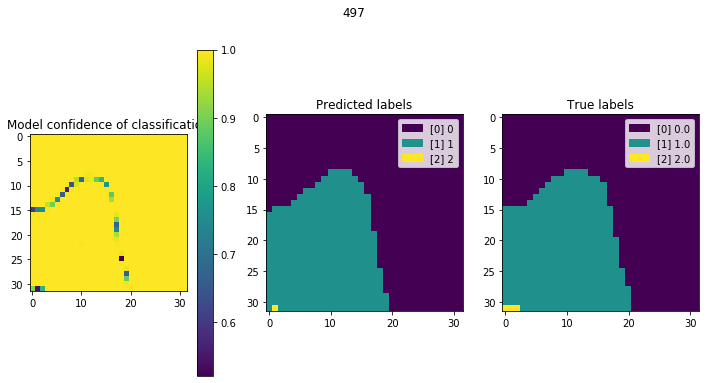

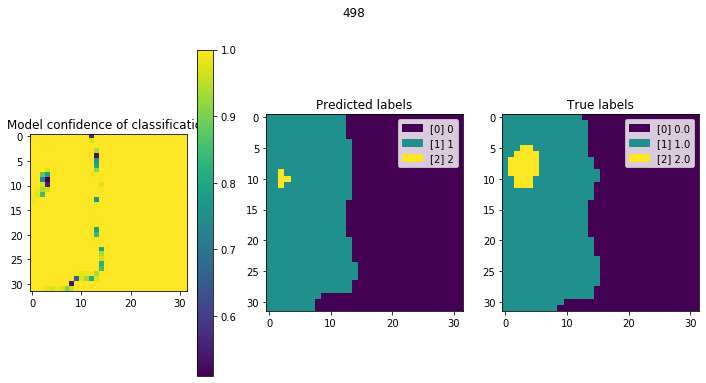

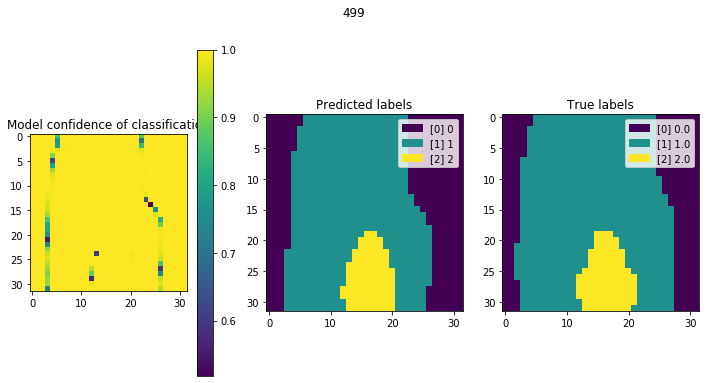

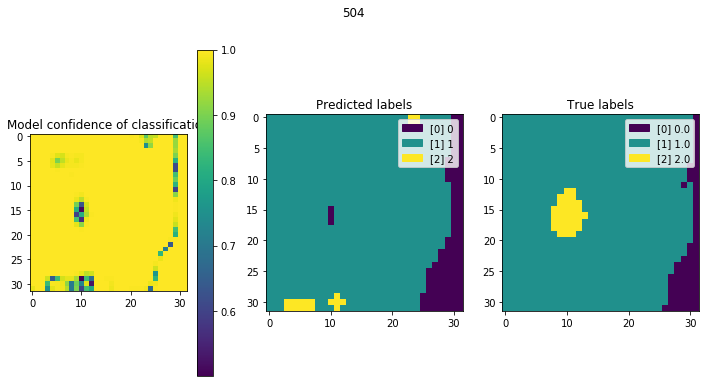

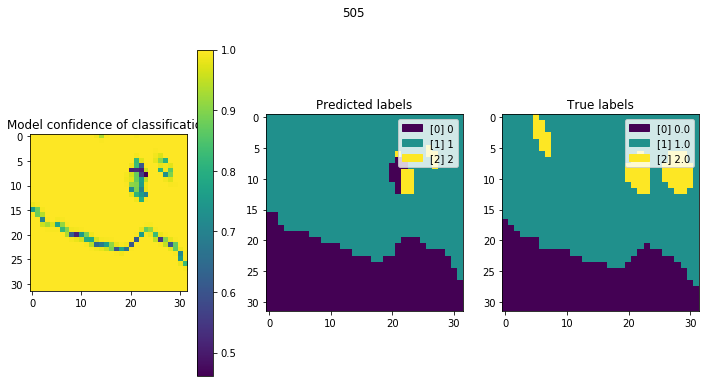

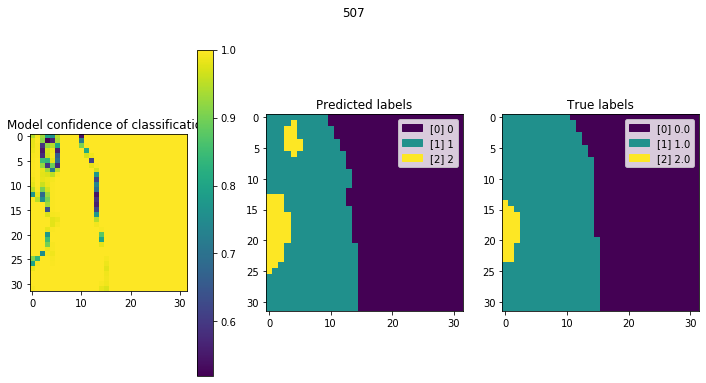

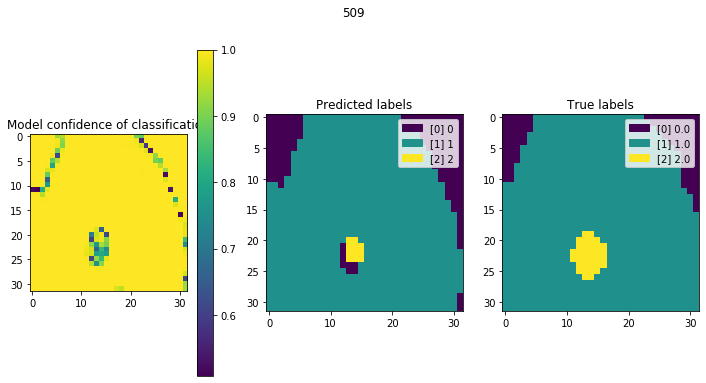

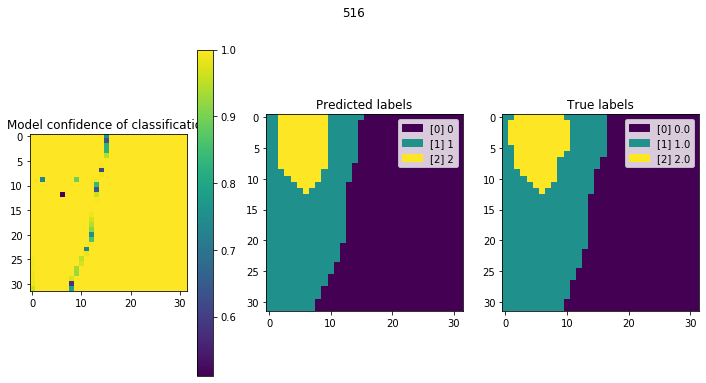

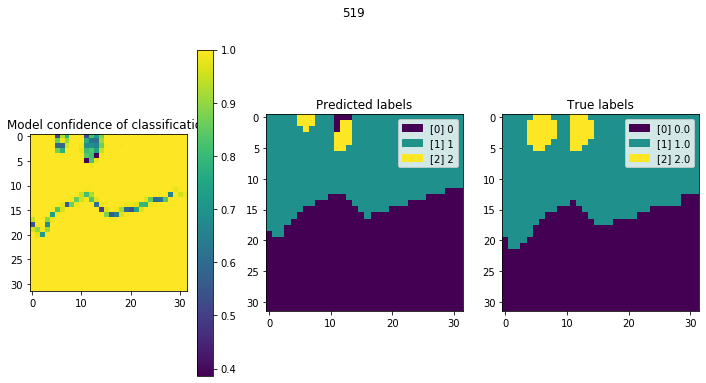

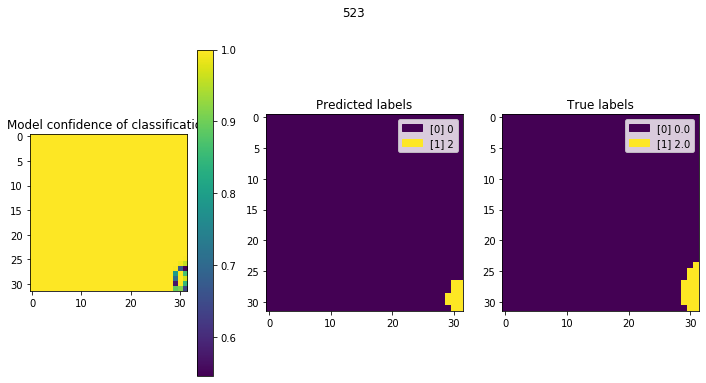

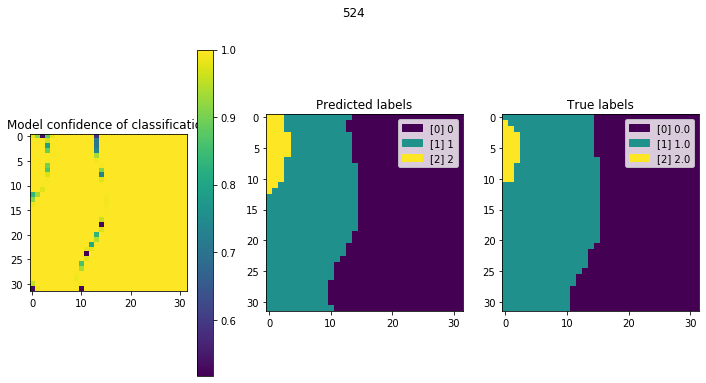

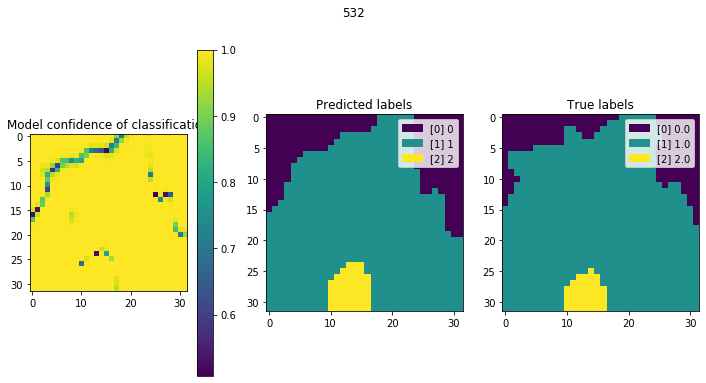

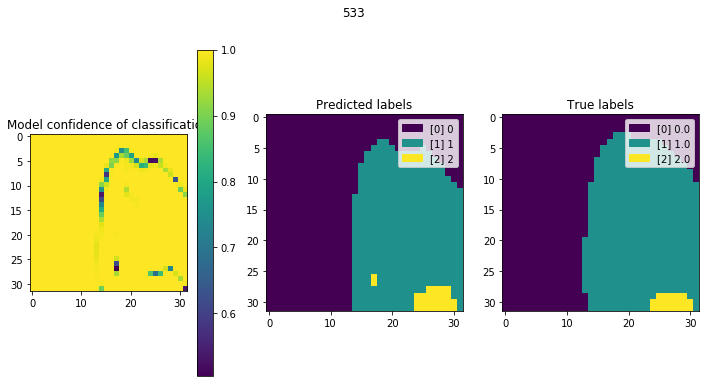

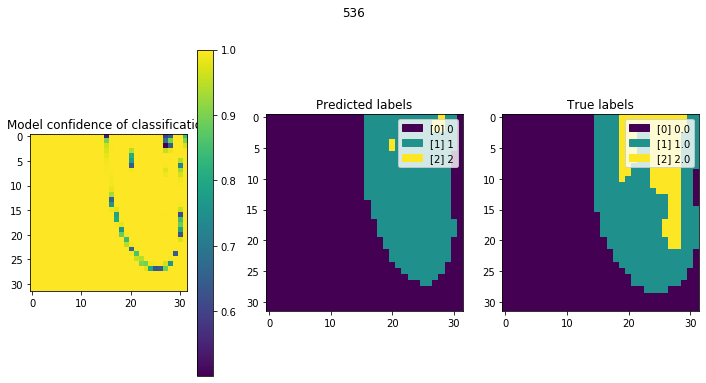

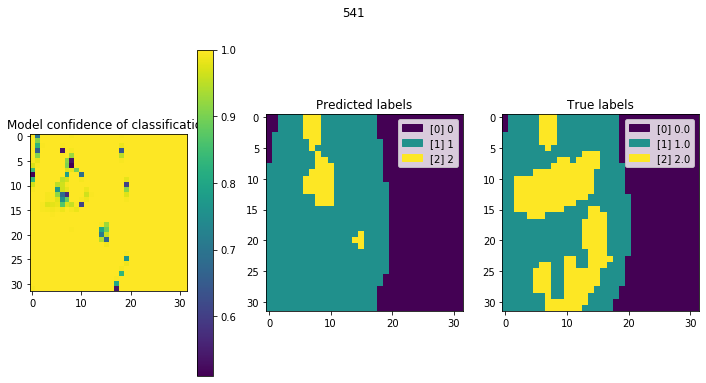

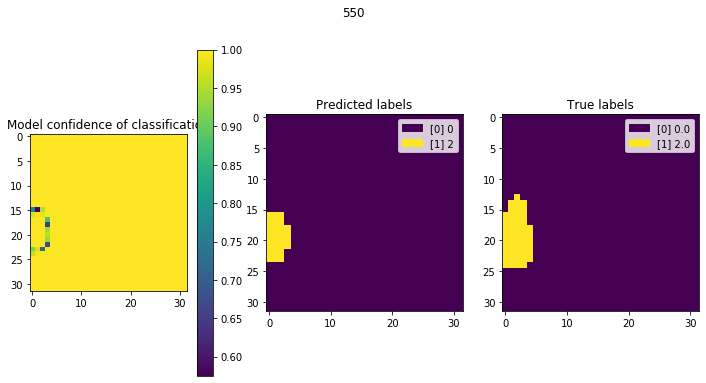

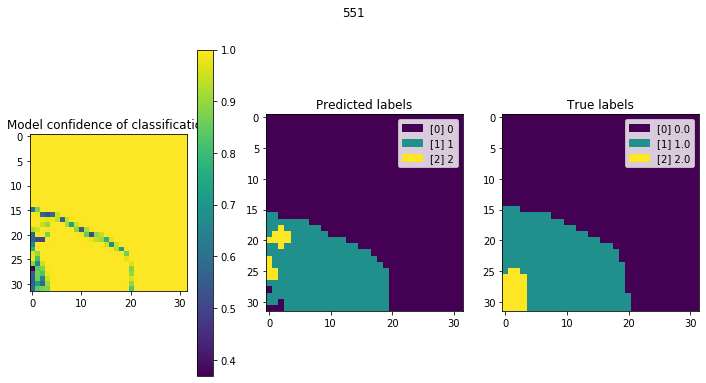

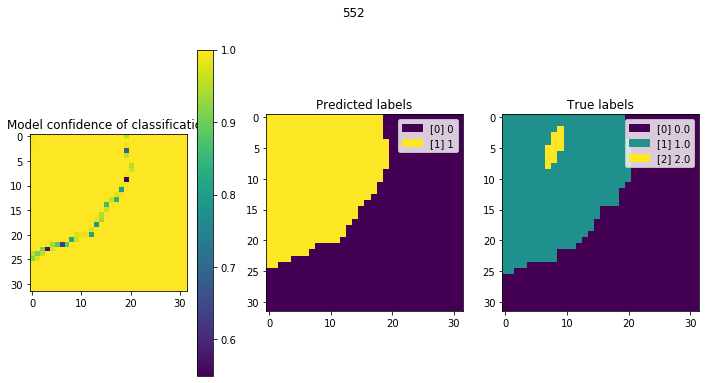

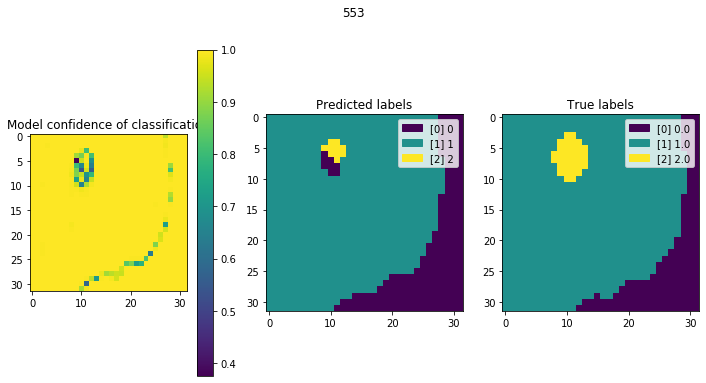

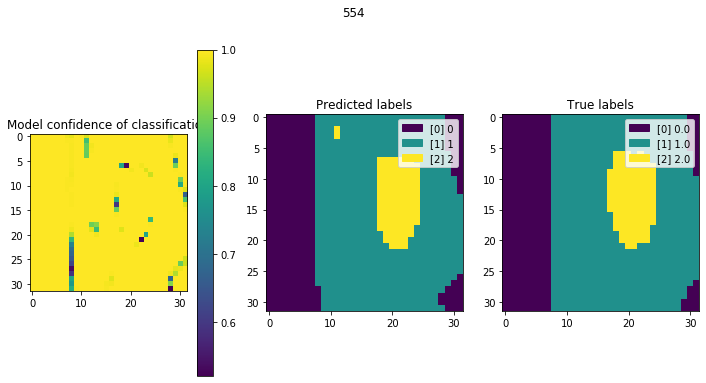

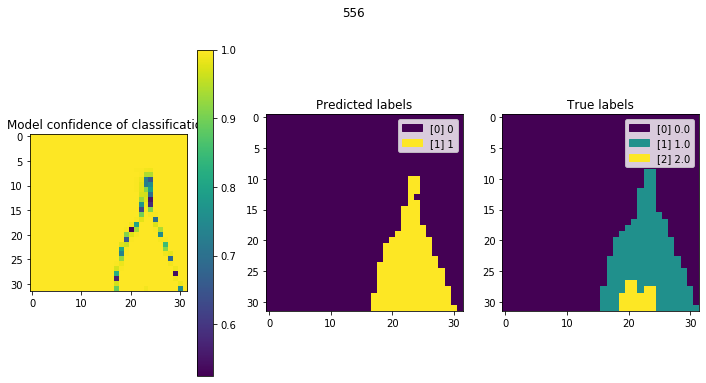

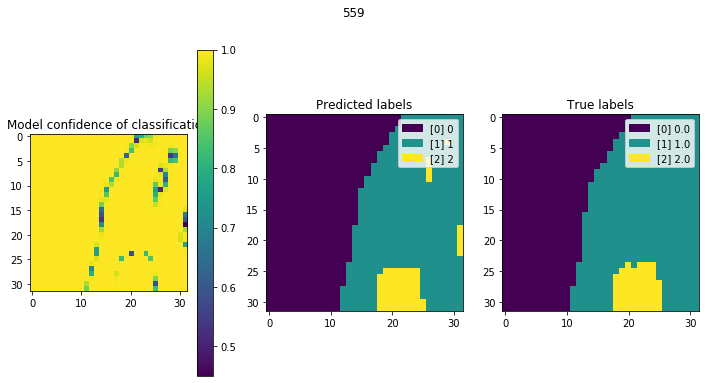

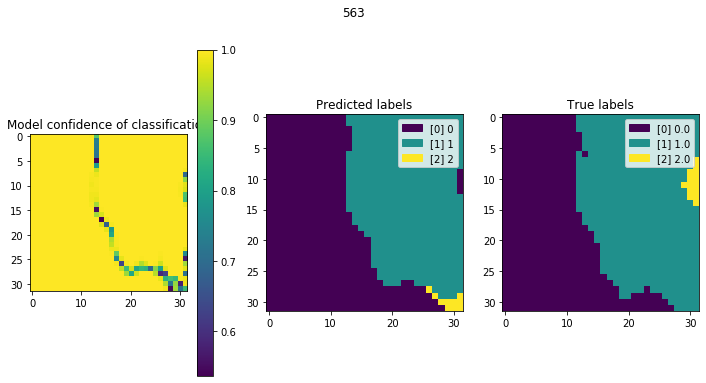

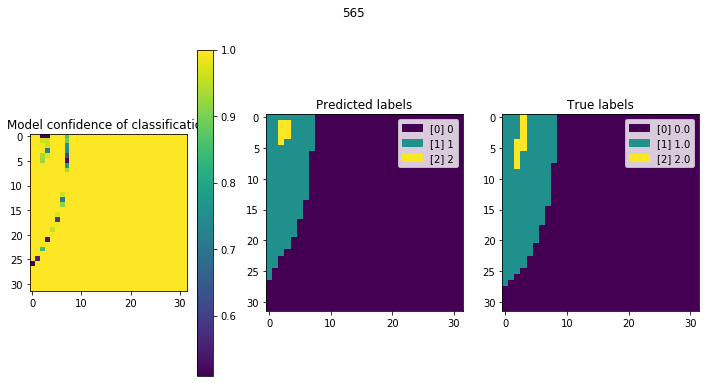

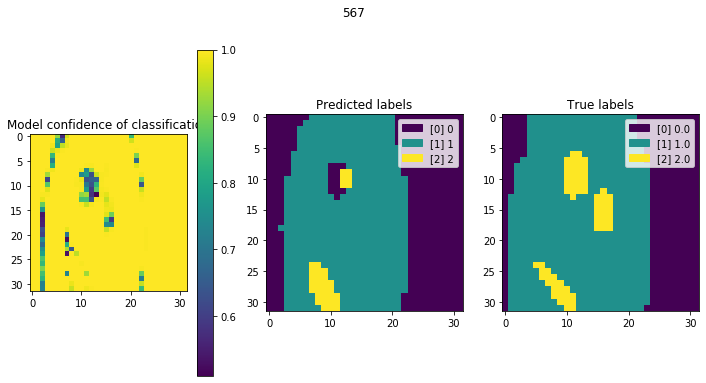

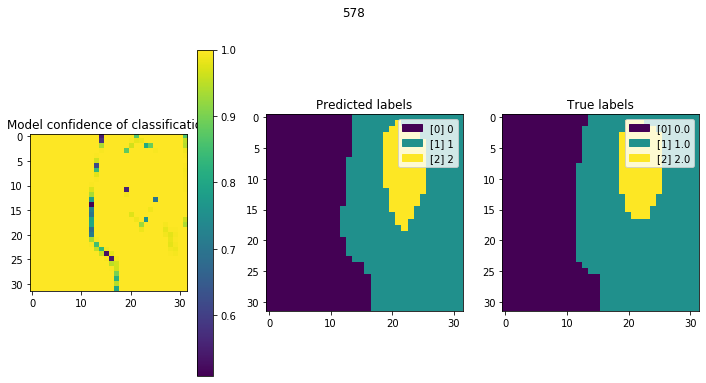

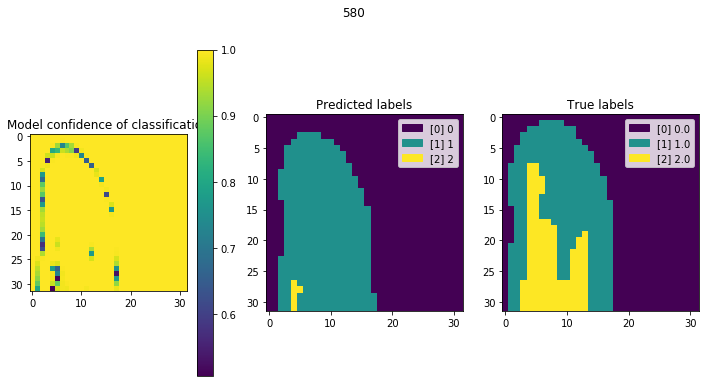

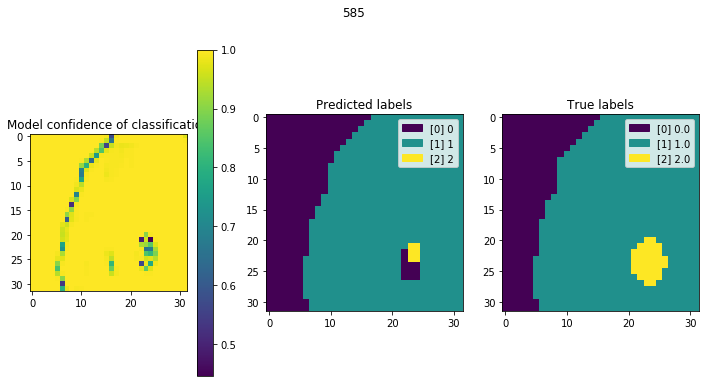

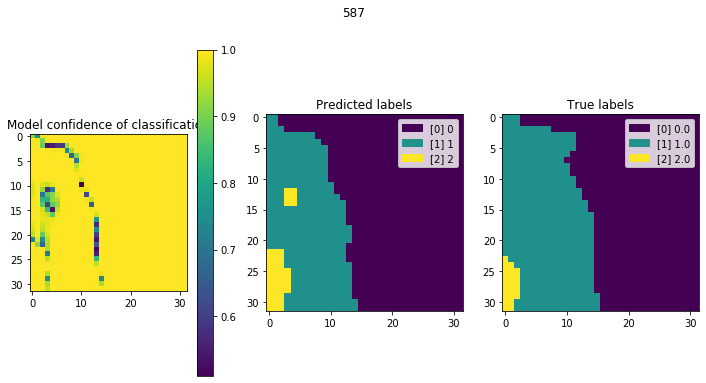

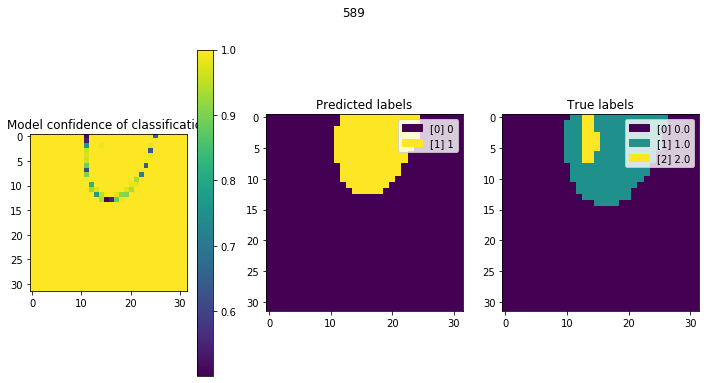

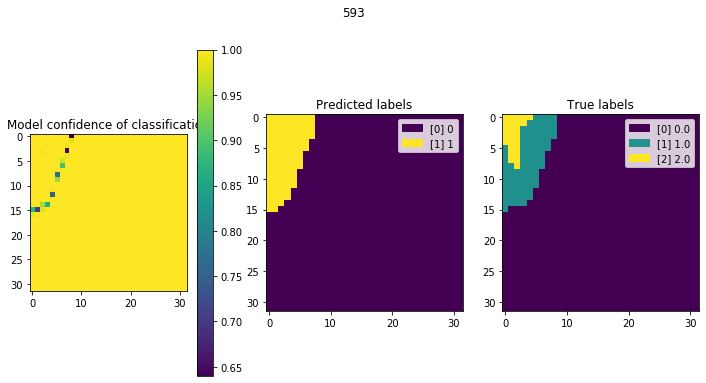

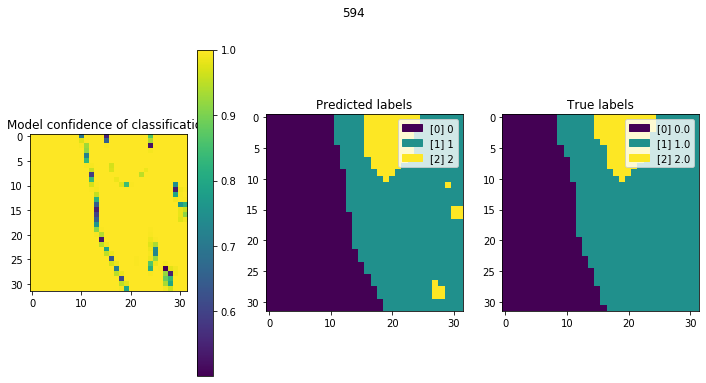

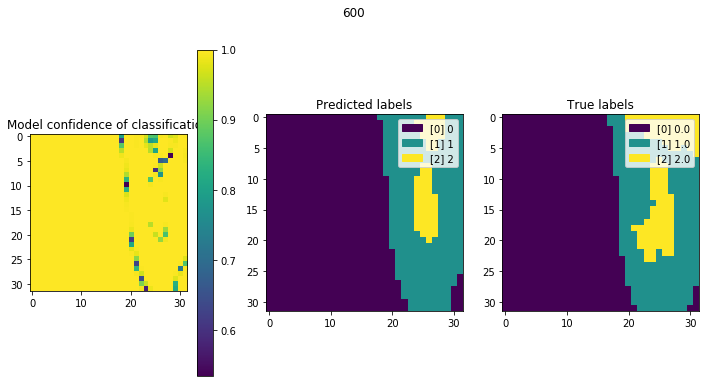

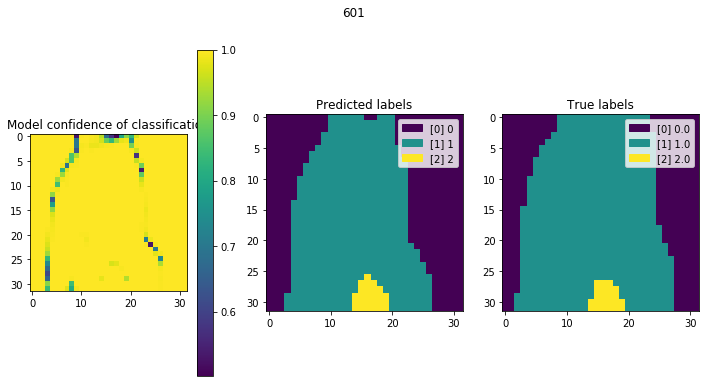

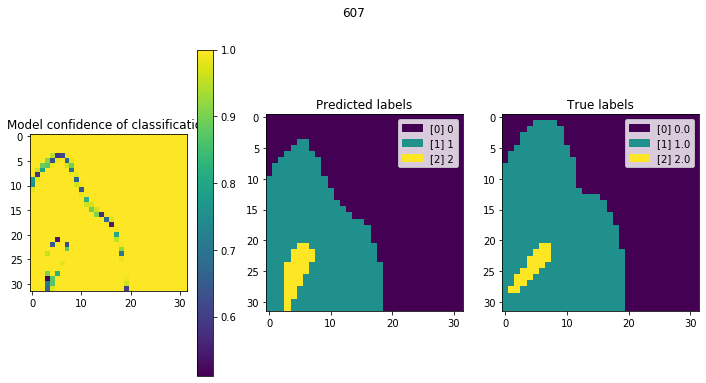

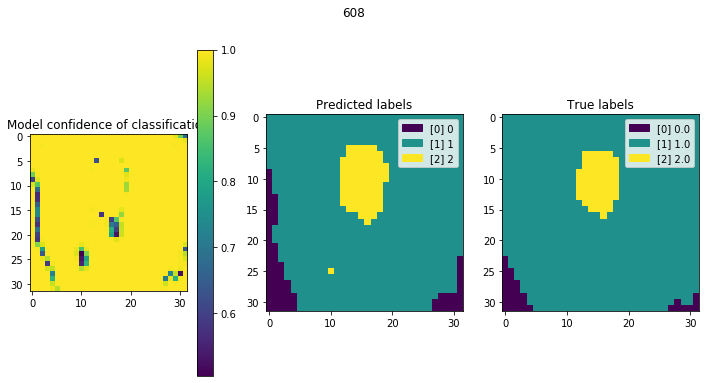

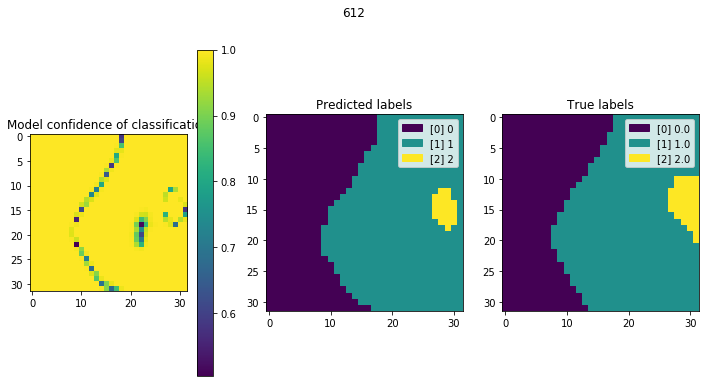

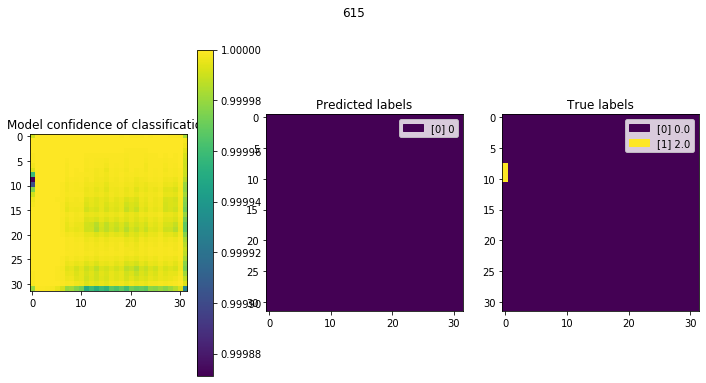

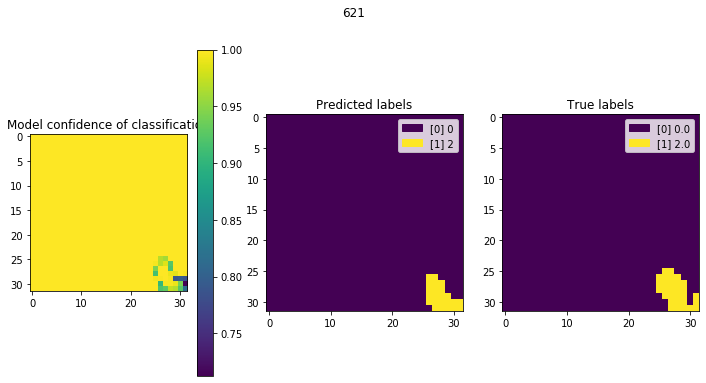

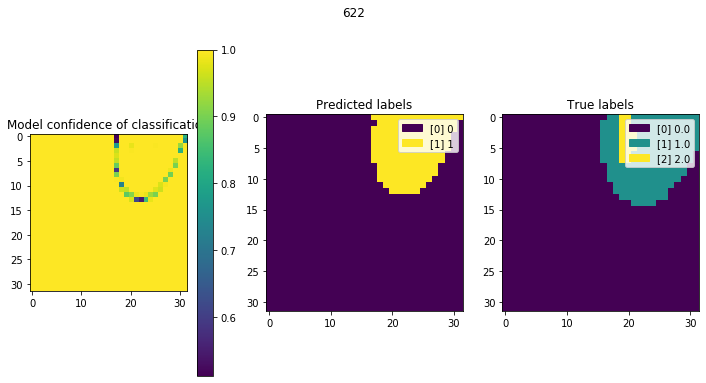

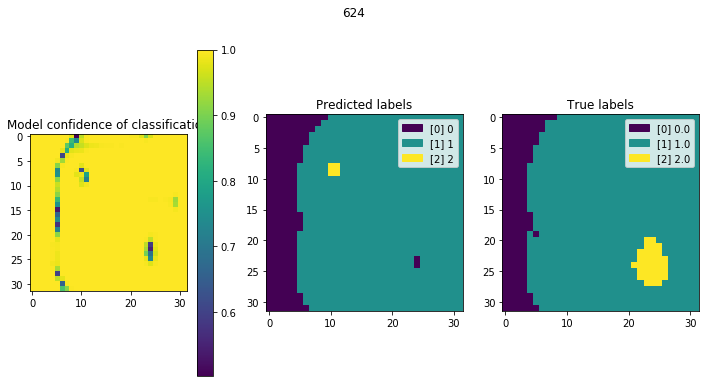

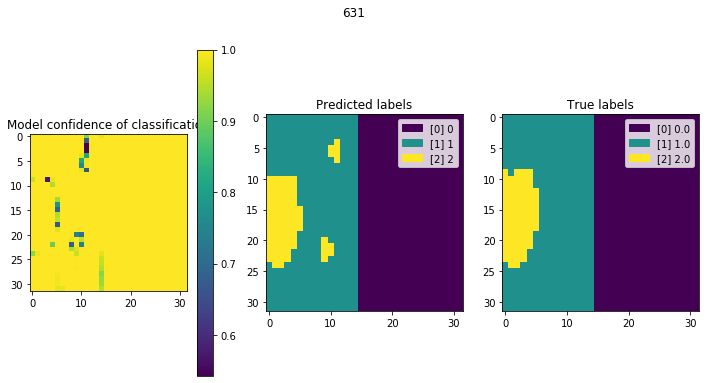

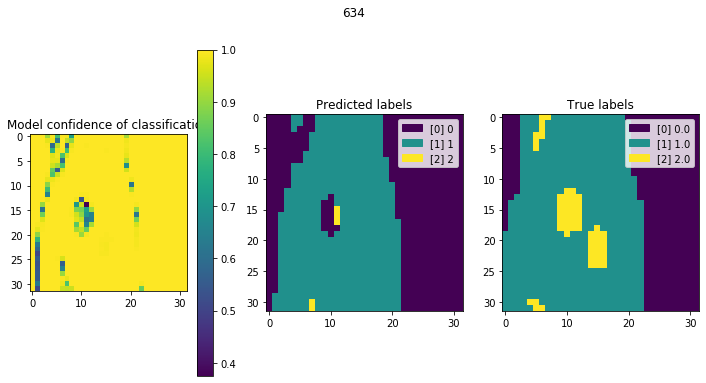

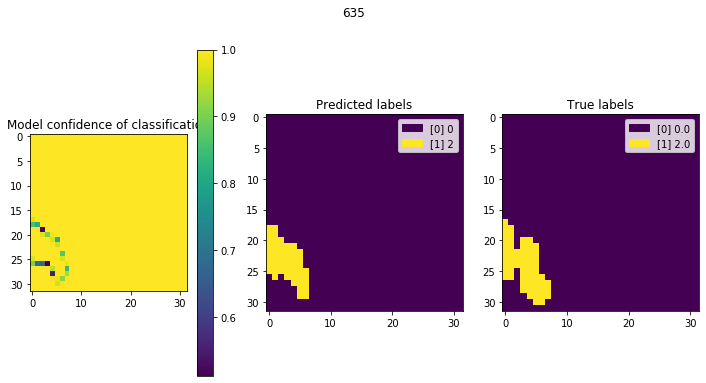

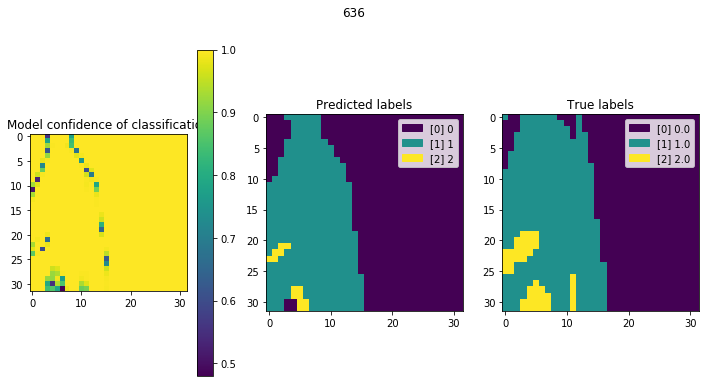

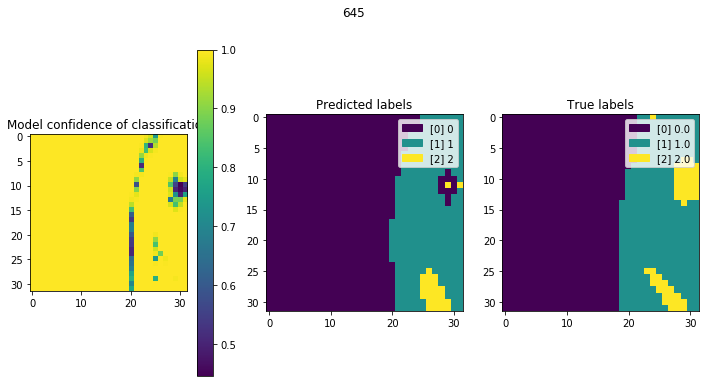

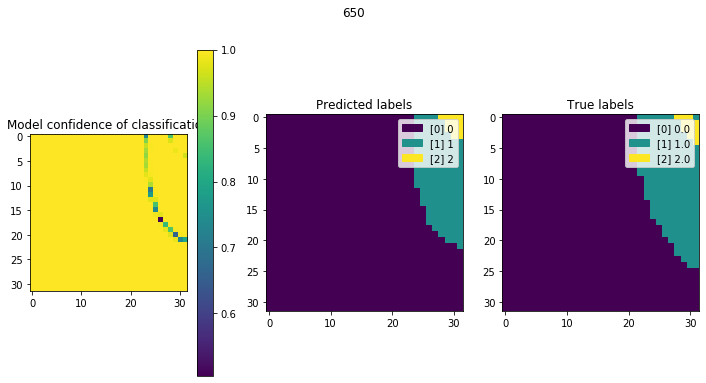

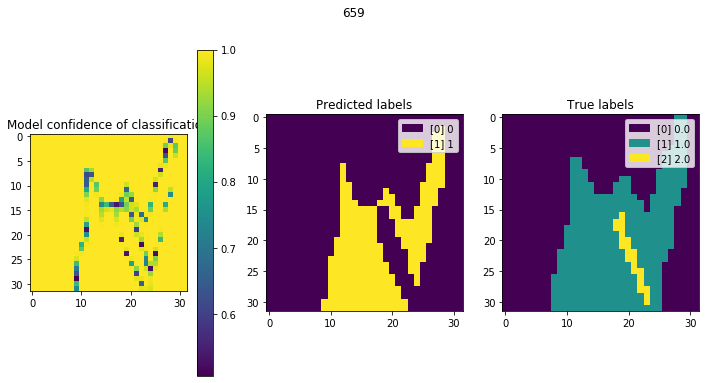

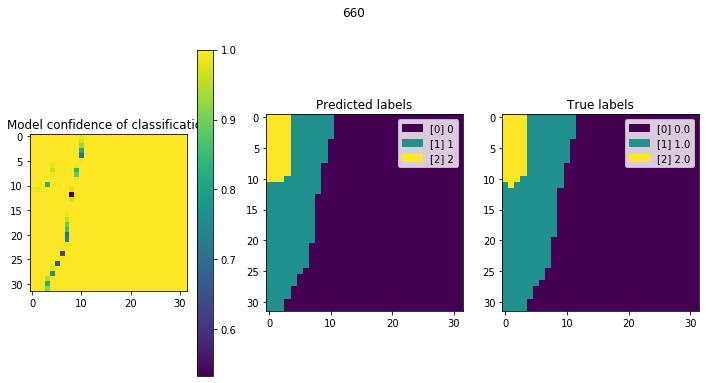

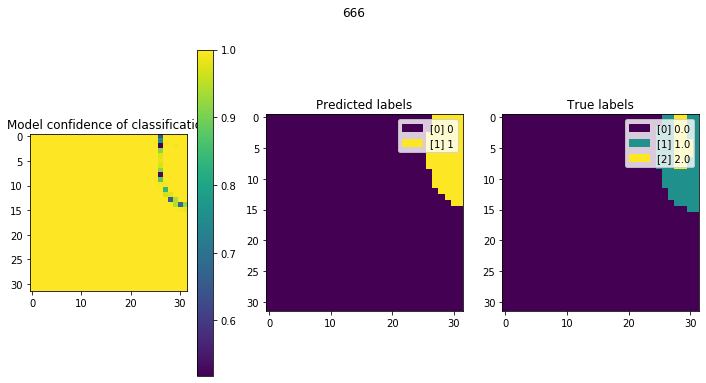

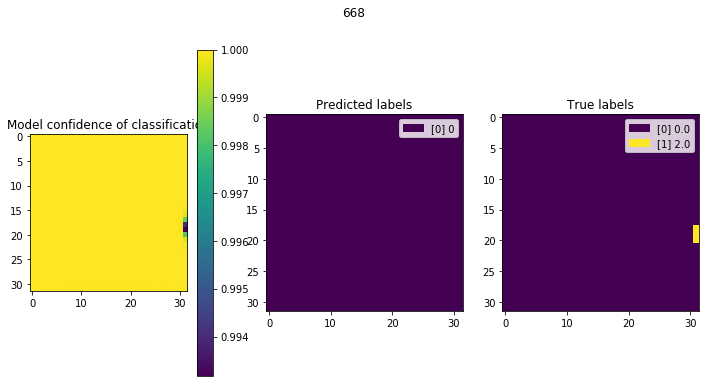

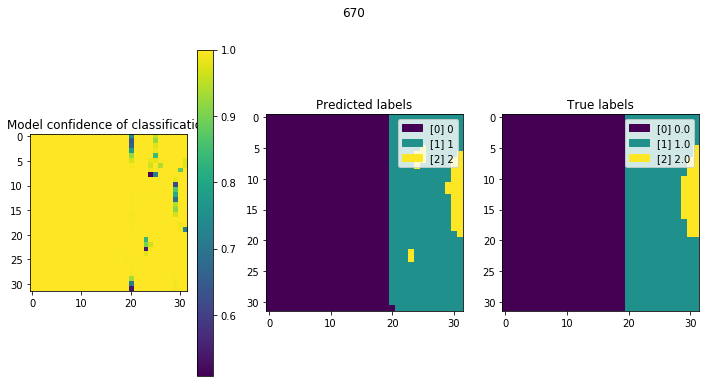

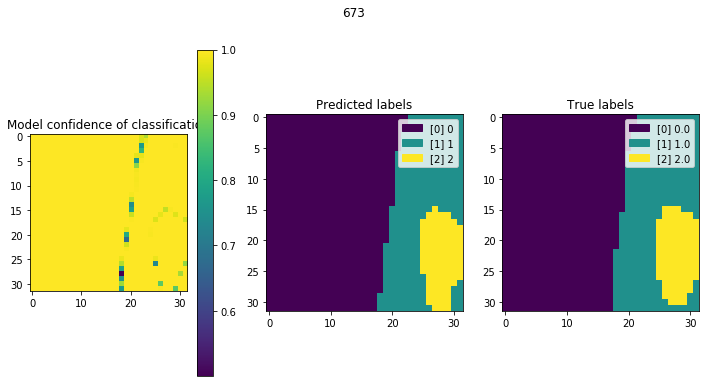

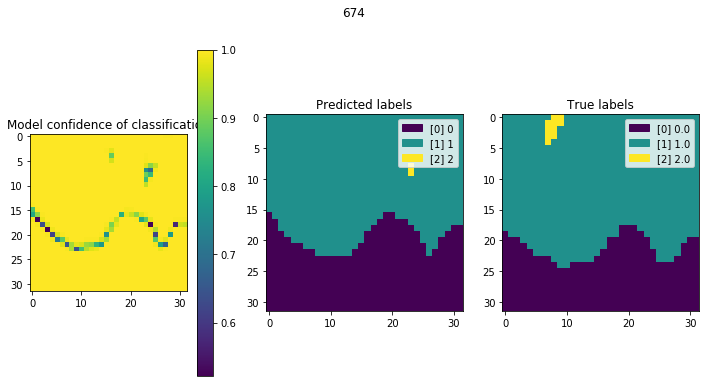

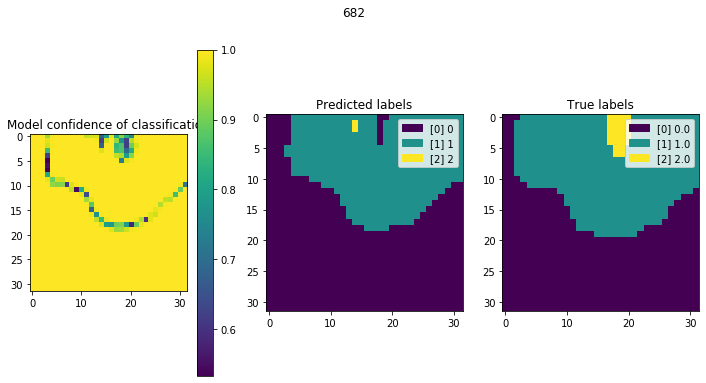

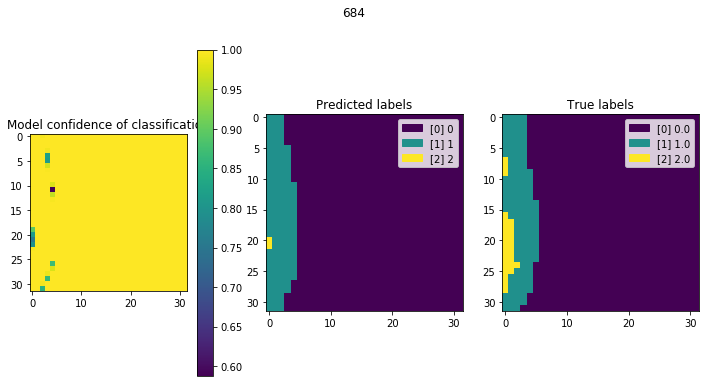

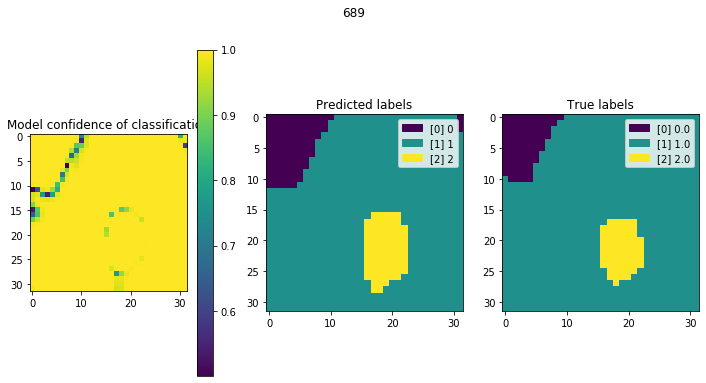

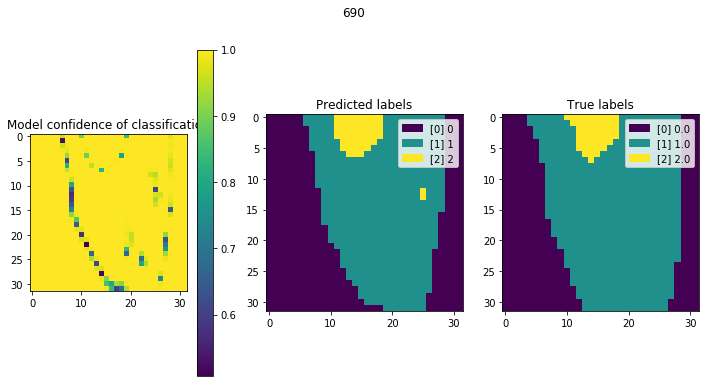

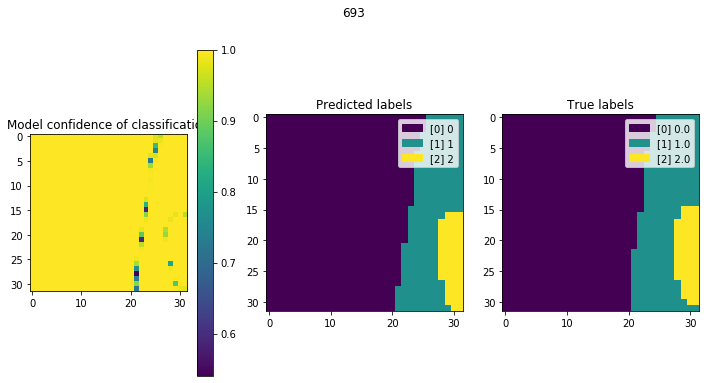

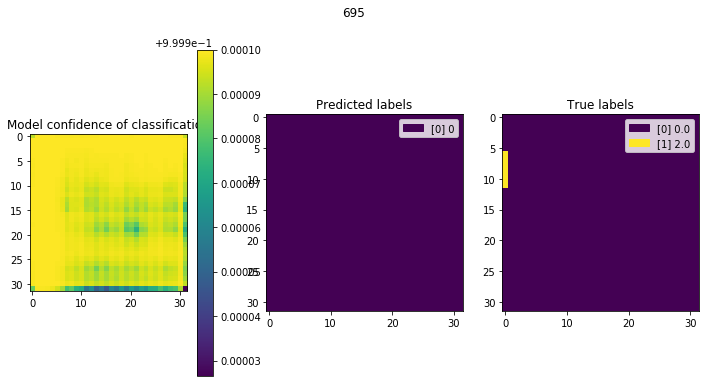

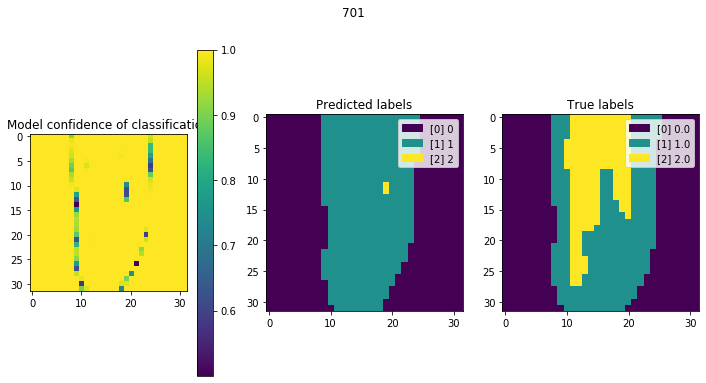

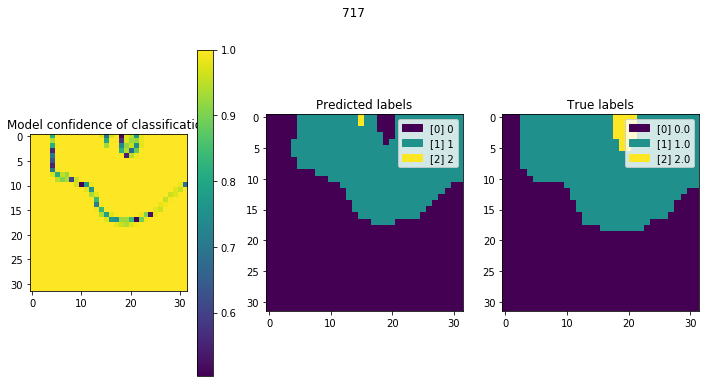

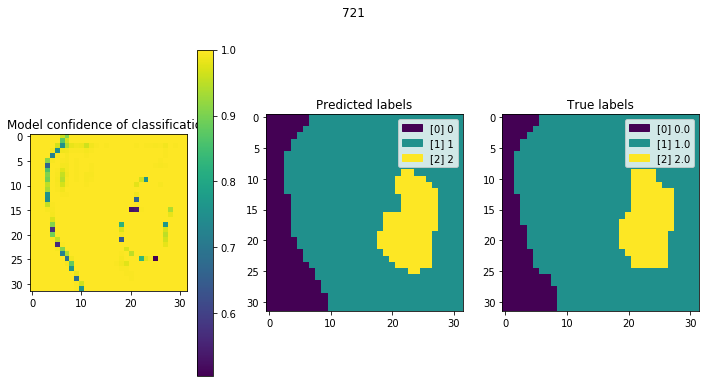

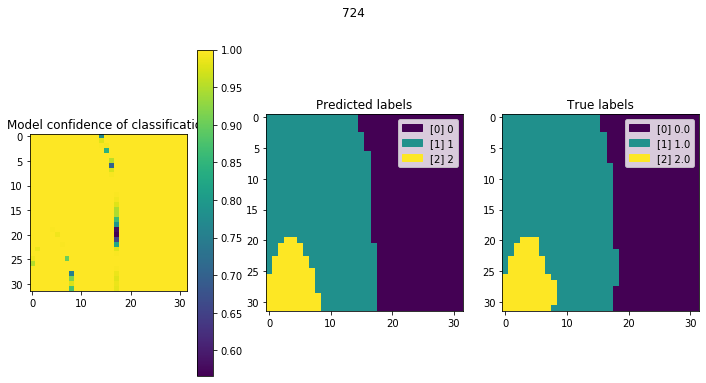

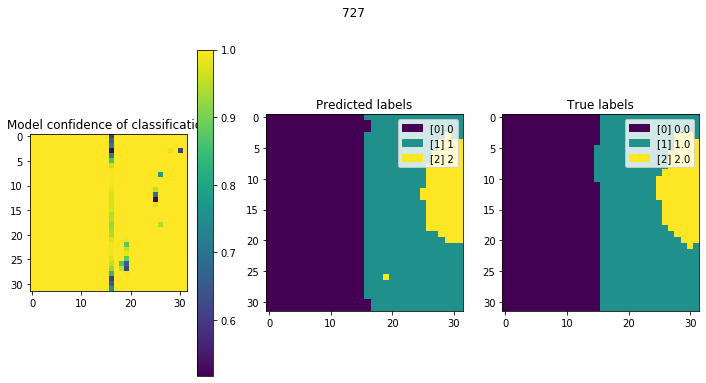

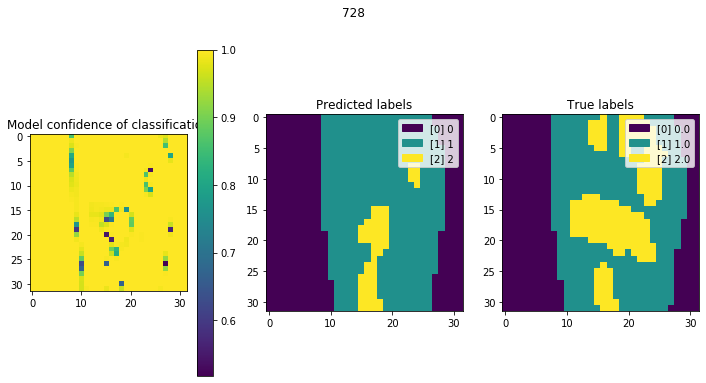

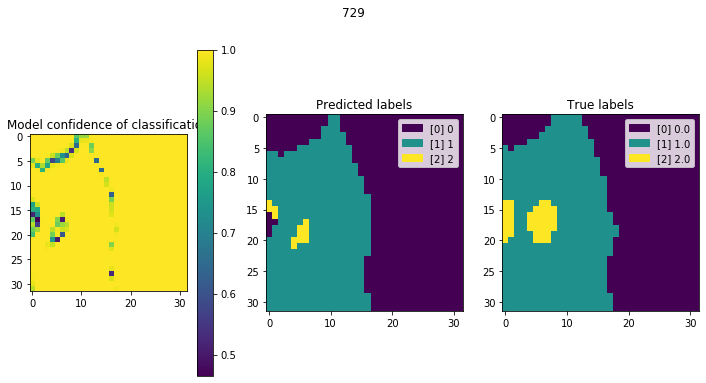

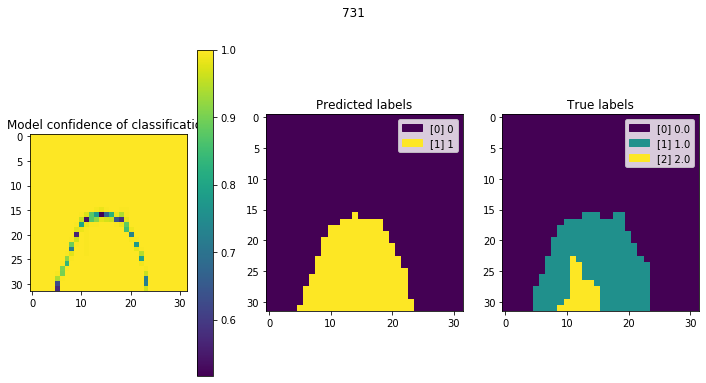

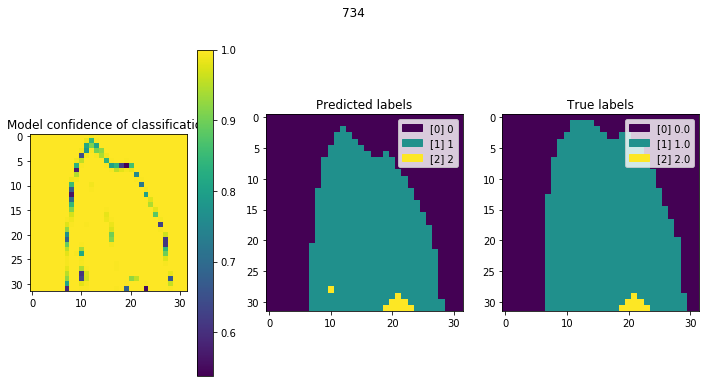

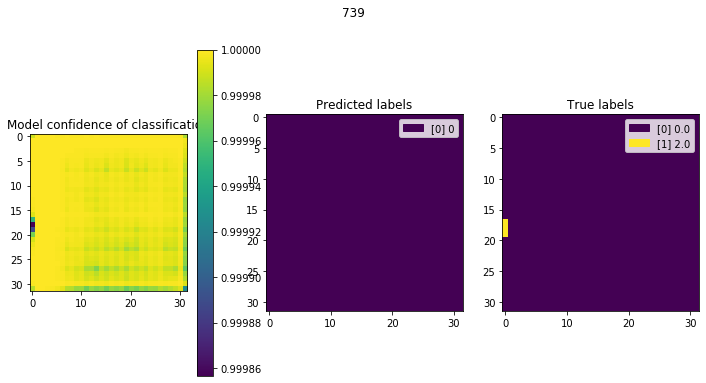

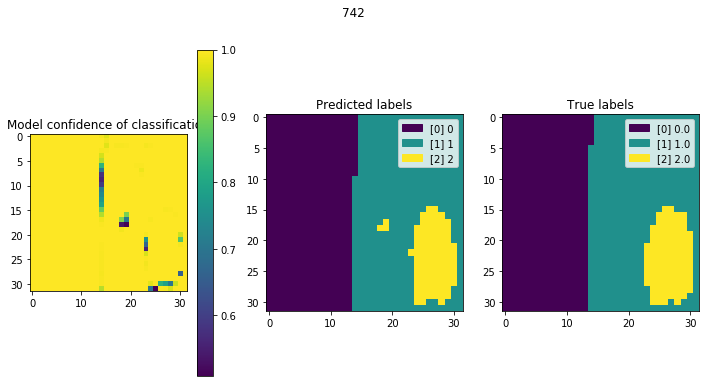

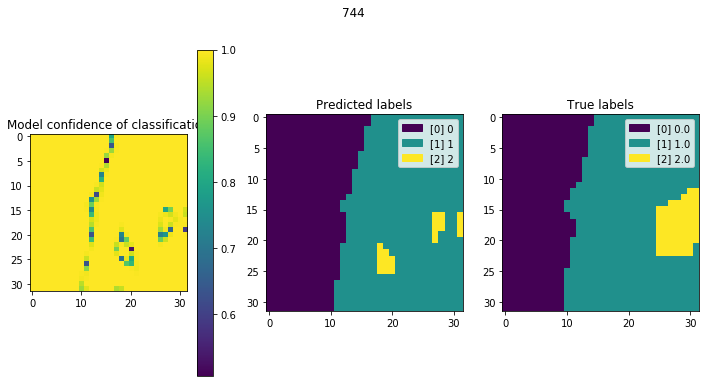

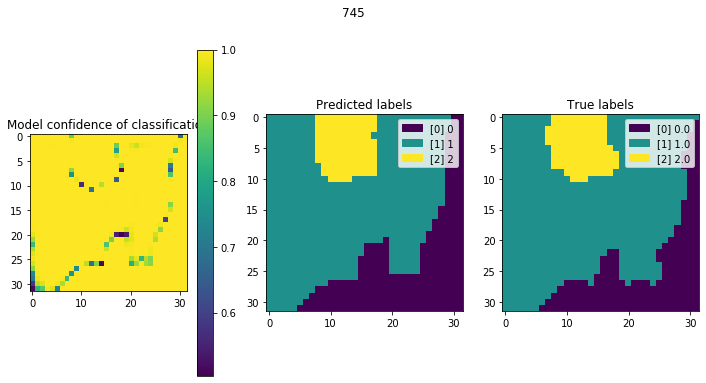

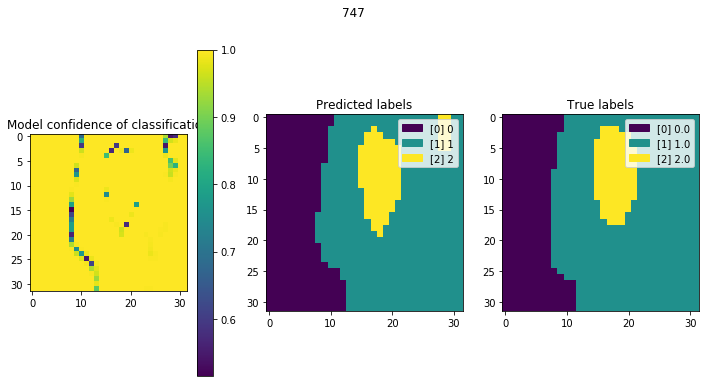

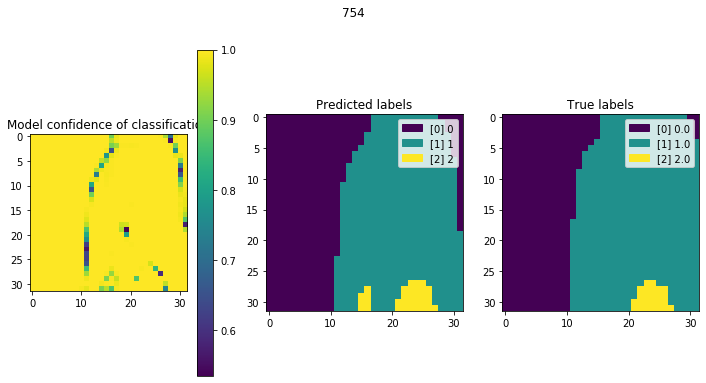

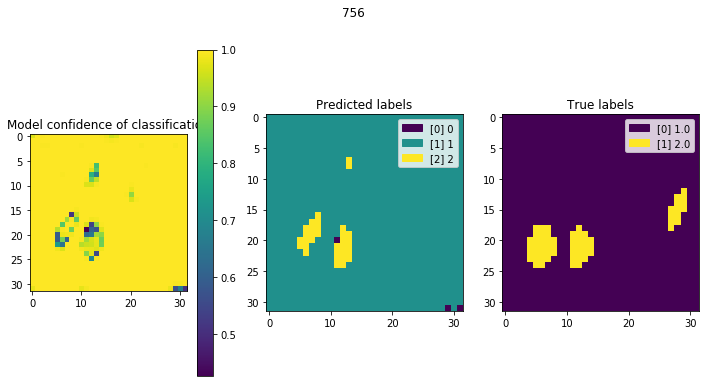

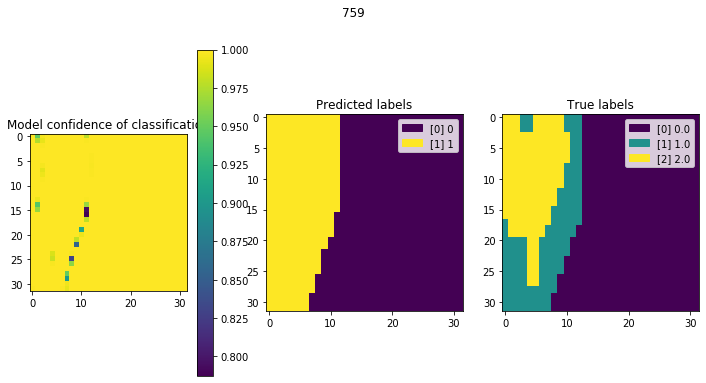

In [39]:
def get_classification_heat_map(y_hat, heat_maps):
    heat = np.zeros(y_hat.shape)
    heat[y_hat == 0] = heat_maps[..., 0][y_hat == 0]
    heat[y_hat == 1] = heat_maps[..., 1][y_hat == 1]
    heat[y_hat == 2] = heat_maps[..., 2][y_hat == 2]
    return heat

def plot_with_heat_map(y_hat, heat_maps, y):
    heat = get_classification_heat_map(y_hat, heat_maps)

    plt.figure(figsize=(12, 6))
    plt.subplot(131)
    plt.imshow(heat)
    plt.colorbar()
    plt.title("Model confidence of classification")
    plt.subplot(132)
    img = plt.imshow(y_hat)
    mypackage.Dataset._Dataset__add_legend_to_image(y_hat, img)
    plt.title("Predicted labels")
    plt.subplot(133)
    img = plt.imshow(np.squeeze(y))
    mypackage.Dataset._Dataset__add_legend_to_image(y, img)
    plt.title("True labels")

# y_pred_test, y_pred_heat = unet.predict(X_test[..., channels_used], Y_labels=Y_test, return_heat_map=True);
for i in range(len(Y_test)):
    if 2 in Y_test[i]:
        plot_with_heat_map(y_pred_test[i], y_pred_heat[i], Y_test[i])
        plt.suptitle(i)
        

In [ ]:
# # https://stackoverflow.com/questions/38009682/how-to-tell-if-tensorflow-is-using-gpu-acceleration-from-inside-python-shell
# import tensorflow as tf
# from tensorflow.python.client import device_lib

# print(device_lib.list_local_devices())
# print("The following list should not be empty")
# print(tf.test.gpu_device_name())
# print("The following should contain stuff, and then be True, True")
# print(tf.config.experimental.list_physical_devices('GPU'), tf.test.is_built_with_cuda(), tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None))